# Proyecto 04 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime


import itertools

#Plotting libraries
import altair as alt
plt.style.use('seaborn-white')
%matplotlib inline


#import math
import seaborn as sns
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import scipy.stats as scs
#import earthpy as et



#statistics libraries
import statsmodels.api as sm
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
#from nimbusml.timeseries import SsaForecaster
from statsmodels.tsa.statespace.tools import diff as diff
from sklearn.preprocessing import StandardScaler


#library to use R in Python 
#import rpy2
#from rpy2.robjects import pandas2ri
#pandas2ri.activate()
 




Using TensorFlow backend.


In [2]:
from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox

In [3]:
#statistics libraries


from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
from statsmodels.tsa.statespace.tools import diff as diff
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from scipy.stats import jarque_bera as jb
from itertools import combinations
from fbprophet import Prophet


from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from pylab import rcParams
from statsmodels.tsa.stattools import acf

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [4]:
# Creamos una función para verificar la estacionariedad de la serie:
# Los valores a pasarle a la función serán la serie y la ventana de tiempo a evaluar

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window):

    #Calcular las medidas estadísticas (media y varianza)
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Graficar la media y varianza de la serie
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Efectuar el test de estacionariedad
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [5]:
# Crear una función para mostrar la autocorrelación y autocorrelación parcial de la serie, junto con el test de estacionalidad
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Graficar la serie, con la Autocorrelación y Autocorrelación parcial, calcular el test Dickey–Fuller test
        
        y - timeseries
        lags - cuántos lags (retardo) incluir en el cálculo de la autocorrelación 
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Análisis de la Serie\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [6]:
# Crear Features de día, mes, año, etc.


def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [7]:
# Creamos una función para checkear el mejor valor para eliminar la estacionalidad:

# Rho: coeficiente constante que determina cuánto cambia la serie del punto t a t+1

def plotProcess(x,rho=0):
    w = x 
    for t in range(len(x)):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3))) 

In [8]:
# Creamos una función para obtener el valor de las medias móviles:

def moving_average(series, n):
    """
        Calcular la media móviles de las últimas observaciones
    """
    return np.average(series[-n:])

In [9]:
# Creamos una Función para graficar las ventanas de tiempo

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, 
                      plot_anomalies=False):

    """
        series - Dataset a utilizar
        window - Tamaño de la ventana de tiempo
        plot_intervals - Mostrar los intervalos de confianza
        plot_anomalies - Mostrar las anomalías

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(20,10))
    plt.title("Medias Móviles \n Ventana de tiempo = {}".format(window))
    plt.plot(rolling_mean, "g", label="Tendencia de la ventana de tiempo")

    # Graficar los intervalos de confianza
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Margen Superior / margen inferior")
        plt.plot(lower_bond, "r--")
        
        # Encontrar anomalías
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond] # Buscamos valores inferiores a los valores mínimos de la media móvil
            anomalies[series>upper_bond] = series[series>upper_bond] # Buscamos valores superiores a los valores máximos de la media móvil
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Valores actuales")
    plt.legend(loc="upper left")
    plt.grid(True)


In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Obtener el MAPE a partir de y_true y y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
# Almacenamos los dataset en una variable
data_2019 = pd.read_csv('Datasets/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('Datasets/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('Datasets/flujo-vehicular-2017.csv', sep =',')

In [12]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


periodo       fecha  hora_inicio  hora_fin     dia    estacion    sentido  \
0     2019  2019-01-01            0         1  Martes     Alberti     Centro   
1     2019  2019-01-01            0         1  Martes     Alberti     Centro   
2     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
3     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
4     2019  2019-01-01            0         1  Martes  Avellaneda     Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              22  
1       Liviano    TELEPASE               6  
2       Liviano  NO COBRADO              53  
3       Liviano    TELEPASE              18  
4       Liviano    EFECTIVO              16

In [13]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


periodo       fecha  hora_inicio  hora_fin    dia estacion sentido  \
0     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
1     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
2     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
3     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
4     2018  2018-01-01            2         3  Lunes  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              29  
1       Liviano    TELEPASE               9  
2       Liviano  NO COBRADO              73  
3       Liviano    TELEPASE              39  
4       Liviano  NO COBRADO             115

In [14]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


periodo       fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
1     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
2     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
3     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
4     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              25  
1       Liviano    TELEPASE               7  
2       Liviano  NO COBRADO               5  
3       Liviano    EFECTIVO               2  
4       Liviano    EFECTIVO              94

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [15]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [16]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [17]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [18]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [19]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

fecha  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos
80   2019-01-01         2  Martes     Centro       Liviano             537
86   2019-01-01         2  Martes     Centro        Pesado               1
88   2019-01-01         2  Martes  Provincia       Liviano             443
94   2019-01-01         2  Martes  Provincia        Pesado               1
149  2019-01-01         3  Martes     Centro       Liviano             769

In [20]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos              fecha2
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [21]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [22]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
0       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
1       Domingo  Provincia       Liviano               9 2017-01-01 00:00:00
2       Domingo  Provincia       Liviano             644 2017-01-01 00:00:00
3       Domingo  Provincia        Pesado               6 2017-01-01 00:00:00
4       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
...         ...        ...           ...             ...                 ...
238864   Martes  Provincia       Liviano             556 2019-12-31 22:00:00
238865   Martes  Provincia        Pesado               1 2019-12-31 22:00:00
238866   Martes     Centro       Liviano             580 2019-12-31 22:00:00
238867   Martes     Centro       Liviano             214 2019-12-31 23:00:00
238868   Martes  Provincia       Liviano             190 2019-12-31 23:00:00

[238869 rows x 5 columns]

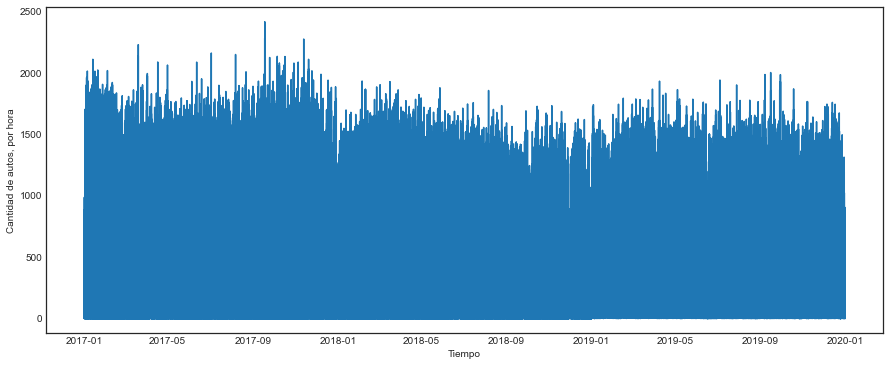

In [23]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [24]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable

diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


cantidad_pasos
fecha                     
2017-01-01           31183
2017-01-02           51568
2017-01-03           51093
2017-01-04           53332
2017-01-05           56486

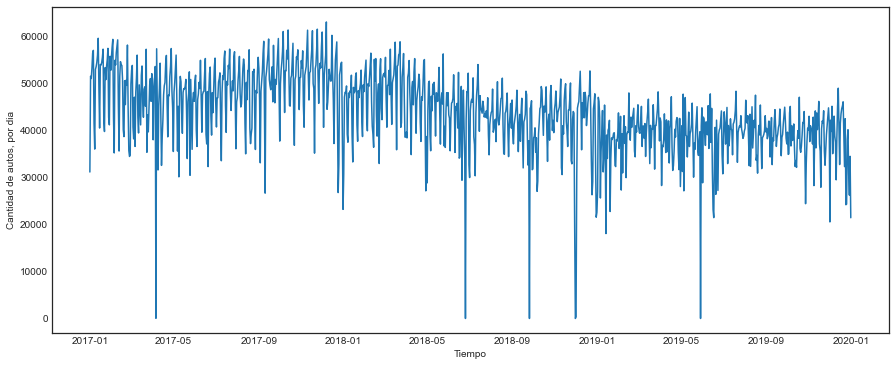

In [25]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

# Observaciones con la información provista:
A primera vista, la serie presenta una tendencia decreciente, donde los valores medios del año 2017 pasan a ser los valores máximos de 2019.
A su vez, se presenta estacionalidad, con picos y valles marcados.
Se presentan también anomalías decrecientes, para un valor de 2017, 3 valores de 2018 y un valor de 2019.


# Objetivos Planteados:
* Dar una breve introducción a las series de tiempo, de manera educativa y para uso de otras personas con interés de indagar en este tipo de predicciones.
* Efectuar un análisis exploratorio de datos exhaustivo, para comprender la composición de una serie a modo explicativo y que pueda ser utilizado por otros.
* Implementar modelos de predicción específicos a la temática, con el objetivo de comprobar si mejoran las métricas de predicción.

# Empezando por el inicio... 
## ¿Qué es una serie de tiempo?

Sintéticamente, se puede definir como una sucesión de datos medidos en determinados momentos y ordenados cronológicamente.
Los datos pueden estar espaciados a intervalos iguales o desiguales.
* Lo que es importante destacar que a través de una serie de tiempo, lo que se intenta describir es el comportamiento de una variable con el paso del tiempo.

## ¿Cómo está compuesta una serie?

Una serie puede tener los siguientes componentes:
1) Tendencia:componente sistemático general lineal o no lineal que cambia con el tiempo y no se repite (crecientes o decrecientes)
2) Estacionalidad: componente sistemático general lineal o no lineal que cambia con el tiempo y se repite cíclicamente.
3) Ruido: componente no sistemático que no es Tendencia / Estacionalidad dentro de los datos

* Respecto a los componentes de la serie, cuando las analizamos a través de la descomposición, intentamos determinar si la misma cuenta con alguno de estos componentes o los tres.
* En el caso que no tuviera estos componentes, se dice que la serie tiene un comportamiento de $Ruido Blanco$, donde su media es cero, la varianza es constante y es incorrelacionada (las variables de tiempo no se encuentran relacionadas entre sí). Para llevar a cabo predicciones a futuro, buscamos que las series sean lo más parecido a un $Ruido Blanco$ en el comportamiento pasado, y de esta manera reducir el error de predicción.



### Parte A - Exploración de Datos. 
Todo proyecto de Ciencia de Datos. Empieza con un Análisis Exploratorio de Datos. 
Y todo Análisis Exploratorio de Datos debe responder preguntas.

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Indagación del dataset

In [26]:
# hacer una copia del dataset
dataset_copy = dataset
dataset_copy.head()

dia    sentido tipo_vehiculo  cantidad_pasos      fecha
0  Domingo  Provincia        Pesado               1 2017-01-01
1  Domingo  Provincia       Liviano               9 2017-01-01
2  Domingo  Provincia       Liviano             644 2017-01-01
3  Domingo  Provincia        Pesado               6 2017-01-01
4  Domingo  Provincia        Pesado               1 2017-01-01

# Análisis del dataset completo - sin filtrar por autopista o medio de pago

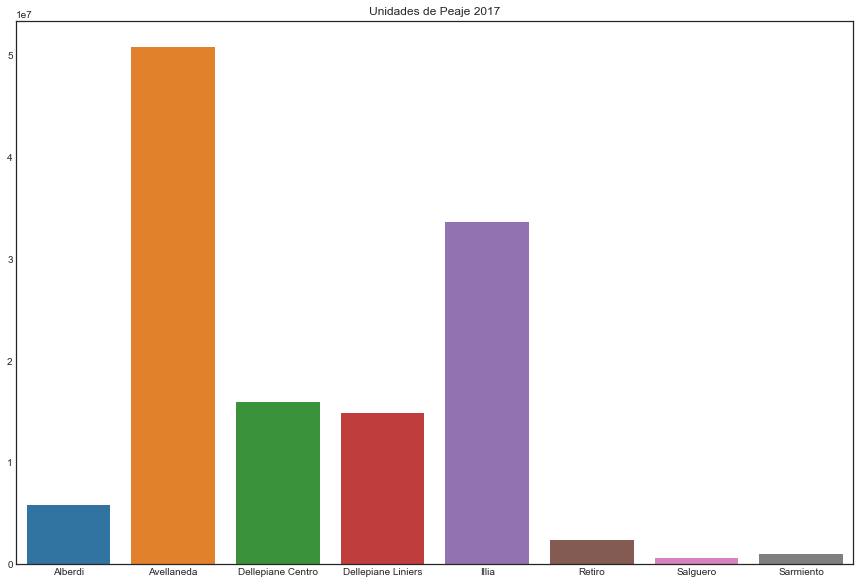

In [27]:
valores = data_2017.groupby(["estacion"])["cantidad_pasos"].sum().tolist()
columnas = data_2017.groupby(["estacion"])["estacion"].max().tolist()
plt.figure(figsize = (15,10))
sns.barplot (columnas, valores)
plt.title("Unidades de Peaje 2017")
plt.show()

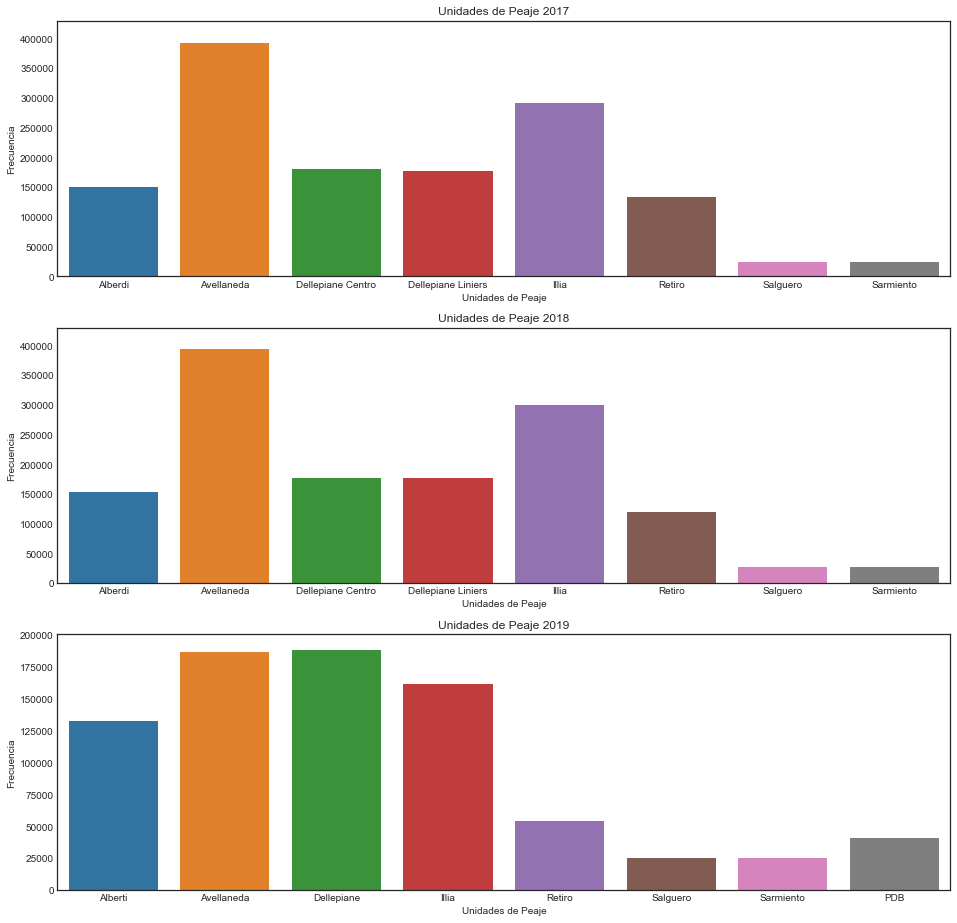

In [28]:
# Efectuar la comparación de las unidades de Peaje por año por estación


plt.figure(figsize = (16,16))


#hacer el sub gráfico
plt.subplot(3,1,1)  
sns.countplot(data = data_2017, x = "estacion")
plt.title("Unidades de Peaje 2017")
plt.xlabel("Unidades de Peaje")
plt.ylabel("Frecuencia")
#plt.xticks(rotation=90)
#plt.xlim(0, 8)
plt.ylim(0, 430000)

# Iterate through the list of axes' patches
#ax = plt.gca()
#for p in ax.patches:
#    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
#            fontsize=10, color='black', ha='center', va='bottom');



plt.subplot(3,1,2)
#plt.figure(figsize=(25,6))
sns.countplot(data = data_2018, x = "estacion");
plt.title("Unidades de Peaje 2018")
plt.xlabel("Unidades de Peaje")
plt.ylabel("Frecuencia")
#plt.xlim(0, 8)
plt.ylim(0, 430000)



# Iterate through the list of axes' patches
#ax = plt.gca()
#for p in ax.patches:
#    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
 #           fontsize=10, color='black', ha='center', va='bottom');


plt.subplot(3,1,3)
#plt.figure(figsize=(25,6))
sns.countplot(data = data_2019, x = "estacion");
plt.title("Unidades de Peaje 2019")
plt.xlabel("Unidades de Peaje")
plt.ylabel("Frecuencia")
#plt.xlim(0, 8)
plt.ylim(0, 200000);


# Iterate through the list of axes' patches
#ax = plt.gca()
#for p in ax.patches:
#    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
#            fontsize=10, color='black', ha='center', va='bottom');

De acuerdo a las gráficas, en 2019, La frecuencia de pasadas en todas las estaciones se redujo a la mitad.
* Se puede observar que en 2019, las unidades de Peaje Dellepiane Centro y Dellepiane Liniers fueron unificadas en una sola.
* En 2019 se incorporó una estación PDB-
, generando que si se toma la media de pasadas por año "simule" un incremento en la cantidad de pasadas que no es, si no que disminuye el divisor para el cálculo de la media.

#### Efectuar una comparación de la autopista Illia - Solo Efectivo con los valores generales

In [29]:
# Tomar como índice la columna de la fecha
dataset.set_index('fecha',inplace=True)
dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos
fecha                                                       
2017-01-01  Domingo  Provincia        Pesado               1
2017-01-01  Domingo  Provincia       Liviano               9
2017-01-01  Domingo  Provincia       Liviano             644
2017-01-01  Domingo  Provincia        Pesado               6
2017-01-01  Domingo  Provincia        Pesado               1

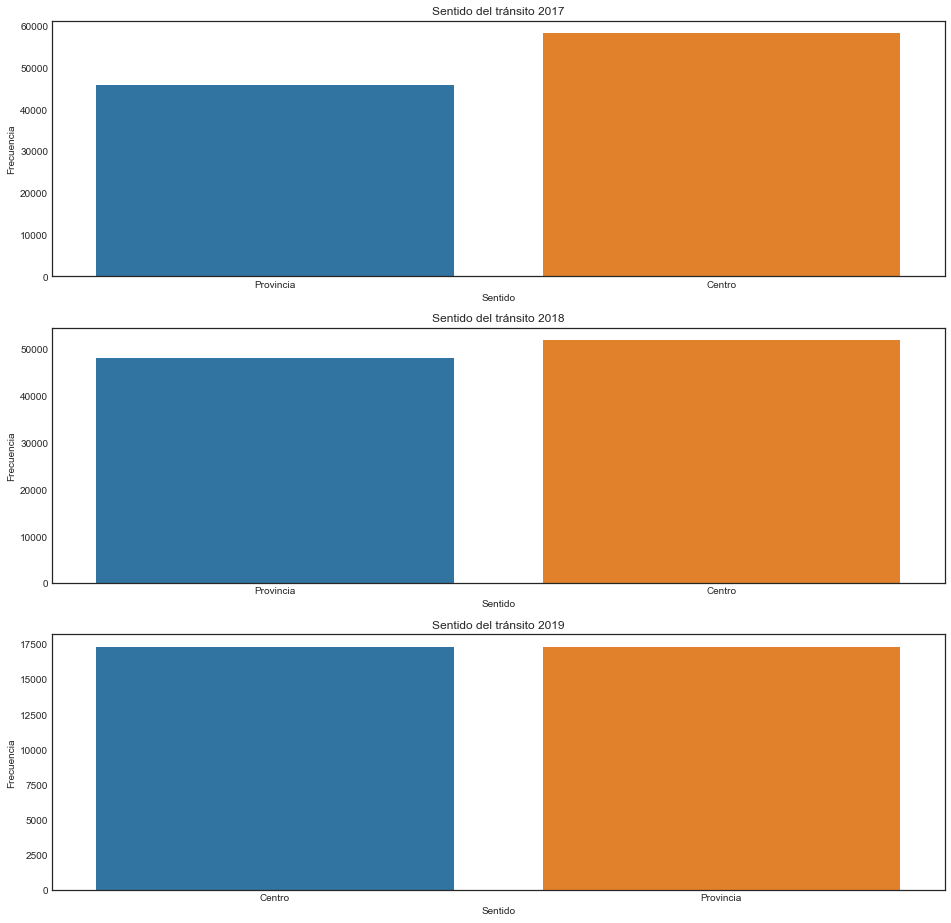

In [30]:
#Verificar el sentido del tránsito a lo largo de los años:
# Efectuar la comparación de las unidades de Peaje por año por tipo de vehículo


plt.figure(figsize = (16,16))




#hacer el sub gráfico
plt.subplot(3,1,1)  
sns.countplot(data = dataset ["2017-01-01" : "2017-12-31"], x = "sentido")
plt.title("Sentido del tránsito 2017")
plt.xlabel("Sentido")
plt.ylabel("Frecuencia")
#plt.xticks(rotation=90)
#plt.xlim(0, 2)
#plt.ylim(0, 430000)


plt.subplot(3,1,2)
#plt.figure(figsize=(25,6))
sns.countplot(data = dataset ["2018-01-01" : "2018-12-31"], x = "sentido");
plt.title("Sentido del tránsito 2018")
plt.xlabel("Sentido")
plt.ylabel("Frecuencia")
#plt.xlim(0, 2)
#plt.ylim(0, 430000)


plt.subplot(3,1,3)
#plt.figure(figsize=(25,6))
sns.countplot(data = dataset ["2019-01-01" : "2019-12-31"], x = "sentido");
plt.title("Sentido del tránsito 2019")
plt.xlabel("Sentido")
plt.ylabel("Frecuencia");
#plt.xlim(0, 2)
#plt.ylim(0, 200000);



* Las gráficas permiten observar como el tránsito en dirección provincia se mantiene constante durante 2017 y 2018, con una amplia reducción en 2019, como el sentido centro, disminuyendo este último en más del 100%. 

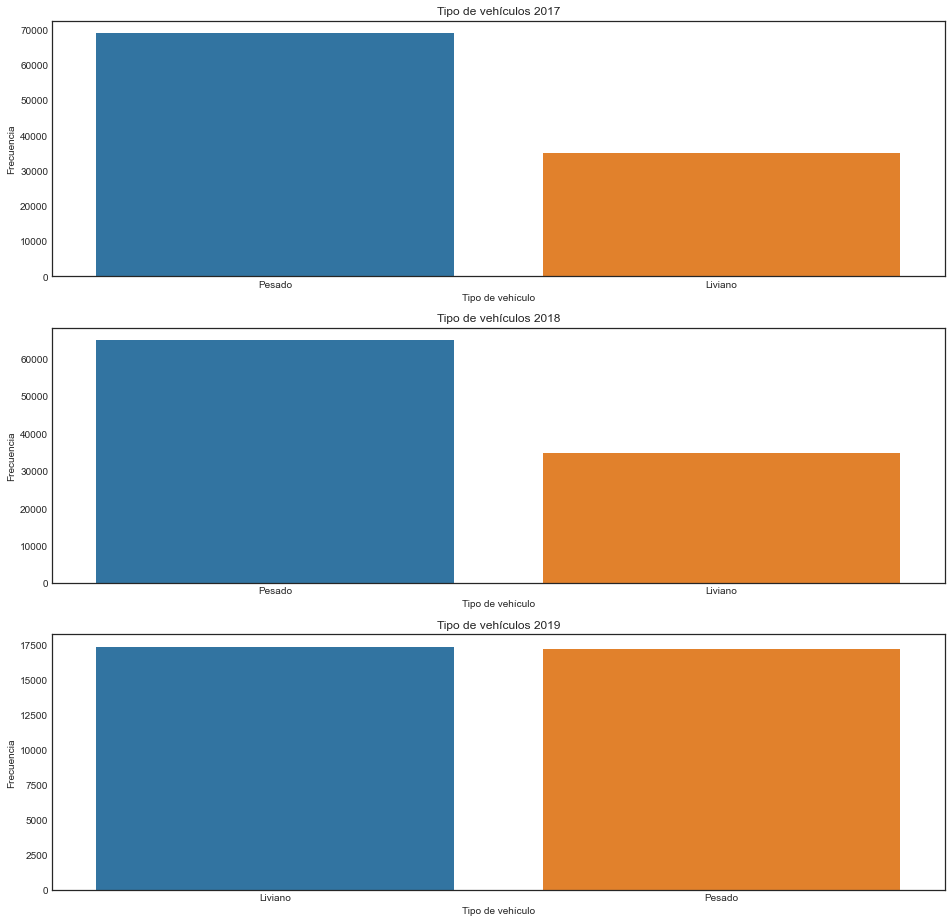

In [31]:
#Verificar el sentido del tránsito a lo largo de los años:
# Efectuar la comparación de las unidades de Peaje por año por tipo de vehículo


plt.figure(figsize = (16,16))





#hacer el sub gráfico
plt.subplot(3,1,1)  
sns.countplot(data = dataset ["2017-01-01" : "2017-12-31"], x = "tipo_vehiculo")
plt.title("Tipo de vehículos 2017")
plt.xlabel("Tipo de vehículo")
plt.ylabel("Frecuencia")
#plt.xticks(rotation=90)
#plt.xlim(0, 2)
#plt.ylim(0, 430000)



plt.subplot(3,1,2)
#plt.figure(figsize=(25,6))
sns.countplot(data = dataset ["2018-01-01" : "2018-12-31"], x = "tipo_vehiculo");
plt.title("Tipo de vehículos 2018")
plt.xlabel("Tipo de vehículo")
plt.ylabel("Frecuencia")
#plt.xlim(0, 2)
#plt.ylim(0, 430000)




plt.subplot(3,1,3)
#plt.figure(figsize=(25,6))
sns.countplot(data = dataset ["2019-01-01" : "2019-12-31"], x = "tipo_vehiculo");
plt.title("Tipo de vehículos 2019")
plt.xlabel("Tipo de vehículo")
plt.ylabel("Frecuencia");
#plt.xlim(0, 2)
#plt.ylim(0, 200000);



* La gráfica permite observar como a lo largo de los años los tipos de vehículos que circulan por la autopista y abonan en efectivo se acercaron por amplia tendencia decreciente en el volumen del tránsito pesado, incluso llegando a revertirse en 2019.
* El tránsito liviano creció  a más del doble de 2018 a 2019, mientras que el tránsito pesado disminuyó en más de un 100%.

## Pregunta elegida: Porqué descienden para la autopista Illia la cantidad de pasos en la modalidad efectivo?

#### Creamos un Dataset que almacene todos los datos de la autopista Illia, teniendo en cuenta todas las modalidades de pago, con el objetivo de analizar los descensos en la cantidad de pasos:

In [32]:
#Volvemos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
df_illia = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia 

df_illia = df_illia[df_illia.estacion.isin(["Illia"])]

#Quitamos las columnas que no vamos a utilizar
df_illia.drop(columns = ['periodo','hora_inicio','estacion'], inplace = True)

df_illia.head()

fecha  hora_fin     dia    sentido tipo_vehiculo  forma_pago  \
19  2019-01-01         1  Martes     Centro       Liviano  NO COBRADO   
20  2019-01-01         1  Martes     Centro       Liviano    TELEPASE   
21  2019-01-01         1  Martes     Centro        Pesado    TELEPASE   
22  2019-01-01         1  Martes  Provincia       Liviano  NO COBRADO   
23  2019-01-01         1  Martes  Provincia       Liviano    TELEPASE   

    cantidad_pasos  
19             146  
20              59  
21               1  
22             147  
23             106

In [33]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
df_illia['fecha2'] = pd.to_datetime(df_illia.fecha) + pd.to_timedelta(df_illia.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
df_illia.drop(columns=['fecha','hora_fin'], inplace = True)


#Corregimos el nombre de fecha2 a fecha
df_illia.rename(columns = {'fecha2':'fecha'}, inplace = True) 



#Reordenamos el dataset por fecha
df_illia.sort_values('fecha', inplace = True)
df_illia.reset_index(drop=True, inplace = True)
df_illia.head()


dia    sentido tipo_vehiculo forma_pago  cantidad_pasos      fecha
0  Domingo     Centro       Liviano   TELEPASE             459 2017-01-01
1  Domingo  Provincia        Pesado   TELEPASE               3 2017-01-01
2  Domingo  Provincia        Pesado   EFECTIVO               1 2017-01-01
3  Domingo  Provincia        Pesado   TELEPASE               7 2017-01-01
4  Domingo  Provincia        Pesado   EFECTIVO               6 2017-01-01

In [34]:
# hacer una copia del dataset
df_illia_copy = df_illia
df_illia_copy.head()

dia    sentido tipo_vehiculo forma_pago  cantidad_pasos      fecha
0  Domingo     Centro       Liviano   TELEPASE             459 2017-01-01
1  Domingo  Provincia        Pesado   TELEPASE               3 2017-01-01
2  Domingo  Provincia        Pesado   EFECTIVO               1 2017-01-01
3  Domingo  Provincia        Pesado   TELEPASE               7 2017-01-01
4  Domingo  Provincia        Pesado   EFECTIVO               6 2017-01-01

In [35]:
# Tomar como índice la columna de la fecha
df_illia.set_index('fecha',inplace=True)
df_illia.head()

dia    sentido tipo_vehiculo forma_pago  cantidad_pasos
fecha                                                                  
2017-01-01  Domingo     Centro       Liviano   TELEPASE             459
2017-01-01  Domingo  Provincia        Pesado   TELEPASE               3
2017-01-01  Domingo  Provincia        Pesado   EFECTIVO               1
2017-01-01  Domingo  Provincia        Pesado   TELEPASE               7
2017-01-01  Domingo  Provincia        Pesado   EFECTIVO               6

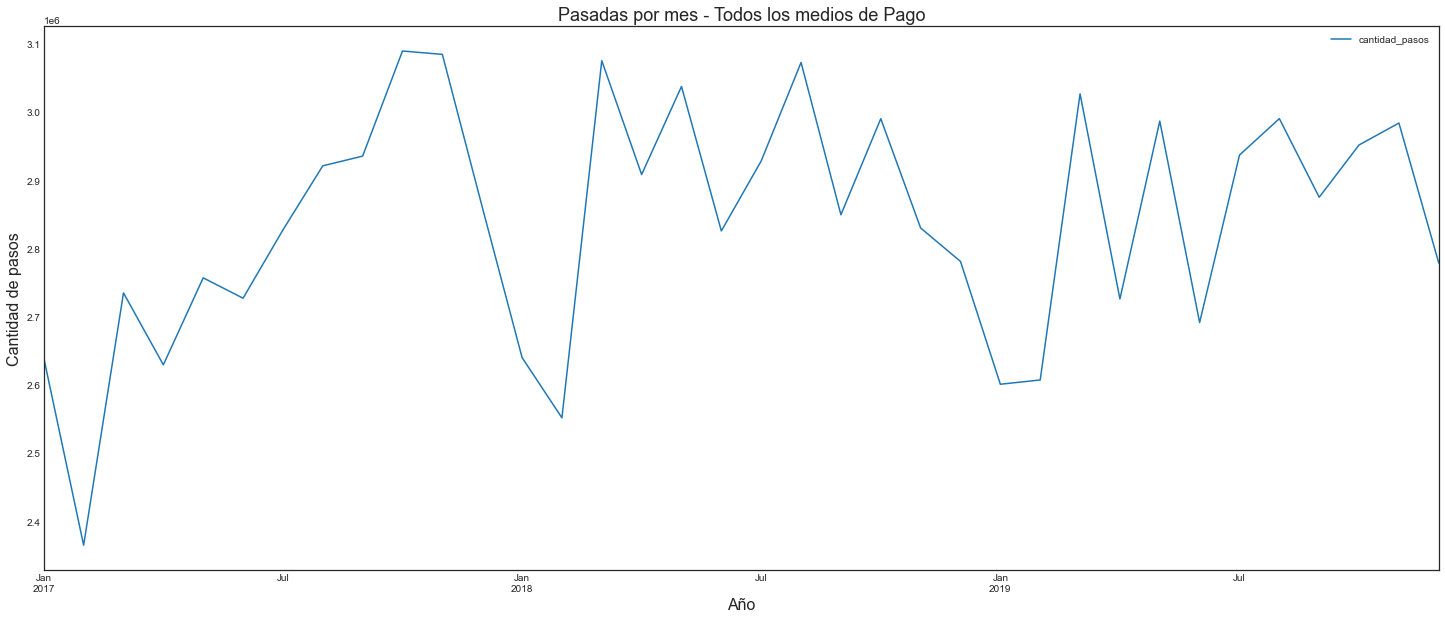

In [36]:
# Verificar las pasadas por mes:
df_illia.groupby(pd.Grouper(freq='M')).agg({'cantidad_pasos':'sum'}).plot(figsize=(25,10))
plt.title ("Pasadas por mes - Todos los medios de Pago", fontsize = 18)
plt.xlabel ("Año", fontsize = 16);
plt.ylabel ("Cantidad de pasos", fontsize = 16);

* A nivel mensual, se puede observar que la cantidad de pasos tomando en cuenta todos los medios de pago presenta una tendencia creciente durante 2017, cual no se puede observar durante 2018 y 2019.
* A su vez, la serie presenta anomalías en noviembre de todos los años.

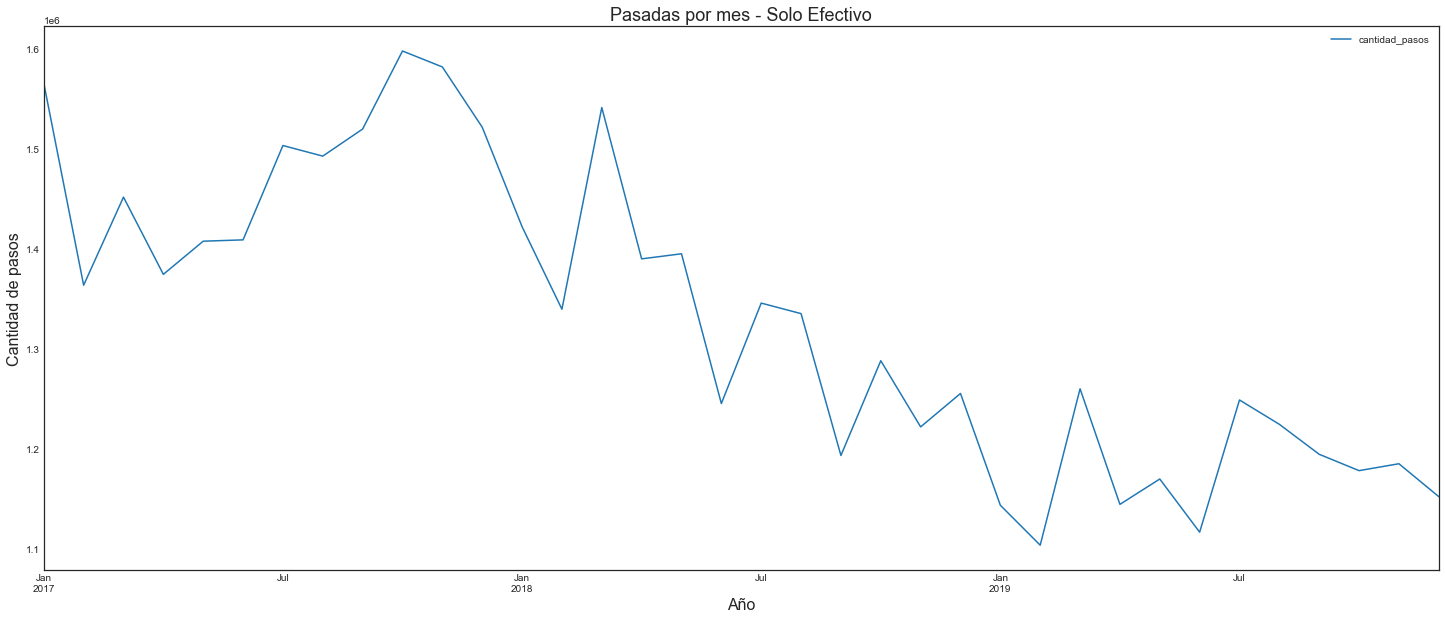

In [37]:
# Verificar las pasadas por mes, solo efectivo:
dataset.groupby(pd.Grouper(freq='M')).agg({'cantidad_pasos':'sum'}).plot(figsize=(25,10))
plt.title ("Pasadas por mes - Solo Efectivo", fontsize = 18)
plt.xlabel ("Año", fontsize = 16);
plt.ylabel ("Cantidad de pasos", fontsize = 16);

* La gráfica permite observar la notable diferencia en el comportamiento de las series con todas las modalidades de pago y la modalidad solo efectivo.
La modalidad de efectivo presenta una tendencia decreciente muy grande en el año 2018, mientras que tomando en cuenta todas las modalides de pago esto no ocurre.

In [38]:
# Verificar las modalidades de pago existentes
print(df_illia['forma_pago'].unique())

['TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION' 'TARJETA DISCAPACIDAD'
 'NO COBRADO' 'MONEDERO' 'T. DISCAPACIDAD']


Se verifica que la variable "Tarjeta discapacidad" presenta dos codificaciones distintas.
Unificar los valores de tarjeta discapacidad en una sola.

In [39]:
df_illia ["forma_pago"] = df_illia["forma_pago"].replace(['TARJETA DISCAPACIDAD'], 'T. DISCAPACIDAD')
print(df_illia['forma_pago'].unique())

['TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION' 'T. DISCAPACIDAD'
 'NO COBRADO' 'MONEDERO']


In [40]:
# Comparamos la cantidad de pasos por tipo de forma de pago

# crear una columna que contenga los años a partir de la columna date
df_illia['Año']=df_illia.index.year



In [41]:
# Comparamos la cantidad de pasos por tipo de forma de pago
pivot_pago = df_illia.pivot_table(values='cantidad_pasos',index='forma_pago',columns='Año', aggfunc=np.sum)
pivot_pago

Año                    2017        2018        2019
forma_pago                                         
EFECTIVO         17783512.0  15966944.0  14115125.0
EXENTO             253009.0    194309.0    195205.0
INFRACCION          71900.0    104002.0    164907.0
MONEDERO               16.0         NaN         NaN
NO COBRADO         495895.0    965732.0    866713.0
T. DISCAPACIDAD    228553.0    163047.0    120842.0
TELEPASE         14737699.0  17096004.0  18692375.0

* Se puede observar que la cantidad de pagos en efectivo y tarjeta de discapacidad tienen una tendencia descendente, mientras que los pagos por telepase e infracciones incrementan.
* La modadlidad de pago "no cobrado" se duplica en 2018, pero en 2019 presenta una baja respecto al año anterior.

* La modalidad de pago en efectivo presenta una tendencia decreciente tanto para el tránsito liviano como pesado, al igual que los exentos y tarjeta discapacidad.
* El resto de las variables separando por modalidad de pago, presentan comportamientos inversos.  

#### Graficas comparativas de los comportamientos de las formas de pago por año

In [42]:
# Almacenar las formas de pago
forma_pago = ["EFECTIVO", "TELEPASE", "EXENTO", "INFRACCION", "MONEDERO", "NO COBRADO", "T. DISCAPACIDAD"]

In [43]:
# Agrupar los valores por año
valores_pago_2017 = df_illia[(df_illia.Año == 2017)].groupby(["forma_pago"])["cantidad_pasos"].sum().tolist()
columnas_pago_2017= df_illia[(df_illia.Año == 2017)].groupby(["forma_pago"])["forma_pago"].max().tolist()
valores_pago_2018 = df_illia[(df_illia.Año == 2018)].groupby(["forma_pago"])["cantidad_pasos"].sum().tolist()
columnas_pago_2018= df_illia[(df_illia.Año == 2018)].groupby(["forma_pago"])["forma_pago"].max().tolist()
valores_pago_2019 = df_illia[(df_illia.Año == 2019)].groupby(["forma_pago"])["cantidad_pasos"].sum().tolist()
columnas_pago_2019= df_illia[(df_illia.Año == 2019)].groupby(["forma_pago"])["forma_pago"].max().tolist()

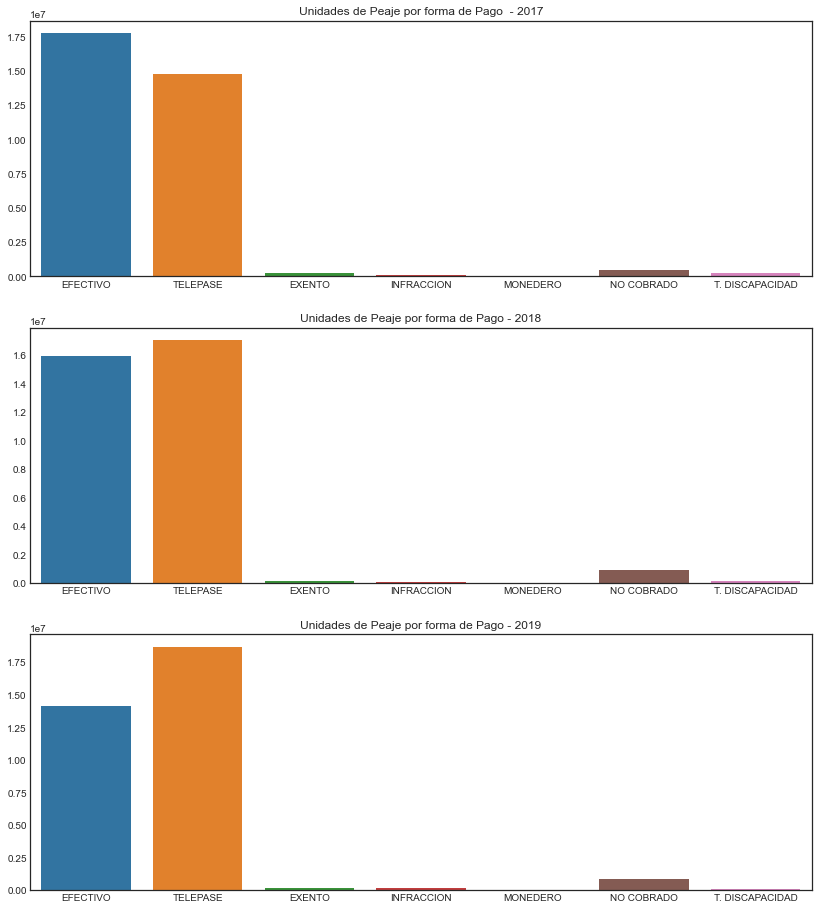

In [44]:
# Graficar las variables para comporarlas
plt.figure(figsize = (14,16))


plt.subplot(3,1,1)
sns.barplot (columnas_pago_2017, valores_pago_2017, order = forma_pago)
plt.title("Unidades de Peaje por forma de Pago  - 2017")

plt.subplot(3,1,2)
sns.barplot (columnas_pago_2018, valores_pago_2018, order = forma_pago)
plt.title("Unidades de Peaje por forma de Pago - 2018")


plt.subplot(3,1,3)
sns.barplot (columnas_pago_2019, valores_pago_2019, order = forma_pago)
plt.title("Unidades de Peaje por forma de Pago - 2019");

* Las gráficas permiten visualizar la información disponible en las tablas, donde la modalidad de pago en efectivo migra a Telepase de manera creciente a lo largo de los tres años.
* Esta es la principal justificación de la disminución en la cantidad de pasos que se visualiza a través de las series de tiempo graficadas solo con la modalidad de efectivo.

In [45]:
# verificamos el comporamiento de la variable tránsito pesado y liviano
df_illia.pivot_table(values='cantidad_pasos',index='Año',columns='tipo_vehiculo', aggfunc=np.sum)

tipo_vehiculo   Liviano   Pesado
Año                             
2017           32069973  1500611
2018           33057425  1432613
2019           33091887  1063280

In [46]:
# Almacenar los títulos
tipo_vehiculo = ["Liviano", "Pesado"]

In [47]:
# Agrupar los datos
valores_vehiculo_2017 = df_illia[(df_illia.Año == 2017)].groupby(["tipo_vehiculo"])["cantidad_pasos"].sum().tolist()
columnas_vehiculo_2017= df_illia[(df_illia.Año == 2017)].groupby(["tipo_vehiculo"])["tipo_vehiculo"].max().tolist()
valores_vehiculo_2018 = df_illia[(df_illia.Año == 2018)].groupby(["tipo_vehiculo"])["cantidad_pasos"].sum().tolist()
columnas_vehiculo_2018= df_illia[(df_illia.Año == 2018)].groupby(["tipo_vehiculo"])["tipo_vehiculo"].max().tolist()
valores_vehiculo_2019 = df_illia[(df_illia.Año == 2019)].groupby(["tipo_vehiculo"])["cantidad_pasos"].sum().tolist()
columnas_vehiculo_2019= df_illia[(df_illia.Año == 2019)].groupby(["tipo_vehiculo"])["tipo_vehiculo"].max().tolist()

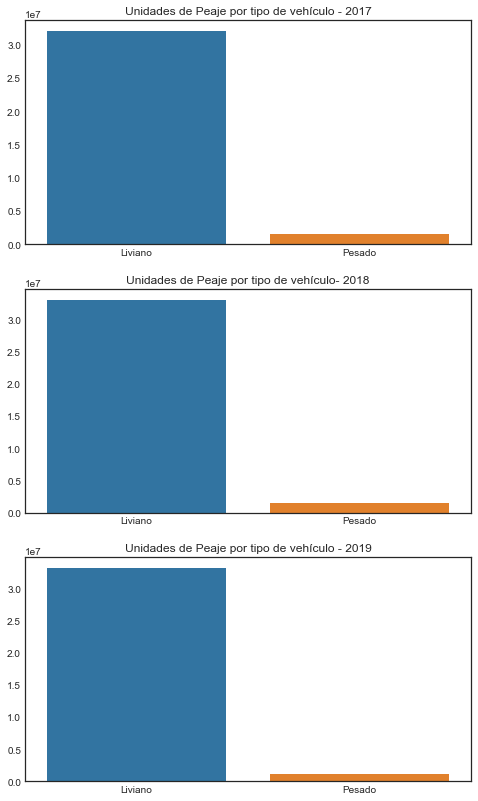

In [48]:
# Graficar para comparar
plt.figure(figsize = (8,14))


plt.subplot(3,1,1)
sns.barplot (columnas_vehiculo_2017, valores_vehiculo_2017, order = tipo_vehiculo)
plt.title("Unidades de Peaje por tipo de vehículo - 2017")

plt.subplot(3,1,2)
sns.barplot (columnas_vehiculo_2018, valores_vehiculo_2018, order = tipo_vehiculo)
plt.title("Unidades de Peaje por tipo de vehículo- 2018")


plt.subplot(3,1,3)
sns.barplot (columnas_vehiculo_2019, valores_vehiculo_2019, order = tipo_vehiculo)
plt.title("Unidades de Peaje por tipo de vehículo - 2019");

* Las gráficas permiten confirmar que solo en el año 2019 se presenta una disminución de la cantidad de pasos en el tránsito pesado, mientras que el resto de los volúmenes no presentan cambios significativos.

* La variable tránsito observa un comportamiento descendente en el tránsito pesado, mientras que el tránsito liviano permanece constante a lo largo del tiempo.

In [49]:
# verificamos el comporamiento de la variable tránsito pesado y liviano
df_illia.pivot_table(values='cantidad_pasos',index='Año',columns='sentido', aggfunc=np.sum)

sentido    Centro  Provincia
Año                         
2017     17793309   15777275
2018     17793735   16696303
2019     17618673   16536494

* El volumen y sentido del tránsito se mantiene constante durante 2018 y 2019, mientras que en 2017 el sentido Provincia era más bajo.

#### Primeras conclusiones del análisis exploratorio de datos y pregunta a indagar respecto a la disminución de la cantidad de pasos en la modalidad efectivo

* Con el paso del tiempo, la modalidad de pago en efectivo presenta un comportamiento descendiente, mientras que la modalidad de telepase presenta un comportamiento incremental. Esto es el componente que está generando una disminución en la cantidad de pasos en la modalidad efectivo, por lo que no se trata de una disminución en la cantidad de pasos en la autopista en general.
* La modalidad de pago con tarjeta de discapacidad también presenta un comportamiento descendiente, mientras que las infracciones se incrementan.
* No se presentan variaciones significativas en el tránsito sentido del flujo vehicular, mientras que si se presenta una disminución en 2019 en el flujo vehicular de tránsito pesado.

##  Analizar la distribución de pasadas por hora - Autopista Illia - Solo Efectivo
Se visualizarán los datos de las pasadas por hora, tomando la suma de los años 2017 a 2019.

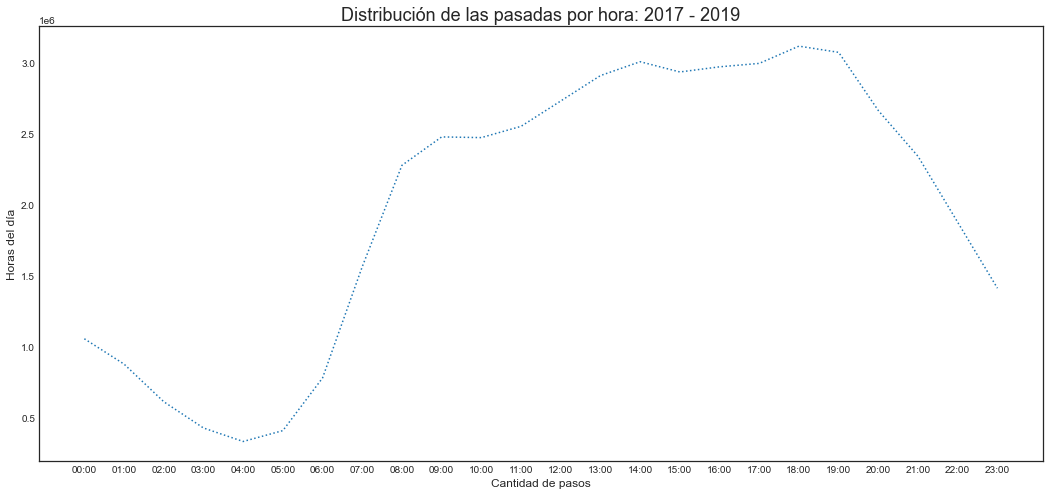

In [50]:
# Analizar la distribución de pasadas por hora:

plt.figure(figsize = (18,8))

by_time = dataset.cantidad_pasos.groupby(dataset.index.time).sum()
# Graficamos el intervalo de horas, sin tomar la hora 24 ya que se inicia en la hora cero la cuenta:
hourly_ticks = 1 * 60 * 60 * np.arange(24)
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-'])
plt.title ("Distribución de las pasadas por hora: 2017 - 2019", fontsize = 18);
plt.xlabel("Cantidad de pasos", fontsize = 12)
plt.ylabel("Horas del día", fontsize = 12)
plt.show()

* El pico de pasadas se presenta a la hora 19:00, seguido de las 14:00 hs. El valle (menor cantidad de pasadas) se da a las 04:00 hs.

In [51]:
# crear una columna que contenga los años a partir de la columna date
dataset['Año']=dataset.index.year

##### Comparar las pasadas por hora según año para verificar si existen diferencias

In [52]:
# Separamos los datasets por año
df_2019 = dataset[dataset.Año.isin(["2019"])]
df_2018 = dataset[dataset.Año.isin(["2018"])]
df_2017 = dataset[dataset.Año.isin(["2017"])]


In [53]:
# Graficar la cantidad de pasadas por hora - separada por año:

by_time_2017 = df_2017.cantidad_pasos.groupby(df_2017.index.time).sum()
by_time_2018 = df_2018.cantidad_pasos.groupby(df_2018.index.time).sum()
by_time_2019 = df_2019.cantidad_pasos.groupby(df_2019.index.time).sum()


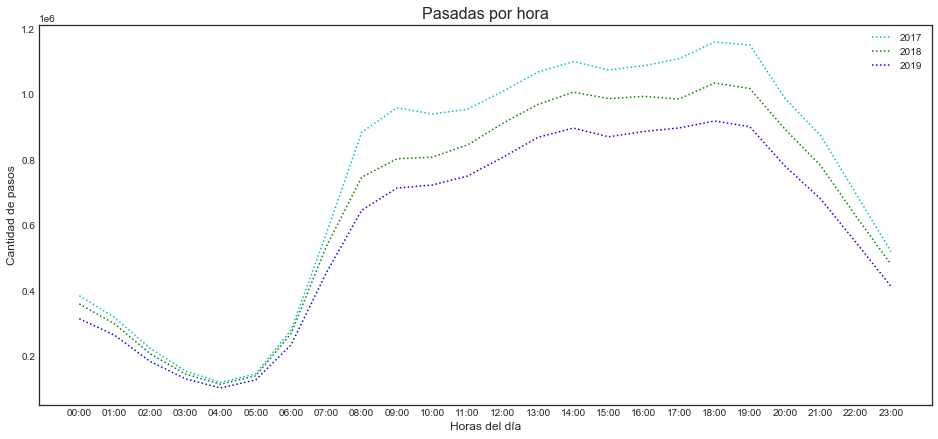

In [54]:
# Graficamos el intervalo de horas, sin tomar la hora 24 ya que se inicia en la hora cero la cuenta:
hourly_ticks = 1 * 60 * 60 * np.arange(24)

plt.figure(figsize = (16,7))
by_time_2017.plot(xticks=hourly_ticks, style=[':', '--', '-'], color = "c", label = "2017")
by_time_2018.plot(xticks=hourly_ticks, style=[':', '--', '-'], color = "g", label = "2018")
by_time_2019.plot(xticks=hourly_ticks, style=[':', '--', '-'], color = "b", label = "2019")


plt.title ("Pasadas por hora" , fontsize = 16);
plt.xlabel("Horas del día", fontsize = 12)
plt.ylabel("Cantidad de pasos", fontsize = 12)
plt.legend()
plt.show();

* La cantidad de pasadas fue disminuyendo de los años 2017 a 2019, siguiendo el mismo comportamiento en todos los casos.
* La disminución entre 2017 y 2018, 2018 y 2019 fue de similar magnitud, siendo levemente mayor entre los primeros dos años.

In [55]:
# Graficar la cantidad de pasadas por día del mes - separada por año:

by_time_2017_d = df_2017.cantidad_pasos.groupby(df_2017.index.day).sum()
by_time_2018_d = df_2018.cantidad_pasos.groupby(df_2018.index.day).sum()
by_time_2019_d = df_2019.cantidad_pasos.groupby(df_2019.index.day).sum()



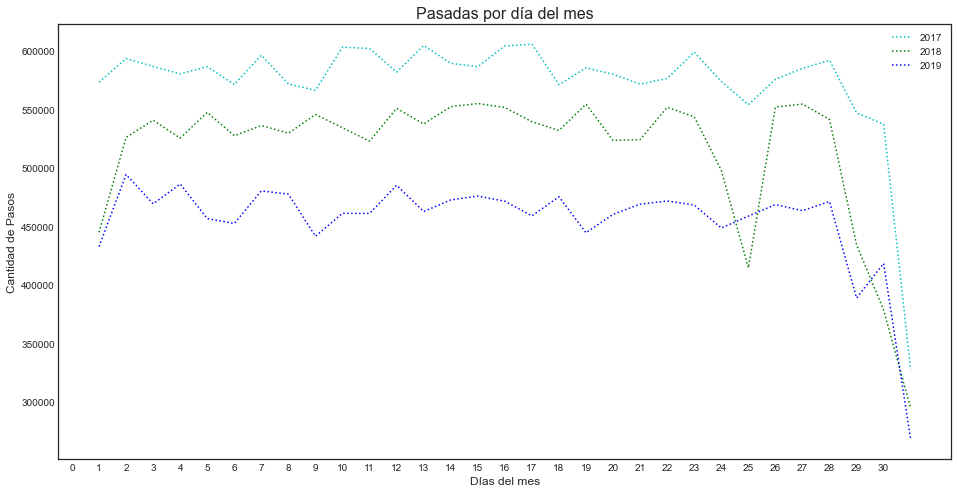

In [56]:
# Graficamos el intervalo de días del mes

plt.figure(figsize = (16,8))
by_time_2017_d.plot(style=[':', '--', '-'], color = "c",label = "2017")
by_time_2018_d.plot(style=[':', '--', '-'], color = "g", label = "2018")
by_time_2019_d.plot(style=[':', '--', '-'], color = "b", label = "2019")


plt.title ("Pasadas por día del mes",fontsize = 16 );
plt.xlabel("Días del mes", fontsize = 12)
plt.legend()
x_ticks = np.arange(0, 31, 1)
plt.xticks(x_ticks)
plt.ylabel("Cantidad de Pasos", fontsize = 12);

* El comportamiento de la serie en los tres años respecto al comportamiento estacional a lo largo de los días del mes es el mismo, salvo en el año 2018 donde se presenta una baja superior al resto de los años en el día 25.

In [57]:
by_time_2017_w = df_2017.cantidad_pasos.groupby(df_2017.index.week).sum()
by_time_2018_w = df_2018.cantidad_pasos.groupby(df_2018.index.week).sum()
by_time_2019_w = df_2019.cantidad_pasos.groupby(df_2019.index.week).sum()

C:\Users\Virginia\Anaconda3\envs\timeseries\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """Entry point for launching an IPython kernel.
C:\Users\Virginia\Anaconda3\envs\timeseries\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  
C:\Users\Virginia\Anaconda3\envs\timeseries\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce th

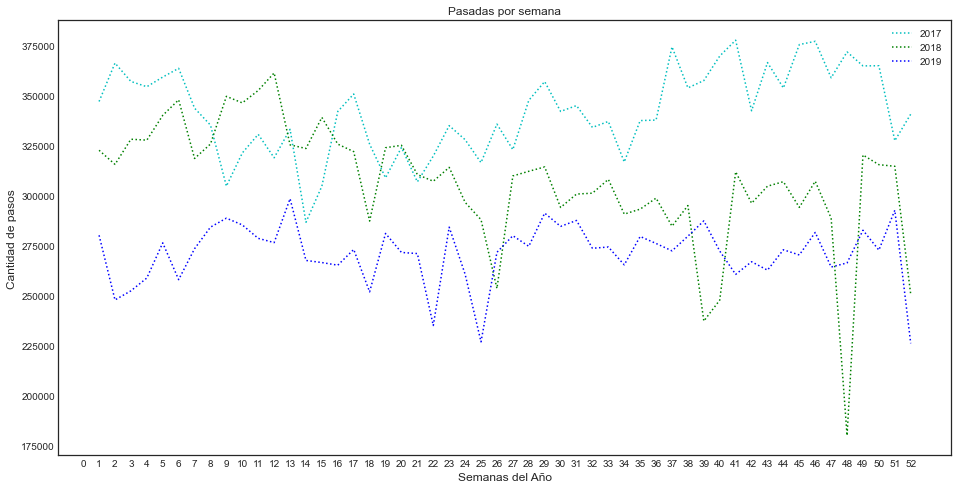

In [58]:
# Graficar la cantidad de pasadas por mes - separada por año:
plt.figure(figsize = (16,8))


by_time_2017_w.plot(style=[':', '--', '-'], color = "c", label = "2017")
by_time_2018_w.plot(style=[':', '--', '-'], color = "g", label = "2018")
by_time_2019_w.plot(style=[':', '--', '-'], color = "b", label = "2019")


plt.title ("Pasadas por semana", fontsize = 12)
x_ticks = np.arange(0, 53, 1)
plt.xticks(x_ticks)
plt.legend()
plt.xlabel("Semanas del Año", fontsize = 12)
plt.ylabel("Cantidad de pasos", fontsize = 12);

* En el año 2018, se observa una caída abrupta en la semana 48 del año  (primer semana de diciembre). Será necesario verificar con mayor detalle la causa de este comportamiento.
* A nivel estacional, la serie tiene comportamientos similares con un leve desplazamiento en el año 2019 respecto a 2018.


In [59]:
by_time_2017_m = df_2017.cantidad_pasos.groupby(df_2017.index.month).sum()
by_time_2018_m = df_2018.cantidad_pasos.groupby(df_2018.index.month).sum()
by_time_2019_m = df_2019.cantidad_pasos.groupby(df_2019.index.month).sum()

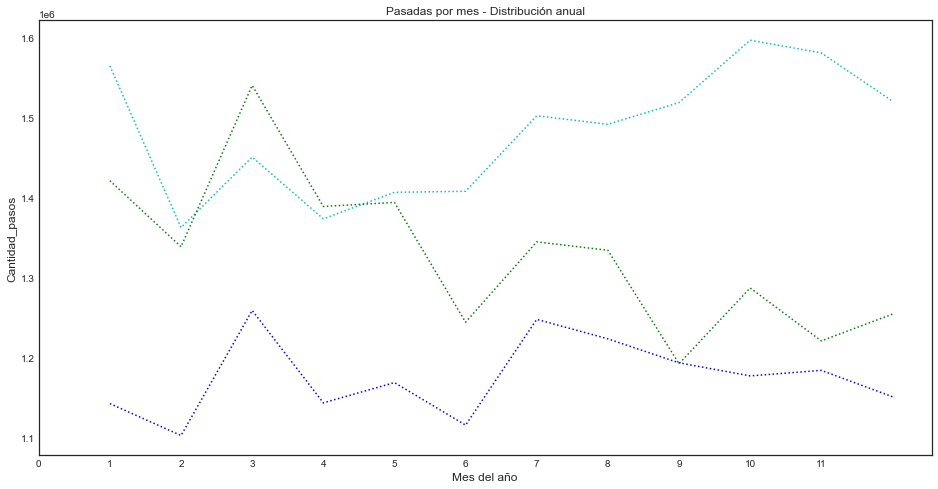

In [60]:
# Graficar la cantidad de pasadas por mes - separada por año:
plt.figure(figsize = (16,8))


by_time_2017_m.plot(style=[':', '--', '-'], color = "c", label = "2017")
by_time_2018_m.plot(style=[':', '--', '-'], color = "g", label = "2018")
by_time_2019_m.plot(style=[':', '--', '-'], color = "b", label = "2019")


plt.title ("Pasadas por mes - Distribución anual", fontsize = 12)
x_ticks = np.arange(0, 12, 1)
plt.xticks(x_ticks)
plt.xlabel("Mes del año", fontsize = 12)
plt.ylabel("Cantidad_pasos", fontsize = 12);

* Graficando la serie de manera mensual, se puede visualizar que el comportamiento año a año es muy disímil, desde el mes de junio en adelante, donde el año 2019 observa una tendencia decreciente desde ese mes en adelante.

* Para cada año, mes a mes, se observa que el comportamiento estacional de la serie es similar, salvo en el año 2019, donde la estacionalidad desde el mes 7 en adelante casi no se presenta, si no que se observa un fenómeno de tendencia decreciente.

In [61]:
# Verificar el comportamiento diario el último trimestre de cada año

trim_diciembre_2017 = diario['2017-10-01':'2017-12-31']

trim_diciembre_2018 = diario['2018-10-01':'2018-12-31']

trim_diciembre_2019 = diario['2019-11-01':'2019-12-31']

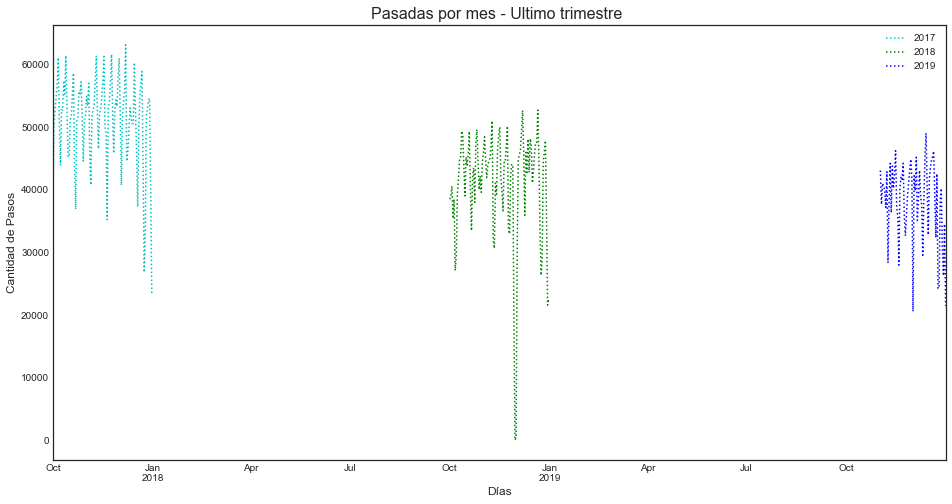

In [62]:
# Graficando el comparativo de la distribución

plt.figure(figsize = (16,8))

plt.title ("Pasadas por mes - Ultimo trimestre ", fontsize = 16);

trim_diciembre_2017 ['cantidad_pasos'].plot(style=[':', '--', '-'], color = "c", label = "2017")
trim_diciembre_2018 ['cantidad_pasos'].plot(style=[':', '--', '-'],color = "g", label = "2018")
trim_diciembre_2019 ['cantidad_pasos'].plot(style=[':', '--', '-'],color = "b", label = "2019")
plt.legend()
plt.xlabel("Días", fontsize = 12)
plt.ylabel("Cantidad de Pasos", fontsize = 12);

* La gráfica permite analizar que la serie presenta una descenso en la cantidad de pasos de 2017 al 2018, y que entre 2018 y 2019 es menor. 
* La comparación de trimestres permite observar un comportamiento similar entre años.
* En el año 2018 para los últimos días de Noviembre - incios de Diciembre se observa una baja abrupta en el la cantidad de pasos, por lo que se procederá a llevar a cabo un filtrado de los valores para compararlos.


In [63]:
#Revisamos el intervalo particular de 2017:


diario["2017-11-28":"2017-12-02"]

cantidad_pasos
fecha                     
2017-11-28           54324
2017-11-29           53314
2017-11-30           57955
2017-12-01           60985
2017-12-02           52153

In [64]:
#Revisamos el intervalo particular de 2018:

diario["2018-11-28":"2018-12-02"]

cantidad_pasos
fecha                     
2018-11-28           43724
2018-11-29           19728
2018-11-30               0
2018-12-01             350
2018-12-02           30075

In [65]:
#Revisamos el intervalo particular de 2019:

diario["2019-11-28":"2019-12-02"]

cantidad_pasos
fecha                     
2019-11-28           43130
2019-11-29           44841
2019-11-30           41722
2019-12-01           20553
2019-12-02           42215

* Se puede concluir que en el año 2018, se presentan una anomalía con un descenso de los datos superior al 50% el 29 de noviembre, mientras que el 30 no presenta datos y 1ro de diciembre son casi nulos.
* En el año 2019, el 1ro de diciembre el volumen de pasos se reduce a la mitad

Será necesario trabajar sobre las anomalías antes de efectuar las predicciones (por ejemplo con la técnica de interpolado de datos)

### Conclusiones el análisis de la variable de acuerdo a distintos intervalos de tiempo:

* La serie presenta un comportamiento que puede ser explicado de manera diaria y semanal, mientras que a nivel mensual y anual presenta variaciones significativas entre un mes y otro.
Esto significa que para llevar a cabo las predicciones, se obtendrían mejores resultados llevandolas a cabo a nivel diario o semanal.

### Análisis descriptivo de la variable

In [66]:
# Tomamos la variable almacenada con los datos diarios
diario.describe()

cantidad_pasos
count     1095.000000
mean     43712.859361
std       8192.736927
min          0.000000
25%      39061.500000
50%      43761.000000
75%      49498.000000
max      63127.000000

* Se presentan datos con un mínimo de cero, por lo que para alguna de las fechas existen valores sin registros.
* La media y la mediana no presentan una gran variación, por lo que la distribución no presenta un alto sesgo en el período de 3 años.

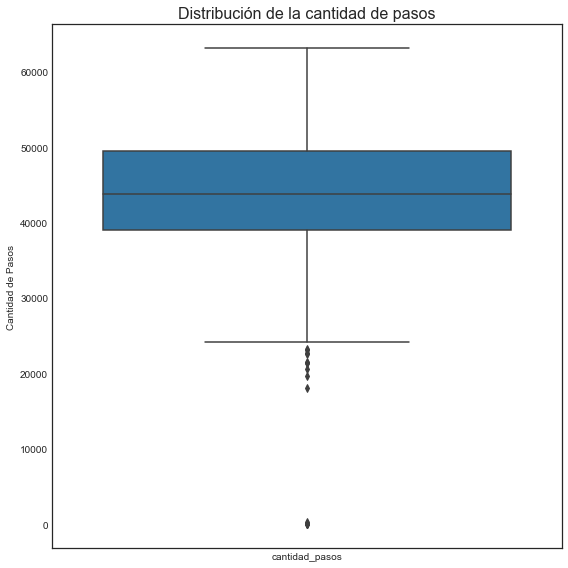

In [67]:
#Graficar el Boxplot de la cantidad de pasos

plt.figure(figsize = (8,8))
sns.boxplot(data = diario)
plt.title("Distribución de la cantidad de pasos",fontsize = 16)
#plt.xlabel("Tipo de propiedad")
plt.ylabel("Cantidad de Pasos")
#plt.xticks(rotation=90) 


plt.tight_layout()
plt.show()

In [68]:
# Almacenamos en una variable la cantiad de pasos = 0 , para estudiar si se trata de datos faltantes rellenados con este número:

valores_nulos = diario.loc[diario.cantidad_pasos == 0]
valores_nulos.count()

cantidad_pasos    4
dtype: int64

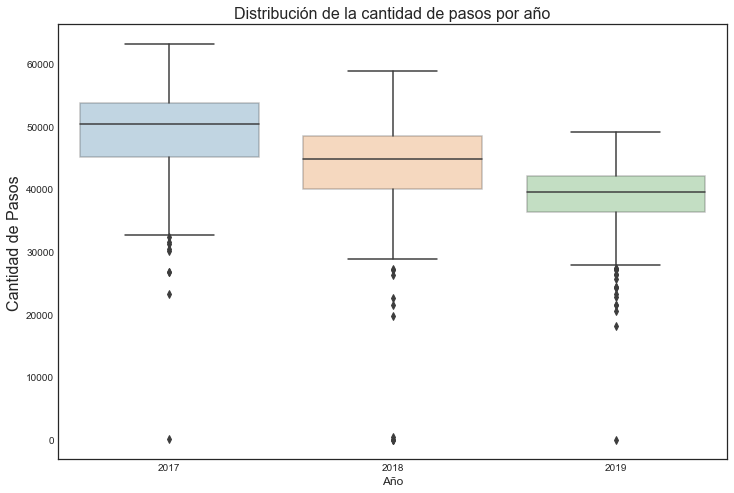

In [69]:
# Graficamos la distribuión por año para verificar a mayor detalle los valores mínimos y máximos
fig, ax = plt.subplots(figsize = (12,8))
sns.boxplot(data=diario, x=diario.index.year, y = 'cantidad_pasos',  ax = ax, boxprops=dict(alpha=.3));
plt.title ("Distribución de la cantidad de pasos por año", fontsize = 16)
plt.ylabel("Cantidad de Pasos", fontsize = 16)
plt.xlabel("Año" , fontsize = 12)
plt.show();


* Se observa que la serie con el paso de tiempo concentra sus datos alrededor de la media en mayor medida, permaneciendo valores atípicos respecto a los valores inferiores, por lo que volvemos a graficar la serie para checkear si es necesario reemplazarlos.

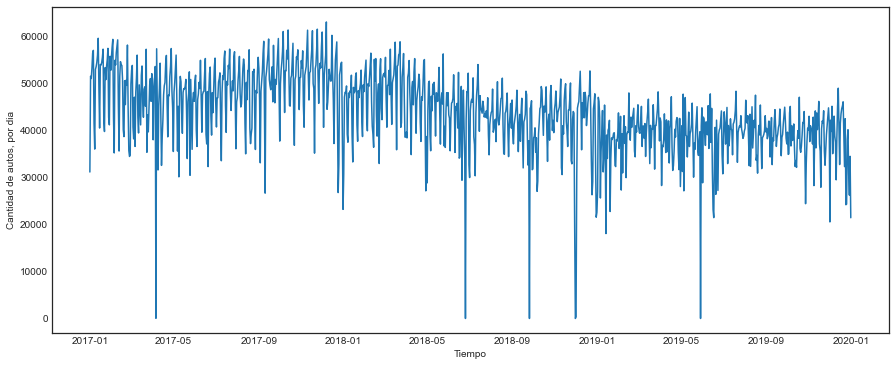

In [70]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

* Cíclicamente, la serie en los meses de enero presenta un descenso abrupto en la cantidad de pasos que puede afectar las predicciones del resto de los meses. Por lo que se llevará a cabo un zoom de estos datos.

In [71]:
enero_2017 = diario["2017-01-01":"2017-01-31"]
enero_2017.describe ()

cantidad_pasos
count       31.000000
mean     50492.258065
std       7218.723631
min      31183.000000
25%      45922.500000
50%      53409.000000
75%      55326.500000
max      59651.000000

In [72]:
enero_2018 = diario["2018-01-01":"2018-01-31"]
enero_2018.describe ()

cantidad_pasos
count       31.000000
mean     45860.225806
std       5803.078354
min      30735.000000
25%      41557.500000
50%      48162.000000
75%      49353.000000
max      52881.000000

In [73]:
enero_2019 = diario["2019-01-01":"2019-01-31"]
enero_2019.describe ()

cantidad_pasos
count       31.000000
mean     36871.709677
std       6753.766501
min      18076.000000
25%      34021.000000
50%      38456.000000
75%      40277.500000
max      47080.000000

* Como el año 2019 es el que presenta una media menor y una distribución más concentrada de los datos, se puede verificar que es posible interpolar los datos inferiores a estos valores.


In [74]:
# convertimos los valores <= 18076 a NaN
diario.cantidad_pasos[diario.cantidad_pasos <= 18076] = np.nan

In [75]:
valores_nulos_check = diario.loc[diario.cantidad_pasos == 0]
valores_nulos_check.count()

cantidad_pasos    0
dtype: int64

In [76]:
# Efectuamos un interpolado de los datos:

# Interpolado de datos: para los valores NaN reemplazarlos por una interpolación según la distribución de la serie
diario = diario.interpolate()

In [77]:
# Verificamos nuevamente los valores estadísticos
diario.describe()

cantidad_pasos
count     1095.000000
mean     43935.655251
std       7542.142258
min      19728.000000
25%      39107.500000
50%      43766.000000
75%      49514.500000
max      63127.000000

* Como los valores reemplazados son pocos, no se producen cambios siginifcativos en la media de cantidad de pasos, mientras que los valores mínimos pasan a ser 1800 pasos, cual todavía se encuentran muy lejanos a la media.


## Análisis de anomalías

El análisis de anomalías en una serie de tiempo, permitirá de alguna manera prever la capacidad de predicción de la serie su  grado de error.
Una serie con mucho ruido, puede requerir transformaciones adicionales con el objetivo de suavizarla y mejorar los resultados de la predicción.

En este caso:

* Se analizó la serie a través de las medias móviles en busca de detectar las anomalías que pueda haber presente y que no hayan sido capturadas mediante el método anterior. Este método también se utiliza como un método de predicción, que determina que la próxima observación es equivalente a la media de las observaciones del pasado.

* Tener en cuenta que al elegir la ventana de tiempo, cuanto más larga sea la ventana, más suave será la tendencia (ya que calcula los promedios móviles en función de mayor cantidad de datos). 
* A continuación se muestra un ejemplo de media móvil con una ventana de 7 días.


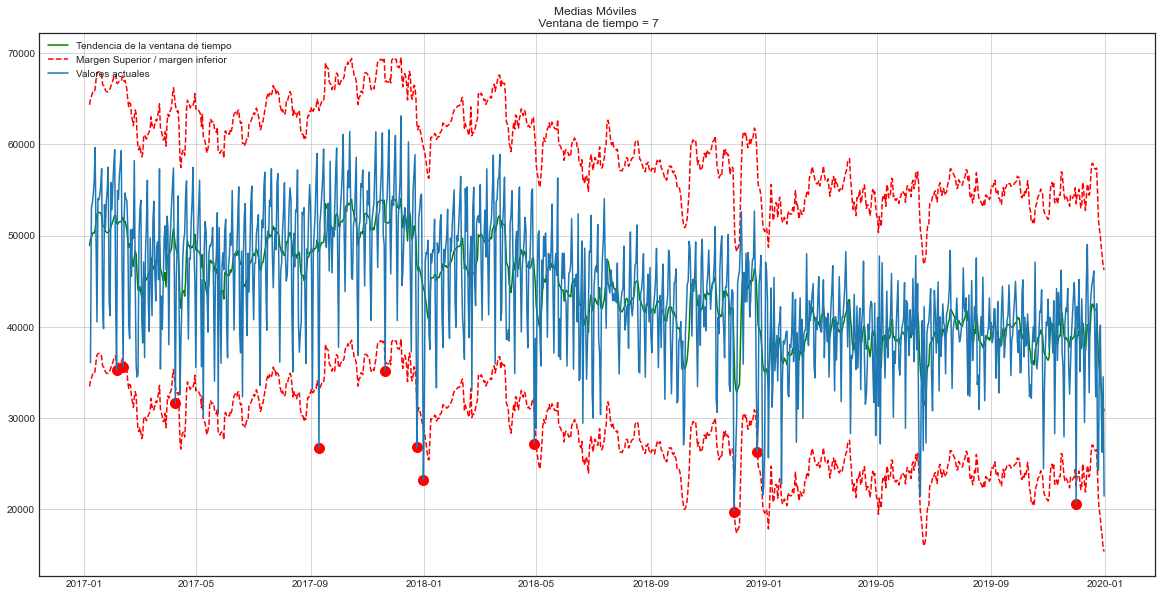

In [78]:
# Elegimos una ventana de tiempo semanal, ya que se observa que es la que mejor captura el comportamiento de la serie
plotMovingAverage(diario, 7, plot_intervals=True, plot_anomalies=True)

Al verificar de esta manera la serie, se detecta que existen puntos extremos que pueden afectar la variabilidad de las predicciones. Los valores anormales se dan en los meses que la serie asume comportamientos estacionales, cuales son enero, septiembre.

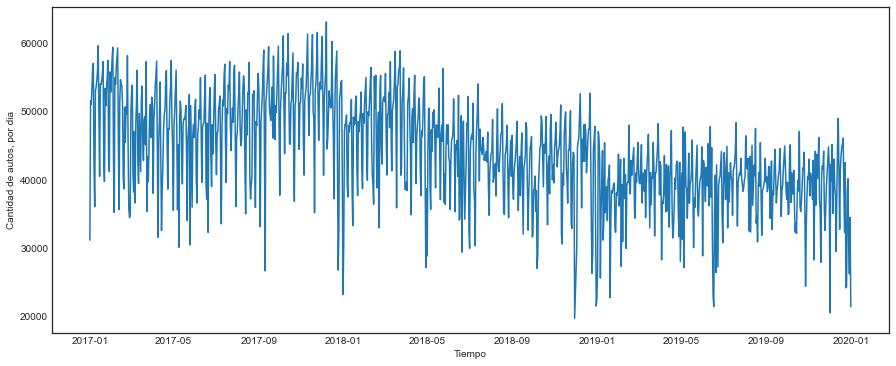

In [79]:
# Graficamos nuevamente la serie interpolada
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

* De esta manera, la serie tiene un comportamiento más armónico y que continúa capturando la estacionalidad de los meses especiales. 

### Aditiva o multiplicativa?
* $ Series Aditivas$ : su comportamiento no varía en frecuencia y amplitud en el tiempo.
y(t) = Nivel de la serie + Tendencia + Estacionalidad + Ruido

* $ Series multiplicativas $: el comportamiento de la serie crece o decrece con el tiempo, tanto en su frecuencia como amplitud.
y(t) = Level * Tendencia * Estacionalidad * Ruido

In [80]:
año_2017 = diario['2017-01-01':'2017-12-31']

año_2018 = diario['2018-01-01':'2018-12-31']

año_2019 = diario['2019-01-01':'2019-12-31']


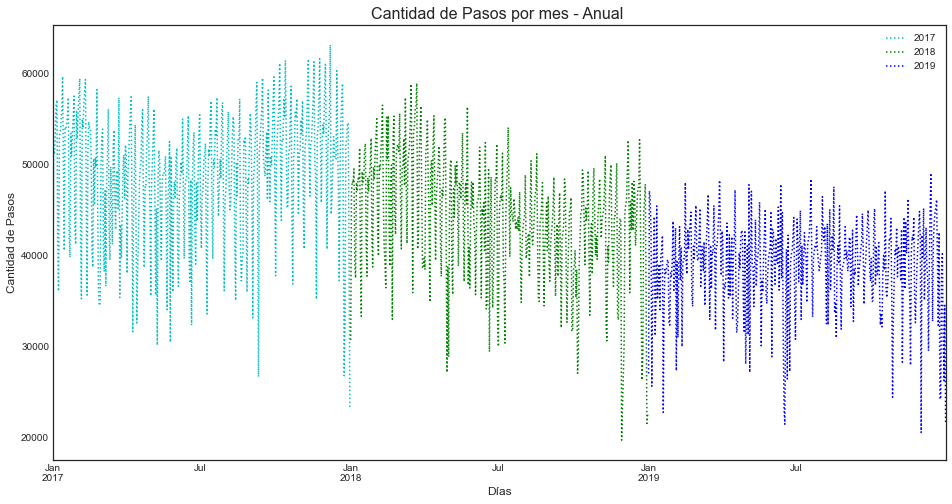

In [81]:
# Graficando el comparativo de la distribución

plt.figure(figsize = (16,8))

plt.title ("Cantidad de Pasos por mes - Anual ", fontsize = 16);

año_2017 ['cantidad_pasos'].plot(style=[':', '--', '-'], color = "c", label = "2017")
año_2018 ['cantidad_pasos'].plot(style=[':', '--', '-'],color = "g", label = "2018")
año_2019 ['cantidad_pasos'].plot(style=[':', '--', '-'],color = "b", label = "2019")
plt.legend()
plt.xlabel("Días", fontsize = 12)
plt.ylabel("Cantidad de Pasos", fontsize = 12);

* Los años 2017 y 2018 parecen tener un comportamiento más multiplicativo, mientras que el año 2019 un comportamiento aditivo. 

### Conclusión del análisis descriptivo de la serie:

* A nivel de comportamiento diario, la serie presenta un comportamiento de reducción de la variabilidad de la cantidad de pasos a lo largo del tiempo, donde 2019 presenta valores cercanos a la media y valores extremos fuera de la variable.
* La serie presenta un comportamiento decreciente en 2018 que en 2019 no se observa, si no que este último tiene un comportamiento que se encuentra más alrededor de su media.
* La serie gráficamente y en general, parece presentar un comportamiento aditivo.

##  Análisis de Componentes de la serie

In [82]:
# Recuperamos el dataset creado con valores diarios interpolados

diario.head()

cantidad_pasos
fecha                     
2017-01-01         31183.0
2017-01-02         51568.0
2017-01-03         51093.0
2017-01-04         53332.0
2017-01-05         56486.0

### Analizar el factor de tendencia en la serie:
La tendencia de la serie es el componente que verificar si la serie tiene o no variación a lo largo del tiempo 

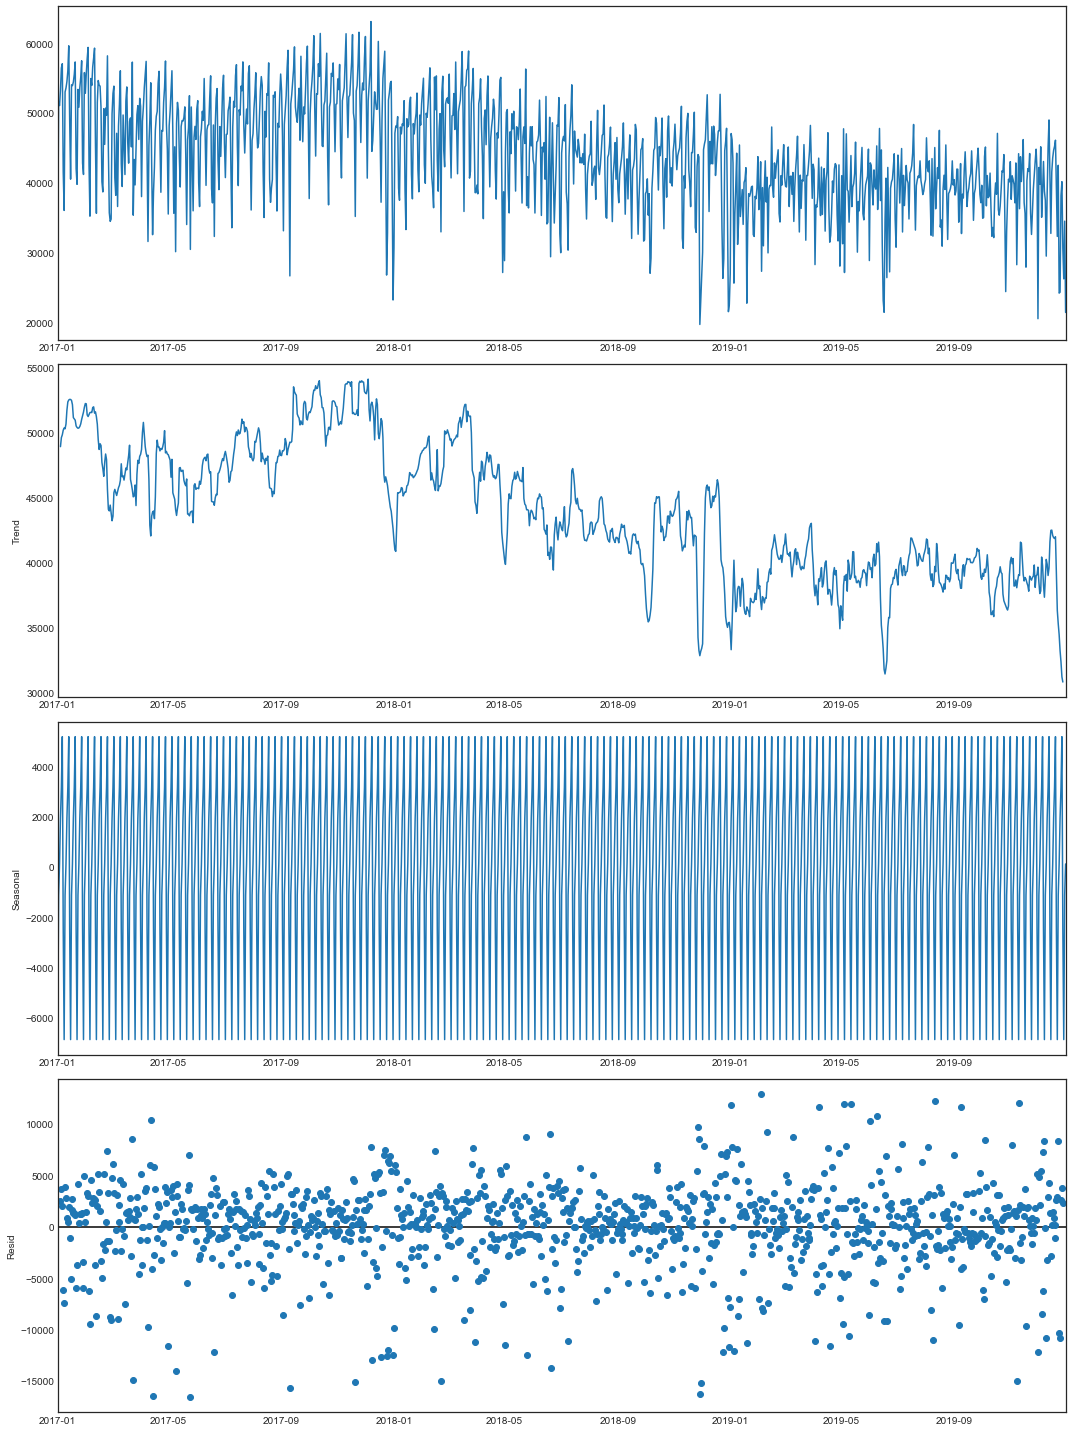

In [83]:
# Descomponemos la serie con el método aditivo
#from pylab import rcParams
rcParams['figure.figsize'] = 15, 20
decomposition_d = sm.tsa.seasonal_decompose(diario, model='additive')  
fig = decomposition_d.plot()
plt.show()

* Se puede observar que la serie presenta durante 2018 una tendencia decreciente no lineal, mientras que en los años 2017 y 2019 no se presentan componentes de tendencia.
* Los patrones de estacionalidad son consistentes a lo largo de los tres años.
* Los residuos se distribuyen aleatoriamente, aunque en los años 2017 y 2018 se puede verificar algún algún grado de homogeneidad.

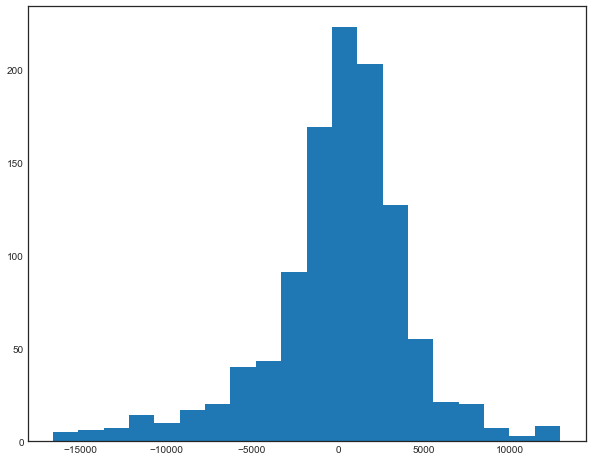

In [84]:
#Histograma de los residuos

plt.figure(figsize = (10,8))
plt.hist(decomposition_d.resid, bins = 20)
plt.show()

* Los residuos presentan un leve sesgo a la derecha, verificando el componente de tendencia que se observa en las gráficas por fechas durante 2018

## Estacionariedad de la serie

Una serie es estrictamente estacionaria si sus propiedades no son afectadas por los cambios a lo largo del tiempo. 
Para que una serie sea considerada estacionaria, debe cumplir tres criterios básicos:

1) Media constante a lo largo del tiempo (media móvil: Rolling mean)
2) Varianza constante a lo largo del tiempo (varianza móvil: rolling std)
3) Covarianza constante a lo largo del tiempo (solo depende de la distancia temporal entre los datos)


## Investigación: 
Se llevará a cabo pruebas respecto a la estacionariedad de la serie a través de modelos estadísticos/econométricos, con el objetivo de comprender si las predicciones a llevar a cabo tendrán buena capacidad de predicción o presentarán errores.

#### Verificar si la media y la varianzas son constantes

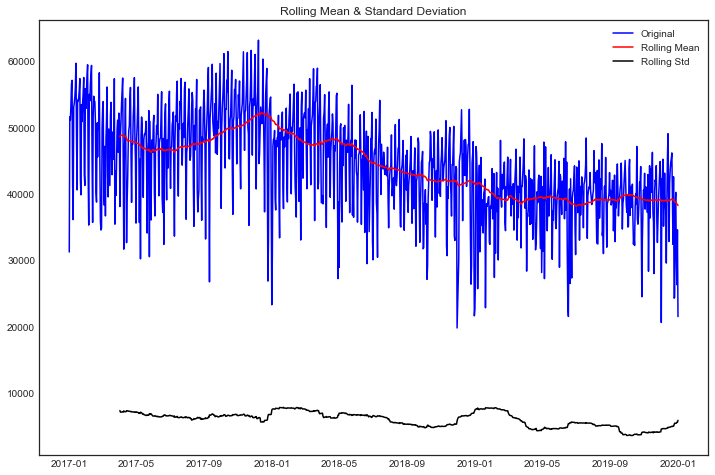

Results of Dickey-Fuller Test:
Test Statistic                   -1.730449
p-value                           0.415496
#Lags Used                       20.000000
Number of Observations Used    1074.000000
Critical Value (1%)              -3.436453
Critical Value (5%)              -2.864235
Critical Value (10%)             -2.568205
dtype: float64
La media es: 43935.66
La desviación estándar es: 7542.14


In [85]:
# Efectuar el test de estacionariedad de la serie con un retardo de 2 días
# Tomamos la ventana de tiempo de un trimestre (tiempo a predecir)
n = 92
test_stationarity (diario, n)
print("La media es:", diario ["cantidad_pasos"].mean().round (2))
print("La desviación estándar es:", diario["cantidad_pasos"].std().round(2))

A través de la gráfica de la varianza podemos verificar que la misma presenta un leve decrecimiento en el tiempo.
A su vez, la media presenta una leve tendencia decreciente en 2018.
* El valor del test superior a los valores críticos  siginifica que se falla al rechazar la hipótesis nula y que la estacionalidad no es constante a lo largo del tiempo (la serie no es estacionaria).

In [86]:
# Como la serie es estacionaria, vamos a analizar el intervalo de tiempo (Rho) en el cual se convierte en estacionaria

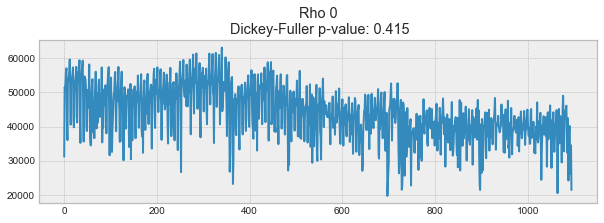

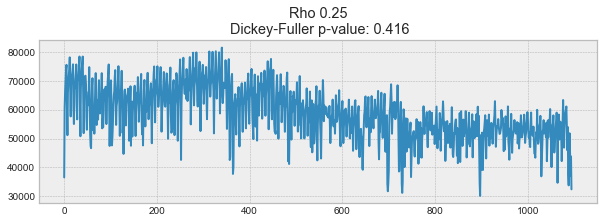

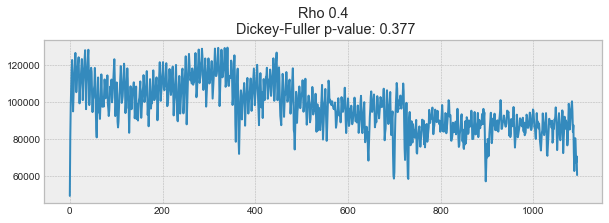

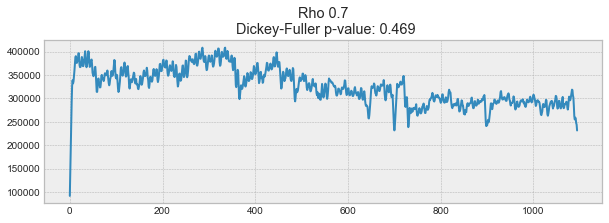

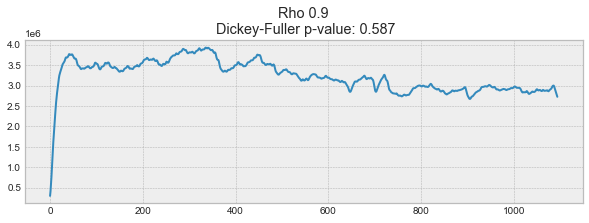

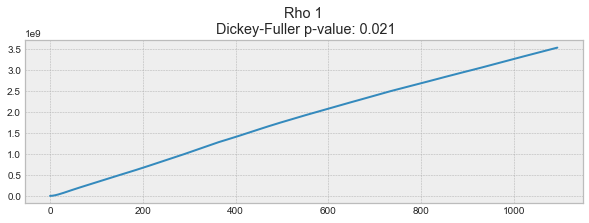

In [87]:
# Creamos una copia del dataset para manipular los datos de acuerdo a la funciones definidas
# El objetivo es observar como la serie va "convirtiendose" a valores lineales a medida que se modifica el ratio Rho

x = diario.copy()

for rho in [0, 0.25, 0.4, 0.7, 0.9, 1]:
    plotProcess(x.cantidad_pasos.values,rho=rho)

* Las gráficas permiten observar que durante todos los ratios la serie no alcanza la estacionariedad, por lo que podrían obtenerse mejores predicciones llevando a cabo un análisis de la serie probando tomar distintos valores de rezagos al momento de la predicción, diferenciandola o probando predicciones tomando otra unidad de tiempo (ejemplo: semanal, mensual).

#### Análisis de autocorrelación: 

Nos permite comprender patrones de relación en los datos para un período de tiempo determinado.
Es necesario llevar a cabo este tipo de análisis cuando la serie presenta períodos estacionales como los observados a través de las gráficas anteriores.

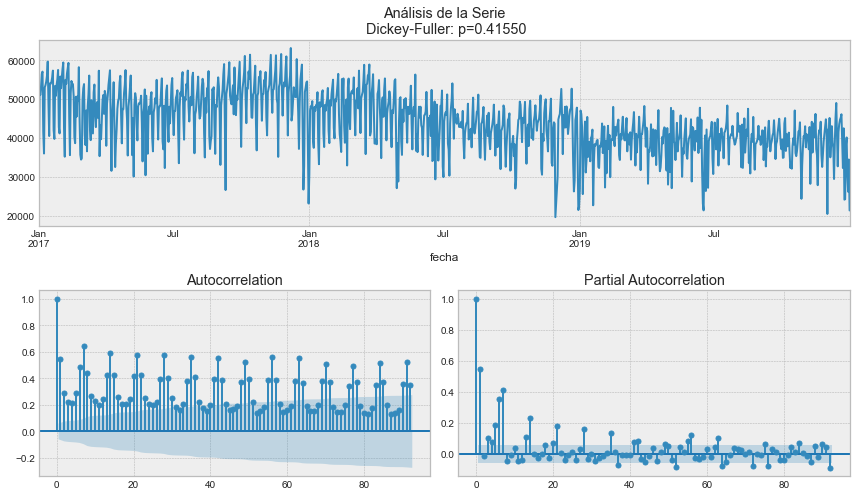

In [88]:
# Analizar la autocorrelación de la variable para comprender el detalle del comportamiento con un retardo de un trimestre
tsplot(diario.cantidad_pasos, lags=92)

* Tomando 92 días de retardo, la serie presenta un autocorrelación cíclica que se repite cada 7 períodos (estacionalidad), lo que significa que presenta patrones donde los datos se relacionan por día de la semana. La autocorrelación parcial alcanza valores negativos al tercer período y pareciera tender a cero con el paso del tiempo.

* El gráfico de autocorrelación parcial (PACF) permite visualizar un componente autoregresivo en el modelo (AR) de grado 2, ya que es donde el primer valor ingresa en el intervalo de confianza.
* El gráfico de autocorrelación (ACF) permite visualizar un componente de medias móviles (MA) de 33, que es en el momento que la serie ingresa por primera vez dentro del intervao de confianza a nivel de autocorrelación.


In [89]:
# Test de LJung para comprobar lo analizado mediante los gráficos
ljung_p = np.mean(ljung(x=decomposition_d.resid.dropna())[1]).round(4)
print("Ljung Box, p value:",  ljung_p)

Ljung Box, p value: 0.0111


C:\Users\Virginia\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\stats\diagnostic.py:496: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)
C:\Users\Virginia\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


* Los residuos se encuentran correlacionados
* La graficas permitieron visualizar que la serie presenta un comportamiento cíclico que se repite cada 7 períodos, con valores significativos de autocorrelación, decreciendo pero no alcanzando valores de cero.
* La autocorrelación parcial, parece tender a cero a lo largo del tiempo.

## Continuación del análisis Exploratorio de datos 
Como la serie a nivel diario no es estacionaria, se llevarán a cabo distintas técnicas de prueba para verificar el modelo más óptimo para la predicción:
1. Diferenciación de la serie diaria: para verificar la cantidad de rezagos con la que la misma se vuelve estacionaria.
2. Resampleo de la serie a frecuencia semanal: como además de no ser estacionaria a nivel diario, la serie presenta ruido significativo.



### Diferenciación de la serie diaria:
A partir del análisis de correlación, se detectó que el comportamiento de la serie se repite en ciclos de 7 rezagos y que es estacionaria, por lo que se probará diferenciarla para ver a partir de cuántas diferenciaciones se convierte en estacionaria.

In [90]:
first_diff = diario.diff() #primera diferenciación
second_diff = diario.diff().diff() #segunda diferenciación

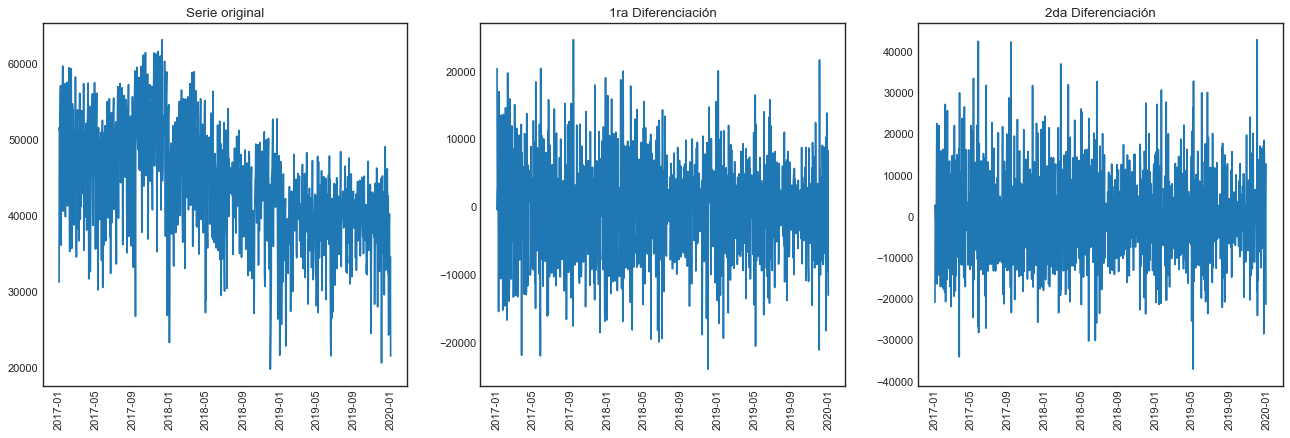

In [91]:
plt.rcParams.update({'figure.figsize':(20,6), 'figure.dpi':80})

# Serie Original
fig, axes = plt.subplots(1, 3, sharex=True)
axes[0].plot(diario) 
axes[0].set_title('Serie original')

# Primera Diferenciación
axes[1].plot(first_diff.dropna())
axes[1].set_title('1ra Diferenciación')

# Segunda Diferenciación
axes[2].plot(second_diff.dropna())
axes[2].set_title('2da Diferenciación')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.show()

* Las gráficas comparativas permiten observar como a través de la diferenciación se reduce el componente estacional de la serie, quedando centrado en su media.

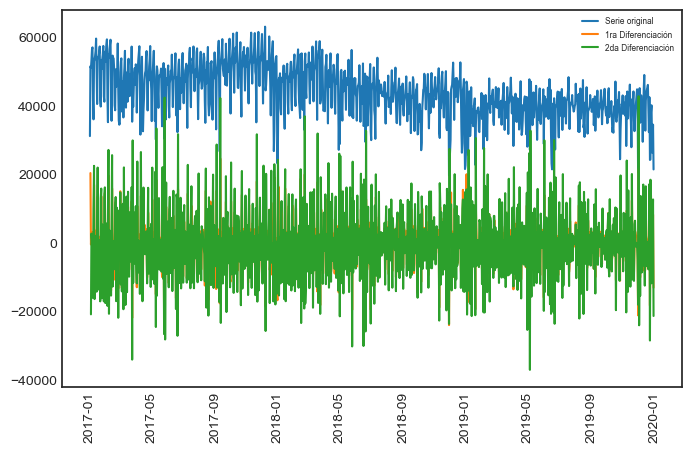

In [92]:

# Graficamos las tres series juntas para compararlas

fig, axes = plt.subplots(1, 1, figsize=(8,5), dpi=100, sharex=True)

axes.plot(diario, label='Serie original')
axes.plot(first_diff, label='1ra Diferenciación')
axes.plot(second_diff, label='2da Diferenciación')
axes.legend(loc='upper right', fontsize=6)
plt.xticks(rotation=90)

plt.show()

* Se puede observar como no se observan diferencias significativas en la serie luego de la primer y segunda diferenciación, mientras si lo ocurre entre la serie sin diferencias y diferenciada.
* La serie con dos diferenciaciones al centrarse más alrededor de la media, los valores con mayor varianza se destacan con mayor facilidad.

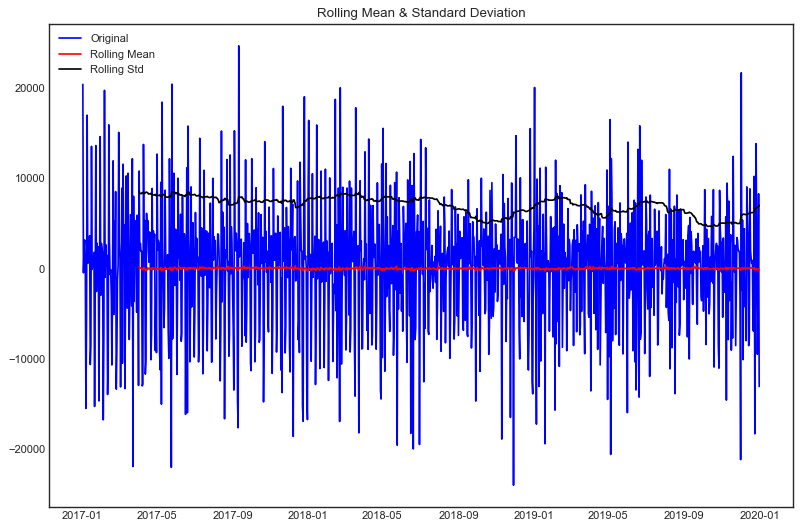

Results of Dickey-Fuller Test:
Test Statistic                -1.271377e+01
p-value                        1.016841e-23
#Lags Used                     1.900000e+01
Number of Observations Used    1.074000e+03
Critical Value (1%)           -3.436453e+00
Critical Value (5%)           -2.864235e+00
Critical Value (10%)          -2.568205e+00
dtype: float64


In [93]:
# Efectuar el test de estacionariedad de la serie con un retardo de 2 días
# Tomamos la ventana de tiempo de un trimestre (tiempo a predecir)
n = 92
test_stationarity (first_diff.dropna(), n)

Luego de la transformación, la serie se conviente en estacionaria, con una media dentrada en cero y una varianza con menor amplitud.
A su vez, los resultados del test son inferiores a los valores críticos con un nivel de confianza del 1%.

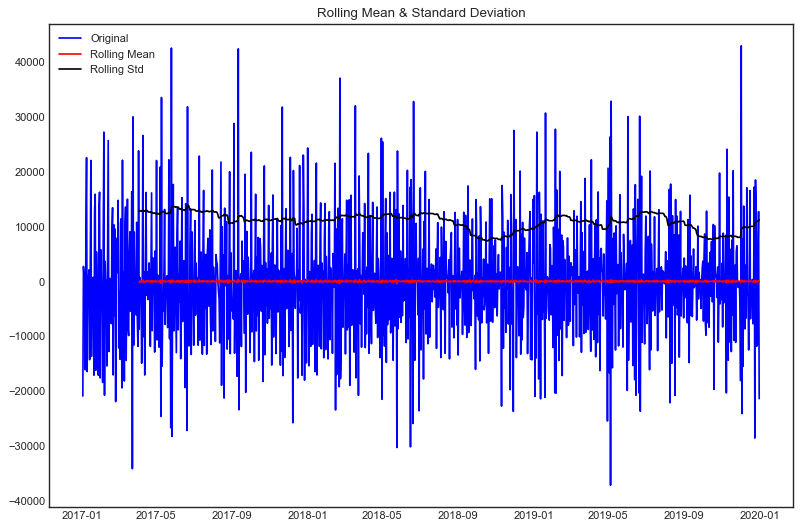

Results of Dickey-Fuller Test:
Test Statistic                -1.489483e+01
p-value                        1.537912e-27
#Lags Used                     2.200000e+01
Number of Observations Used    1.070000e+03
Critical Value (1%)           -3.436476e+00
Critical Value (5%)           -2.864245e+00
Critical Value (10%)          -2.568210e+00
dtype: float64


In [94]:
# Efectuar el test de estacionariedad de la serie con un retardo de 2 días
# Tomamos la ventana de tiempo de un trimestre (tiempo a predecir)
n = 92
test_stationarity (second_diff.dropna(), n)

Luego de la transformación, la serie se conviente en estacionaria, con una media dentrada en cero y una varianza con menor amplitud.
A su vez, los resultados del test son inferiores a los valores críticos con un nivel de confianza del 1%.

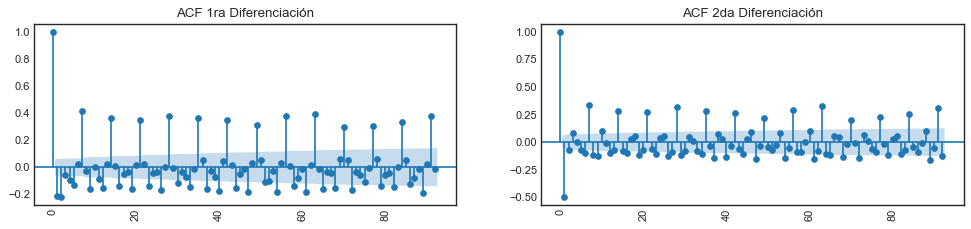

In [95]:

# Verificamos el comportamiento de la autocorrelación en las series diferenciadas con el objetivo de verificar si es posible eliminar la estacionalidad
plt.rcParams.update({'figure.figsize':(15,3), 'figure.dpi':80})

fig, axes = plt.subplots(1, 2, sharex=True)
# Graficamos la autocorrelación luego de la primer diferenciación
plot_acf(first_diff.dropna(),lags=92,ax=axes[0], title='ACF 1ra Diferenciación')

# Graficamos la autocorrelación luego de la segunda diferenciación
plot_acf(second_diff.dropna(), lags=92,ax=axes[1] , title='ACF 2da Diferenciación')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.subplots_adjust(hspace = 0.5)
plt.show()

* La serie luego de la segunda diferenciación alcanza valores dentro del intervalo de confianza en el segundo retardo, mientras que diferenciada en un período lo alcanza al tercer retardo.
En ambos casos todavía se observa un comportamiento estacional de 7 días.

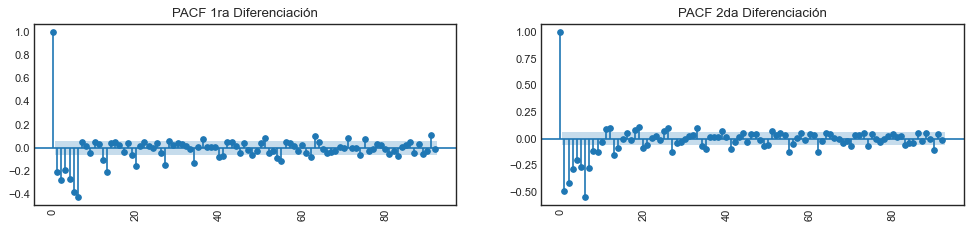

In [96]:
# Verificamos el comportamiento de la autocorrelación parcial  en las series diferenciadas:
plt.rcParams.update({'figure.figsize':(15,3), 'figure.dpi':80})

fig, axes = plt.subplots(1, 2, sharex=True)

# Graficamos la autocorrelación parcial luego de la primer diferenciación
plot_pacf(first_diff.dropna(),lags=92,ax=axes[0], title='PACF 1ra Diferenciación')


# Graficamos la autocorrelación parcial luego de la segunda diferenciación
plot_pacf(second_diff.dropna(), lags=92,ax=axes[1] , title='PACF 2da Diferenciación')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.subplots_adjust(hspace = 0.5)
plt.show()

* Con la serie diferenciada a nivel de 1, la misma asume valores dentro del intervalo de confianza luego del período 7, mientras que con una diferenciación de 2 no se observa que la serie alcance valores dentro del intervalo de confianza para los primeros 8 retardos.
Como se observa que la serie a nivel de autocorrelación parcial, asume valores dentro del intervalo de confianza luego del 7mo retardo, se llevará a cabo la diferenciación tomando 7 rezagos.
* La serie todavía captura el componente estacional.

In [97]:
# Diferenciar la serie por el período de 7 días, que es el valor del componente estacional
diario_diff = diario.cantidad_pasos.diff(7)
diario_diff

fecha
2017-01-01       NaN
2017-01-02       NaN
2017-01-03       NaN
2017-01-04       NaN
2017-01-05       NaN
               ...  
2019-12-27   -5946.0
2019-12-28   -8622.0
2019-12-29   -6078.0
2019-12-30   -8008.0
2019-12-31   -2773.0
Freq: D, Name: cantidad_pasos, Length: 1095, dtype: float64

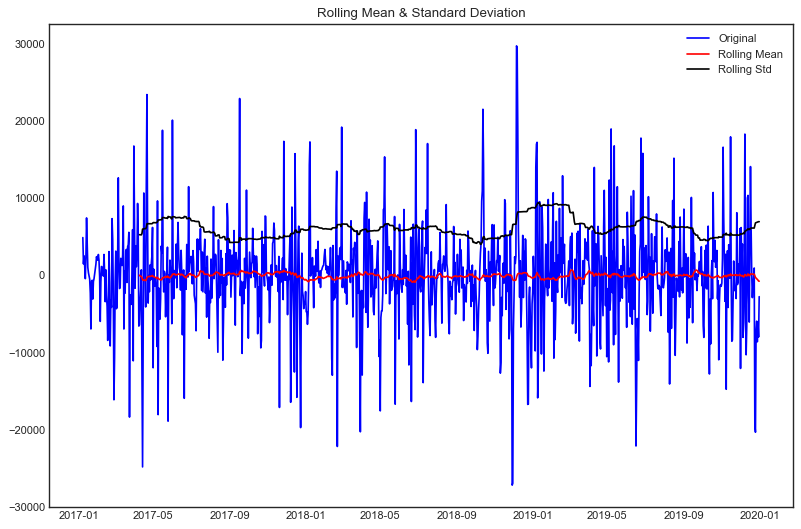

Results of Dickey-Fuller Test:
Test Statistic                -9.602898e+00
p-value                        1.899613e-16
#Lags Used                     2.100000e+01
Number of Observations Used    1.066000e+03
Critical Value (1%)           -3.436499e+00
Critical Value (5%)           -2.864255e+00
Critical Value (10%)          -2.568216e+00
dtype: float64
La media es: -116.47
La desviación estándar es: 6202.12


In [98]:
# Efectuar el test de estacionariedad de la serie con un retardo de 92 días
# Tomamos la ventana de tiempo de un trimestre (tiempo a predecir)
n = 92
test_stationarity (diario_diff[7:], n)
print("La media es:", diario_diff[7:].mean().round (2))
print("La desviación estándar es:", diario_diff[7:].std().round(2))

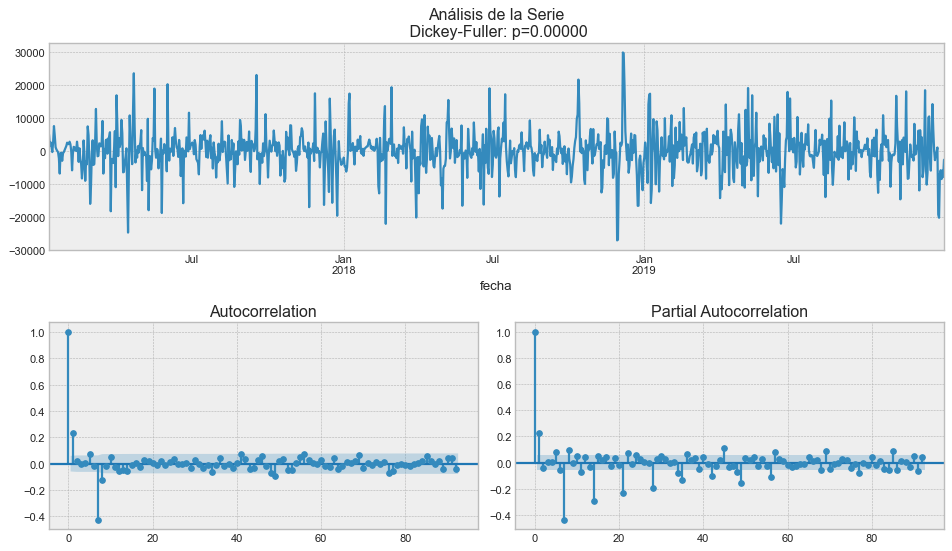

In [99]:
# Analizar la autocorrelación de la variable para comprender el detalle del comportamiento con un retardo de siete días
tsplot(diario_diff[7:], lags= 92)

* Luego de la transformación, la serie toma valores dentro del intervalo de confianza desde el 2do retardo en adelante, tanto para la autocorrelación parcial como a nivel general.
* A nivel de diferenciación de 7 períodos, la serie pierde el componente estacional en la autocorrelación parcial luego del retardo 25. 

#### Conclusiones del análisis de la serie a nivel diario:
La serie original, la serie no es estacionaria, presenta componentes de estacionalidad, autoregresivos, de medias móviles, y anomalías (ruido).
Se llevó a cabo la diferenciación de la serie, determinando que a la primer diferenciación la serie se convierte en estacionaria, asumiendo la estacionariedad con un nivel de confianza del 1%, conservando el componente estacional.
A su vez, diferenciando la serie se eliminó el componente estacional.

### 2. Resampleo semanal
Se llevará a cabo el análisis de la serie a nivel semanal, para verificar su comportamiento.

In [100]:
# Hacemos un resampleo de la serie diaria a semanal
serie_semanal = diario['cantidad_pasos'].resample('W').sum()
serie_semanal.head(5)

fecha
2017-01-01     31183.0
2017-01-08    347212.0
2017-01-15    366413.0
2017-01-22    357215.0
2017-01-29    354581.0
Freq: W-SUN, Name: cantidad_pasos, dtype: float64

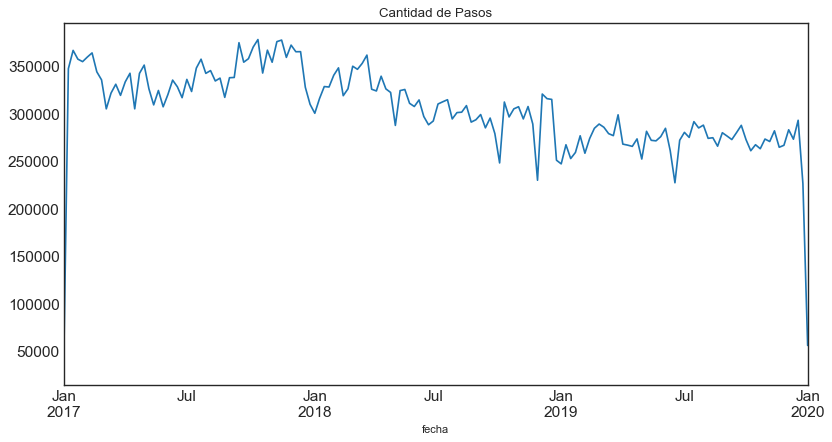

In [101]:
# Graficamos la serie para verificar su comportamiento
serie_semanal.plot(figsize=(12,6), title= 'Cantidad de Pasos', fontsize=14)
plt.show()

* La serie presenta un comportamiento aditivo como a nivel diario, por lo que se llevará a cabo la descomposición a través de este método.

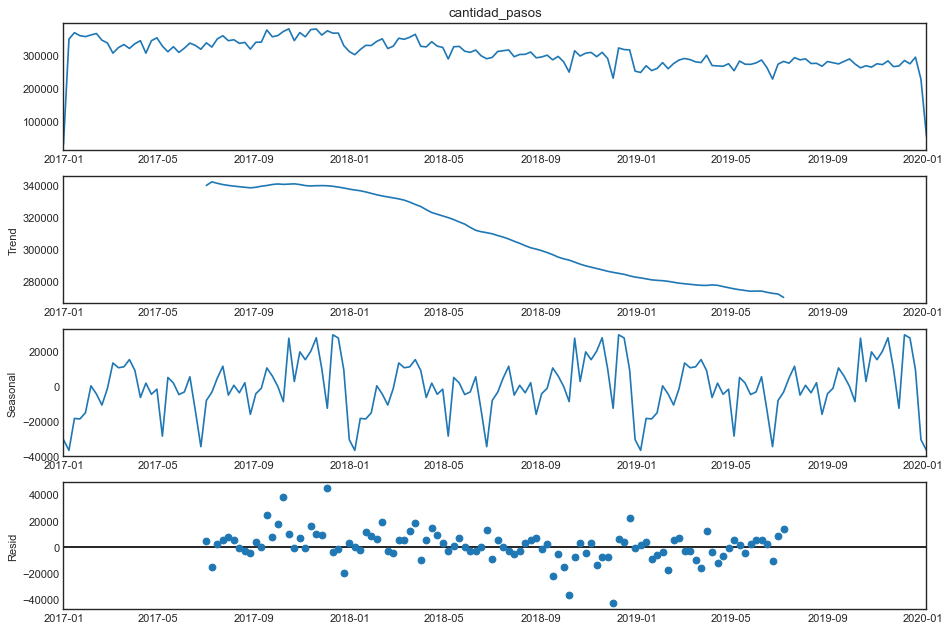

In [102]:
rcParams['figure.figsize'] = 12, 8
decomposition_s = sm.tsa.seasonal_decompose(serie_semanal, model='additive')
fig = decomposition_s.plot()
plt.show()

Si bien en este caso se observa una tendencia a la baja con mayor detalle, no es tan marcada y puede deberse al hecho de que contamos con menos puntos. Se puede observar además que la misma varía en un rango de amplitud 60000 pasos, el cual no es grande en comparación a los valores que toma la serie. Por otra parte, se mantiene la presencia de períodos estacionales que se repiten durante los tres años considerados.
Los residuos parecen tener un componente con menor aleatoriedad que a nivel diario.

In [103]:
first_diff_sem = serie_semanal.diff() #primera diferenciación
second_diff_sem = serie_semanal.diff().diff() #segunda diferenciación

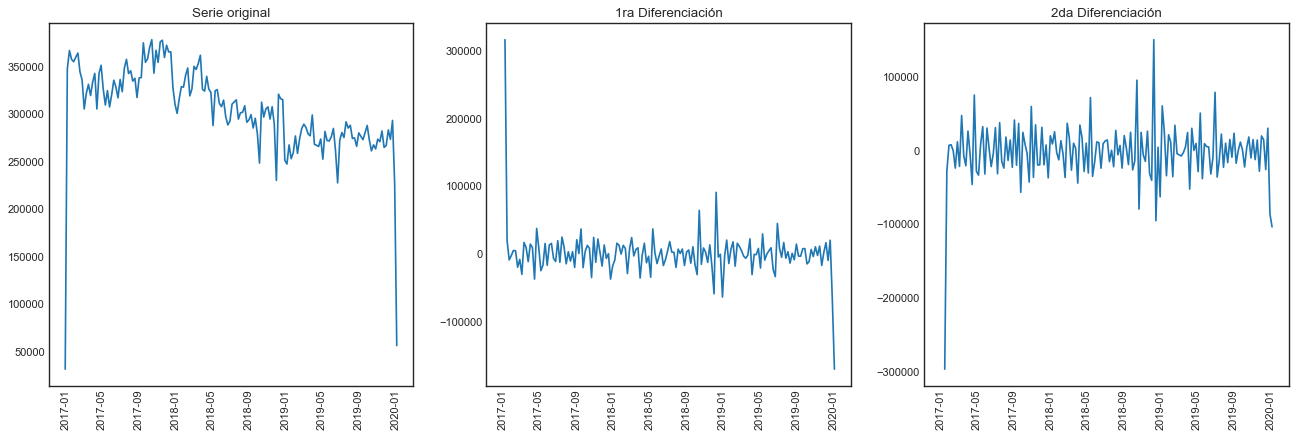

In [104]:
# Graficar las series diferenciada
plt.rcParams.update({'figure.figsize':(20,6), 'figure.dpi':80})

# Serie Original
fig, axes = plt.subplots(1, 3, sharex=True)
axes[0].plot(serie_semanal) 
axes[0].set_title('Serie original')

# Primera Diferenciación
axes[1].plot(first_diff_sem.dropna())
axes[1].set_title('1ra Diferenciación')

# Segunda Diferenciación
axes[2].plot(second_diff_sem.dropna())
axes[2].set_title('2da Diferenciación')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.show()

* A nivel de la serie diferenciada con un período, se puede oservar un comportamiento más estable que a nivel de segunda diferenciación

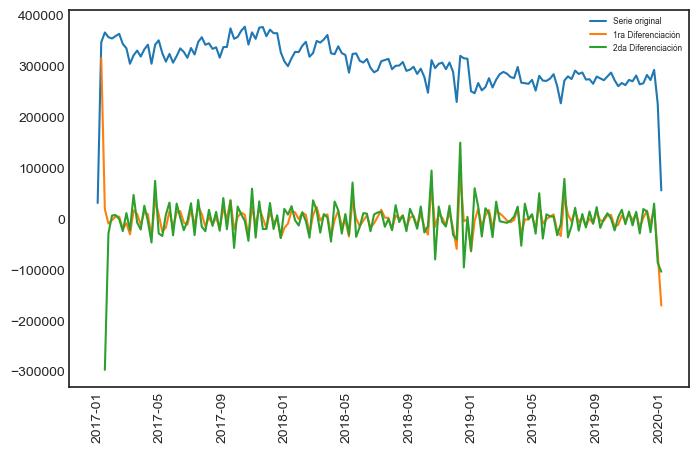

In [105]:
# Graficar las tres series juntas para compararlas

fig, axes = plt.subplots(1, 1, figsize=(8,5), dpi=100, sharex=True)

axes.plot(serie_semanal, label='Serie original')
axes.plot(first_diff_sem, label='1ra Diferenciación')
axes.plot(second_diff_sem, label='2da Diferenciación')
axes.legend(loc='upper right', fontsize=6)
plt.xticks(rotation=90)

plt.show()

* No se observan diferencias significativas entre la primer y segunda diferenciación, por lo que podría ser adecuado trabajar con una serie diferenciada un solo período.

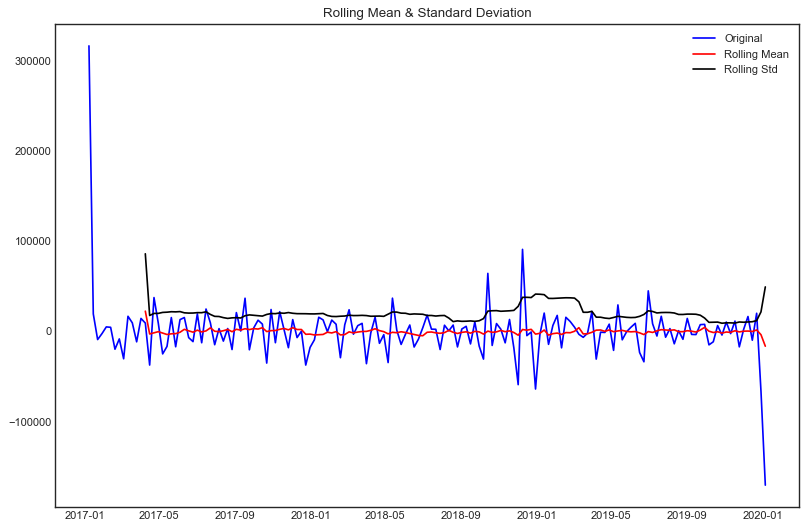

Results of Dickey-Fuller Test:
Test Statistic                -1.034579e+01
p-value                        2.613310e-18
#Lags Used                     1.000000e+00
Number of Observations Used    1.550000e+02
Critical Value (1%)           -3.473259e+00
Critical Value (5%)           -2.880374e+00
Critical Value (10%)          -2.576812e+00
dtype: float64


In [106]:
# Efectuar el test de estacionariedad de la serie con una diferenciación
# Tomamos la ventana de tiempo de un trimestre (tiempo a predecir)
n = 14
test_stationarity (first_diff_sem.dropna(), n)


La serie se vuelve estable a nivel de 1% de confianza, con una varianza de poca amplitud.

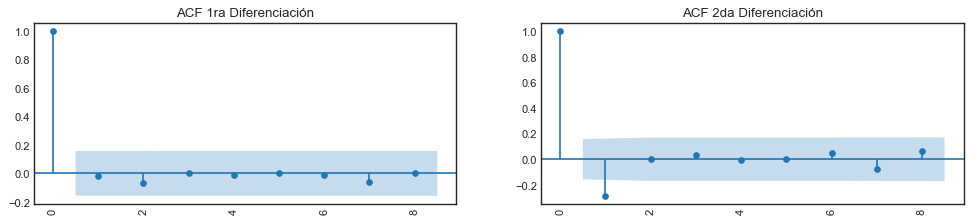

In [107]:
# Verificamos el comportamiento de la autocorrelación en las series diferenciadas:
plt.rcParams.update({'figure.figsize':(15,3), 'figure.dpi':80})

fig, axes = plt.subplots(1, 2, sharex=True)
# Graficamos la autocorrelación luego de la primer diferenciación
plot_acf(first_diff_sem.dropna(),lags=8,ax=axes[0], title='ACF 1ra Diferenciación')

# Graficamos la autocorrelación luego de la segunda diferenciación
plot_acf(second_diff_sem.dropna(), lags=8,ax=axes[1] , title='ACF 2da Diferenciación')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.subplots_adjust(hspace = 0.5)
plt.show()

* La serie con una diferenciación ingresa dentroo del intervalo de confianza desde el primer retardo, mientras que la serie con dos diferenciaciones lo hace al segundo.

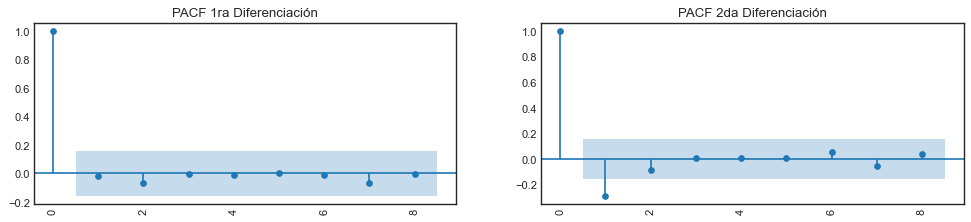

In [108]:
# Verificamos el comportamiento de la autocorrelación parcial  en las series diferenciadas:
plt.rcParams.update({'figure.figsize':(15,3), 'figure.dpi':80})

fig, axes = plt.subplots(1, 2, sharex=True)

# Graficamos la autocorrelación parcial luego de la primer diferenciación
plot_pacf(first_diff_sem.dropna(),lags=8,ax=axes[0], title='PACF 1ra Diferenciación')


# Graficamos la autocorrelación parcial luego de la segunda diferenciación
plot_pacf(second_diff_sem.dropna(), lags=8,ax=axes[1] , title='PACF 2da Diferenciación')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.subplots_adjust(hspace = 0.5)
plt.show()

* Se obsevra el mismo comportamiento que a nivel de autocorrelación, ingresando luego del primer período dentro del intervalo de confianza para el primer nivel de diferenciación y en el segundo para el segundo nivel de diferenciación.

#### Conclusiones del análisis de la serie semanal:

* La serie no es estacionaria a nivel semanal, su media presenta una tendencia decreciente y una varianza con un grado de amplitud significativo.
* Luego de la primer diferenciación, la serie se convierte en estacionaria con un nivel de confianza del 1%, mientras alcanza su componente de Autocorrelación y medias móviles en 1, por lo que sería el mejor nivel de diferenciación a aplicar

## Conclusión del análisis de autocorrelación, estacionariedad y estacionalidad de la serie

Mediante la descomposición de la serie, se pudo observar que tomando el período de tiempo de 3 años, la misma no es estacionaria a nivel diario y semanal, con una media y varianza que se modifica a lo largo del tiempo y una autocorrelación significativa principalmente durante el primer año.
Mediante el análisis con un retardo de 92 días, la serie presenta sus residuos correlacionados y un comportamiento estacional que se repite en un ciclo de 7 retardos.
Al diferenciar la serie a nivel diaria y semanal, se pudo alcanzar que la misma sea estacionaria luego del primer período.
* El modelo puede ser identificado como un modelo SARIMA, tanto a nivel diario como semanal, ya que presenta:
a) Componente Autoregresivo: observado a través de las gráficas de Autocorrelación parcial.
b) Componente de medias móviles del modelo: que se observa a través de la autocorrelación general.
c) Componente estacional: la serie tiene un comportamiento cíclico cada 7 días.

## Armado del modelo SARIMA

El algoritmo SARIMA posee los siguientes parámetros:

(p,d,q)  son los parámetros de la componente no estacional y (P,D,Q) están asociados a la componente estacional. 
* El término "s" (seasonal) es la periodicidad de la serie de tiempo (52 para períodos, 365 para períodos diarios, etc )

Detalle de los componentes del modelo:

* p es la parte autoregresiva del modelo (AR) y su valor puede ser obtenido a partir del gráfico de Autocorrelación Parcial (PACF), identificando la primera vez que dicho gráfico cruza la región de confianza. Este valor permite incorporar el efecto de los valores pasados en la predicción.
* d es la cantidad de veces que los datos deben ser diferenciados (es decir, el número de valores pasados que se sustraen al valor actual) para obtener datos estacionarios y corresponde a la parte integrada del modelo (I). 
* q se corresponde con la parte de media móvil del modelo (MA) y su valor puede ser obtenido a partir del gráfico de Autocorrelación (ACF), identificando el valor donde dicho gráfico cruza por primera vez la región de confianza.


### Determinación de hiperparámetros del modelo SARIMA

Entre las métricas más usadas para comparar diferentes modelos ARIMA se encuentran el Criterio de Información de Akaike (AIC por sus siglas en inglés) y el Criterio de Información Bayesiano (BIC por sus siglas en inglés). 

En este caso se elige el AIC, que es un estimador de la calidad relativa de los modelos estadísticos para un conjunto de datos y toma en cuenta la complejidad del mismo. Nos interesan aquellos modelos que proporcionan el valor más bajo de AIC.

### Análisis del modelo con la serie diaria:
Buscaremos los hiperparámetros óptimos del modelo efectuando un bucle for por un rango que pueden asumir los mismos.

C:\Users\Virginia\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


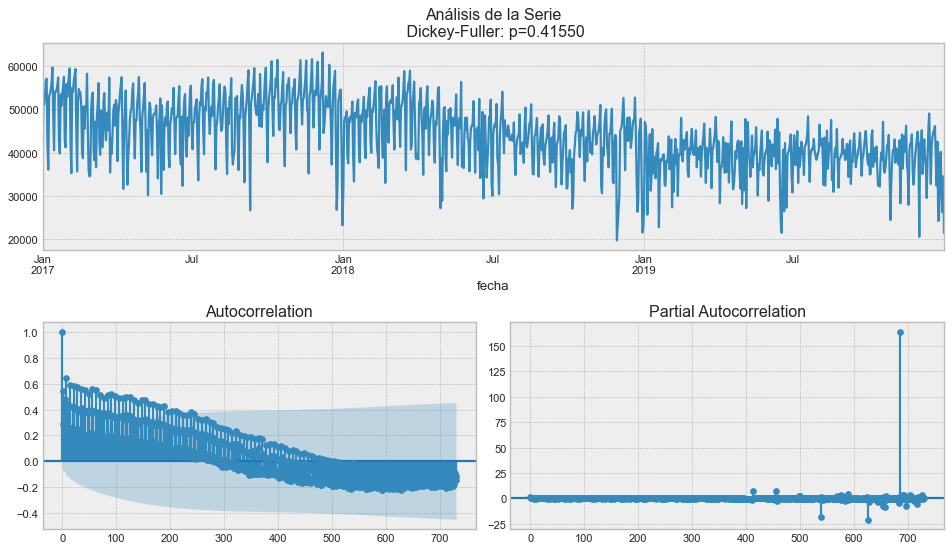

In [109]:
# Retomamos la serie original
tsplot(diario.cantidad_pasos, lags=730)

In [110]:
# Optimización de hiperparámetros para determinar los componentes del modelo SARIMA
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 30) for x in list(itertools.product(p, d, q))] # Elegimos un parámetro estacional de 30 días
AIC = []
param_ = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(diario,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}30 - AIC:{}'.format(param,param_seasonal,results.aic))
            AIC.append(results.aic)
            param_.append((param,param_seasonal))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 30)30 - AIC:26529.665478813557
ARIMA(0, 0, 0)x(0, 0, 1, 30)30 - AIC:25091.254934380573
ARIMA(0, 0, 0)x(0, 1, 0, 30)30 - AIC:22412.416421729264
ARIMA(0, 0, 0)x(0, 1, 1, 30)30 - AIC:21415.011870561302
ARIMA(0, 0, 0)x(1, 0, 0, 30)30 - AIC:22418.681198345497
ARIMA(0, 0, 0)x(1, 0, 1, 30)30 - AIC:22209.348156749904
ARIMA(0, 0, 0)x(1, 1, 0, 30)30 - AIC:21559.124468632042
ARIMA(0, 0, 0)x(1, 1, 1, 30)30 - AIC:21383.594560619895
ARIMA(0, 0, 1)x(0, 0, 0, 30)30 - AIC:25741.704278120906
ARIMA(0, 0, 1)x(0, 0, 1, 30)30 - AIC:24861.19389369547
ARIMA(0, 0, 1)x(0, 1, 0, 30)30 - AIC:22222.563541706273
ARIMA(0, 0, 1)x(0, 1, 1, 30)30 - AIC:21181.918821280706
ARIMA(0, 0, 1)x(1, 0, 0, 30)30 - AIC:24787.51780277401
ARIMA(0, 0, 1)x(1, 0, 1, 30)30 - AIC:24735.192094492395
ARIMA(0, 0, 1)x(1, 1, 0, 30)30 - AIC:21389.118548877574
ARIMA(0, 0, 1)x(1, 1, 1, 30)30 - AIC:21248.00075476138
ARIMA(0, 1, 0)x(0, 0, 0, 30)30 - AIC:22495.207613333187
ARIMA(0, 1, 0)x(0, 0, 1, 30)30 - AIC:21857.28490016

In [111]:
# Determinar el mejor modelo( menor AIC)
param_[AIC.index(min(AIC))]

((0, 0, 1), (0, 1, 1, 30))

* EL modelo de menor AIC es el considerado modelo más óptimo, en el caso de la serie diaria asume:
p = 0 . El componente autoregresivo óptimo es cero, a diferencia de lo que se esperaba a través de los gráficos de PACF.
I = 0: El componente de diferenciación, que en este caso optimizó en 0.
q = 1: el componente de medias móviles optimizó en 1.

* El modelo estacional, optimizó con los valores:
p = 0.
I = 1.
q = 1.
S = 30. El componente estacional elegido, en este caso 30 días.


In [112]:
# Entrenar el modelo optimizado
mod = sm.tsa.statespace.SARIMAX(diario,
                                order=(0, 0, 1),
                                seasonal_order=(0, 1, 1, 30),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     cantidad_pasos   No. Observations:                 1095
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 30)   Log Likelihood              -10587.959
Date:                            Sat, 24 Oct 2020   AIC                          21181.919
Time:                                    15:33:58   BIC                          21196.739
Sample:                                01-01-2017   HQIC                         21187.543
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4438      0.025     17.731      0.000       0.395       0.493
ma.S.L30      -0.5536      0.015   

* Tomando una estacionalidad de 30 días, la serie no tiene componente autoregresivo, aunque si tiene un componente de medias móviles de 1 en su modelo general y modelo estacional. el AIC es de 21.181. Si se observan los valores de los residuos respecto a la normalidad de los mismos, se puede observar que tiene el componente de sesgo marcando su asimetría.

In [113]:
# Optimizar hiperparámetros con el modelo de estacionalidad de 7 días
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq_d = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
AIC_d = []
param_d = []
for param in pdq:
    for param_seasonal in seasonal_pdq_d:
        try:
            mod_d = sm.tsa.statespace.SARIMAX(diario,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results_d = mod_d.fit()
            print('ARIMA{}x{}7 - AIC:{}'.format(param,param_seasonal,results_d.aic))
            AIC_d.append(results_d.aic)
            param_d.append((param,param_seasonal))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:26529.665478813557
ARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:25617.94758280577
ARIMA(0, 0, 0)x(0, 1, 0, 7)7 - AIC:22071.334682666606
ARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC:21617.430868132127
ARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:22085.049434501503
ARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:21894.956680647898
ARIMA(0, 0, 0)x(1, 1, 0, 7)7 - AIC:21736.063670306816
ARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:21618.999702665158
ARIMA(0, 0, 1)x(0, 0, 0, 7)7 - AIC:25741.704278120906
ARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:25399.604862231507
ARIMA(0, 0, 1)x(0, 1, 0, 7)7 - AIC:21993.826730527966
ARIMA(0, 0, 1)x(0, 1, 1, 7)7 - AIC:21551.23494077873
ARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC:22024.057506702942
ARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:25256.47408611018
ARIMA(0, 0, 1)x(1, 1, 0, 7)7 - AIC:21688.70334610987
ARIMA(0, 0, 1)x(1, 1, 1, 7)7 - AIC:21553.054378836132
ARIMA(0, 1, 0)x(0, 0, 0, 7)7 - AIC:22495.207613333187
ARIMA(0, 1, 0)x(0, 0, 1, 7)7 - AIC:22219.779235583977
ARIMA(0, 1, 0)x(0, 1, 0, 7)7 - A

In [114]:
# Determinar el modelo óptimo (menor AIC)
param_d[AIC_d.index(min(AIC_d))]

((1, 0, 1), (0, 1, 1, 7))

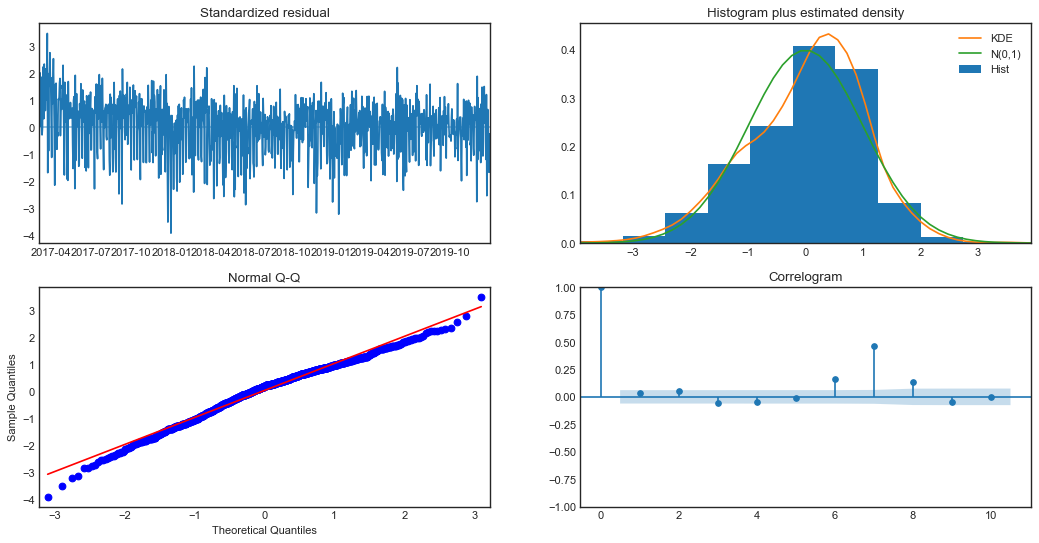

In [115]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

* Tomando un componente estacional de 7 días, la serie asume los valores:
p = 1. El componente Autoregresivo está presente.
D = 0. La diferenciación = 0.
q = 1. El componente de medias móviles.

Para los componentes estacionales:
p = 0.
D = 1.
q = 1.
Estacionalidad: 7 días.

In [116]:
# Entrenar el modelo optimizado
mod_d = sm.tsa.statespace.SARIMAX(diario,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_d = mod_d.fit()
print(results_d.summary())

                                     SARIMAX Results                                     
Dep. Variable:                    cantidad_pasos   No. Observations:                 1095
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood              -10741.917
Date:                           Sat, 24 Oct 2020   AIC                          21491.835
Time:                                   15:34:40   BIC                          21511.770
Sample:                               01-01-2017   HQIC                         21499.383
                                    - 12-31-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8856      0.015     58.811      0.000       0.856       0.915
ma.L1         -0.7472      0.029    -25.920

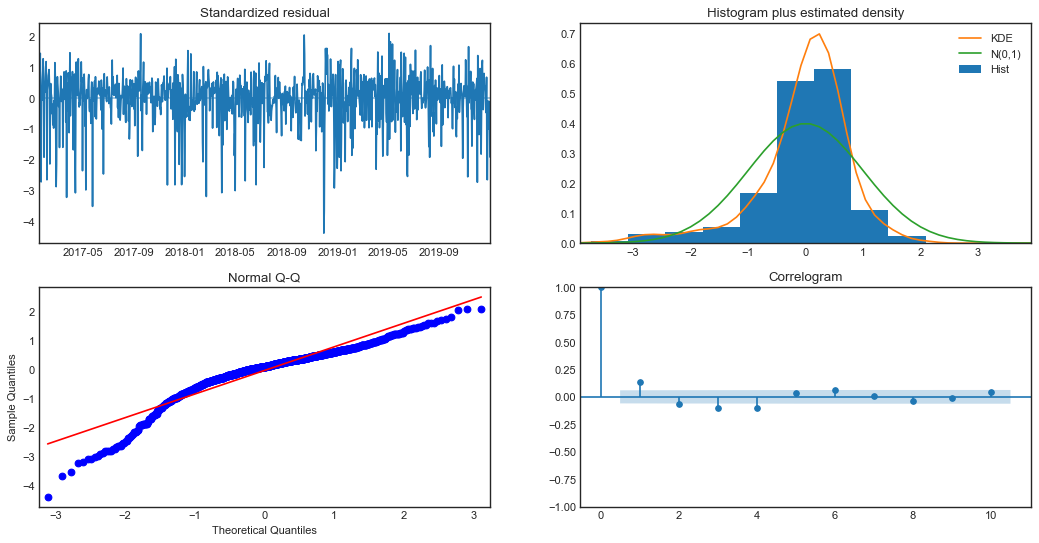

In [117]:
results_d.plot_diagnostics(figsize=(16, 8))
plt.show()

* El modelo optimizado con un componente estacional de 7 días presenta mayor dispersión en los residuos estandarizados y mayores desvíos de la tendencia lineal en el QQ Plot. 

### Conclusiones de los modelos SARIMA con la serie diaria:

* Tomando una diferenciación de 7 días, el modelo tiene componente autoregresivo como de medias móviles, mientras que en su componente de estacional solo tiene un componente de medias móviles. El AIC es un poco mayor que al valor con un componente estacional de 30 días.
Respecto a la distribución de los residuos, los mismos tienen mayor asimetría que en el caso de la serie con estacionalidad mensual.

* A nivel de predicción diaria, se puede observar que la combinación con AIC más bajo es Serie diaria: (0, 0, 1), (0, 1, 1, 30)), con una estacionalidad de 30 días ya que proporciona el menor AIC. El componente Autoregresivo a diferencia de lo observado en las gráficas de autocorrelación toma el valor de cero.

### Análisis del modelo con la serie semanal:
Buscaremos los hiperparámetros óptimos del modelo efectuando un bucle for por un rango que pueden asumir los mismos.

In [118]:
#Optimización de hiperparámetros con la serie semanal
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq_m = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
AIC_m = []
param_m = []
for param in pdq:
    for param_seasonal in seasonal_pdq_m:
        try:
            mod_m = sm.tsa.statespace.SARIMAX(serie_semanal,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results_m = mod_m.fit()
            print('ARIMA{}x{}7 - AIC:{}'.format(param,param_seasonal,results_m.aic))
            AIC_m.append(results_m.aic)
            param_m.append((param,param_seasonal))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:4416.738814300374
ARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:4116.685005063308
ARIMA(0, 0, 0)x(0, 1, 0, 7)7 - AIC:3556.9164992163815
ARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC:3366.5124058395904
ARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:3638.370703365279
ARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:3533.1549086593095
ARIMA(0, 0, 0)x(1, 1, 0, 7)7 - AIC:3394.7317883397563
ARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:3362.849477056591
ARIMA(0, 0, 1)x(0, 0, 0, 7)7 - AIC:4277.87975824519
ARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:4063.837710326798
ARIMA(0, 0, 1)x(0, 1, 0, 7)7 - AIC:3502.516237304673
ARIMA(0, 0, 1)x(0, 1, 1, 7)7 - AIC:3324.541806595773
ARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC:4100.863778731559
ARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:4048.0315383389575
ARIMA(0, 0, 1)x(1, 1, 0, 7)7 - AIC:3377.4905144842696
ARIMA(0, 0, 1)x(1, 1, 1, 7)7 - AIC:3320.0099160896875
ARIMA(0, 1, 0)x(0, 0, 0, 7)7 - AIC:3595.8153006603397
ARIMA(0, 1, 0)x(0, 0, 1, 7)7 - AIC:3438.0864069735126
ARIMA(0, 1, 0)x(0, 1, 0, 7)7 - AIC:354

In [119]:
# Determinar el mejor modelo (menor AIC)
param_m[AIC_m.index(min(AIC_m))]

((0, 1, 1), (0, 1, 1, 7))

In [120]:
# Entrenar el mejor modelo
mod_m = sm.tsa.statespace.SARIMAX(serie_semanal,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_m = mod_m.fit()

In [121]:
print(results_m.summary())

                                     SARIMAX Results                                     
Dep. Variable:                    cantidad_pasos   No. Observations:                  158
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -1636.571
Date:                           Sat, 24 Oct 2020   AIC                           3279.142
Time:                                   15:34:53   BIC                           3287.988
Sample:                               01-01-2017   HQIC                          3282.737
                                    - 01-05-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1191      0.076     -1.565      0.118      -0.268       0.030
ma.S.L7       -0.9384      0.081    -11.578

* Con la serie semanal, el modelo tomado con una estacionalidad de 7 días toma un AIC de 3279.
* La serie no presenta componente Autoregresivo pero si de medias móviles.
* Los rezagos presentan un mayor sesgo que a nivel diario.

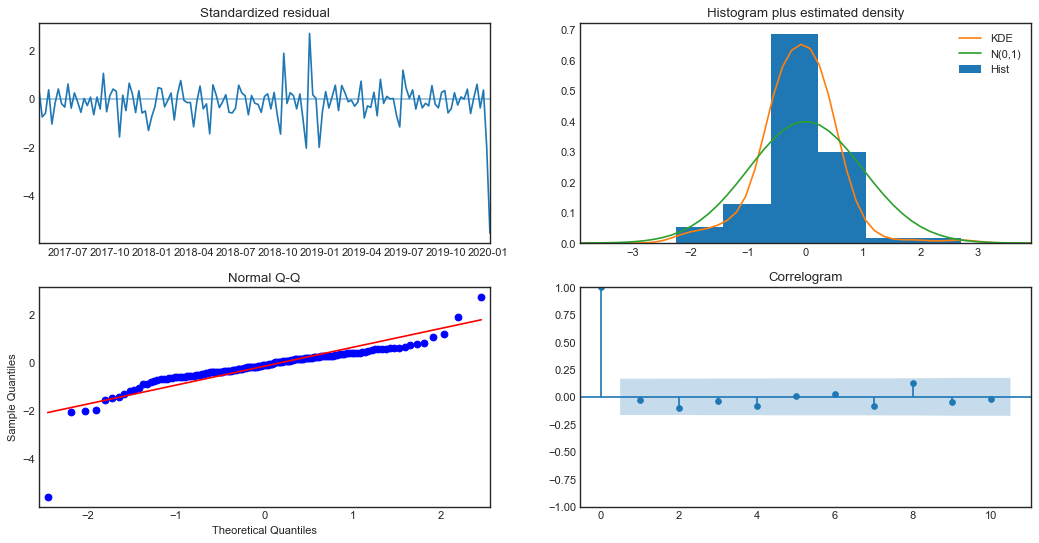

In [122]:
results_m.plot_diagnostics(figsize=(16, 8))
plt.show()

* A nivel semanal, la serie presenta menor dispersión de los residuos, como también su QQ Plot se encuentra más alrededor de la tendencia lineal.

In [123]:
#Optimización de hiperparámetros con una estacionalidad de 30 días
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq_sm = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
AIC_sm = []
param_sm = []
for param in pdq:
    for param_seasonal in seasonal_pdq_sm:
        try:
            mod_sm = sm.tsa.statespace.SARIMAX(serie_semanal,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results_sm = mod_sm.fit()
            print('ARIMA{}x{}52 - AIC:{}'.format(param,param_seasonal,results_sm.aic))
            AIC_sm.append(results_sm.aic)
            param_sm.append((param,param_seasonal))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 52)52 - AIC:4416.738814300374
ARIMA(0, 0, 0)x(0, 0, 1, 52)52 - AIC:6125945.168050007
ARIMA(0, 0, 0)x(0, 1, 0, 52)52 - AIC:2573.9613985376195


C:\Users\Virginia\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


ARIMA(0, 0, 0)x(0, 1, 1, 52)52 - AIC:1282.362438540425
ARIMA(0, 0, 0)x(1, 0, 0, 52)52 - AIC:2565.5371535718623


C:\Users\Virginia\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 52)52 - AIC:3938.546799435988
ARIMA(0, 0, 0)x(1, 1, 0, 52)52 - AIC:1327.7011219549713
ARIMA(0, 0, 0)x(1, 1, 1, 52)52 - AIC:1281.9519384340463
ARIMA(0, 0, 1)x(0, 0, 0, 52)52 - AIC:4277.87975824519


C:\Users\Virginia\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 52)52 - AIC:nan
ARIMA(0, 0, 1)x(0, 1, 0, 52)52 - AIC:2508.9182629489487
ARIMA(0, 0, 1)x(0, 1, 1, 52)52 - AIC:1257.0145832835196
ARIMA(0, 0, 1)x(1, 0, 0, 52)52 - AIC:2880.614228963035


C:\Users\Virginia\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 52)52 - AIC:nan
ARIMA(0, 0, 1)x(1, 1, 0, 52)52 - AIC:1309.4565250067103
ARIMA(0, 0, 1)x(1, 1, 1, 52)52 - AIC:1257.919256653843
ARIMA(0, 1, 0)x(0, 0, 0, 52)52 - AIC:3595.8153006603397


C:\Users\Virginia\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:901: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
C:\Users\Virginia\Anaconda3\envs\timeseries\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Virginia\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 52)52 - AIC:nan
ARIMA(0, 1, 0)x(0, 1, 0, 52)52 - AIC:2457.919826681583
ARIMA(0, 1, 0)x(0, 1, 1, 52)52 - AIC:1229.7717107003937
ARIMA(0, 1, 0)x(1, 0, 0, 52)52 - AIC:2443.0633305791835


C:\Users\Virginia\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 52)52 - AIC:nan
ARIMA(0, 1, 0)x(1, 1, 0, 52)52 - AIC:1252.8070407691228
ARIMA(0, 1, 0)x(1, 1, 1, 52)52 - AIC:1225.7819349802178
ARIMA(0, 1, 1)x(0, 0, 0, 52)52 - AIC:3571.2638139656287
ARIMA(0, 1, 1)x(0, 0, 1, 52)52 - AIC:26146.38262907818
ARIMA(0, 1, 1)x(0, 1, 0, 52)52 - AIC:2416.501452303684
ARIMA(0, 1, 1)x(0, 1, 1, 52)52 - AIC:1203.6677711658378
ARIMA(0, 1, 1)x(1, 0, 0, 52)52 - AIC:2446.1052915762484
ARIMA(0, 1, 1)x(1, 0, 1, 52)52 - AIC:2377.62842098042
ARIMA(0, 1, 1)x(1, 1, 0, 52)52 - AIC:1248.4985435030362
ARIMA(0, 1, 1)x(1, 1, 1, 52)52 - AIC:1173.0442561694654
ARIMA(1, 0, 0)x(0, 0, 0, 52)52 - AIC:3734.3075881399322
ARIMA(1, 0, 0)x(0, 0, 1, 52)52 - AIC:124997.05618941931
ARIMA(1, 0, 0)x(0, 1, 0, 52)52 - AIC:2521.7935638063336
ARIMA(1, 0, 0)x(0, 1, 1, 52)52 - AIC:1259.4159741997248
ARIMA(1, 0, 0)x(1, 0, 0, 52)52 - AIC:2456.837039493476
ARIMA(1, 0, 0)x(1, 0, 1, 52)52 - AIC:124849.33837429465
ARIMA(1, 0, 0)x(1, 1, 0, 52)52 - AIC:1258.5914408140736
ARIMA(1, 0, 

C:\Users\Virginia\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 52)52 - AIC:24775.080477488133
ARIMA(1, 0, 1)x(1, 1, 0, 52)52 - AIC:1250.4976295057031
ARIMA(1, 0, 1)x(1, 1, 1, 52)52 - AIC:1200.2091797753994
ARIMA(1, 1, 0)x(0, 0, 0, 52)52 - AIC:3597.4955971155587
ARIMA(1, 1, 0)x(0, 0, 1, 52)52 - AIC:26198.057534572745
ARIMA(1, 1, 0)x(0, 1, 0, 52)52 - AIC:2451.622575837555
ARIMA(1, 1, 0)x(0, 1, 1, 52)52 - AIC:1230.3010142246167
ARIMA(1, 1, 0)x(1, 0, 0, 52)52 - AIC:2420.7855220529427
ARIMA(1, 1, 0)x(1, 0, 1, 52)52 - AIC:2418.000571646934
ARIMA(1, 1, 0)x(1, 1, 0, 52)52 - AIC:1222.951878899984
ARIMA(1, 1, 0)x(1, 1, 1, 52)52 - AIC:1201.364660149817
ARIMA(1, 1, 1)x(0, 0, 0, 52)52 - AIC:3571.790774830677
ARIMA(1, 1, 1)x(0, 0, 1, 52)52 - AIC:23821.2971768083
ARIMA(1, 1, 1)x(0, 1, 0, 52)52 - AIC:2418.0487448039594
ARIMA(1, 1, 1)x(0, 1, 1, 52)52 - AIC:1205.5267898194984
ARIMA(1, 1, 1)x(1, 0, 0, 52)52 - AIC:2417.1066991224143
ARIMA(1, 1, 1)x(1, 0, 1, 52)52 - AIC:2401.7248730670044
ARIMA(1, 1, 1)x(1, 1, 0, 52)52 - AIC:1223.9595733666679

In [124]:
# Determinar el modelo optimizado
param_sm[AIC_sm.index(min(AIC_sm))]

((0, 1, 1), (1, 1, 1, 52))

In [125]:
mod_sm = sm.tsa.statespace.SARIMAX(serie_semanal,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_sm = mod_sm.fit()

In [126]:
print(results_sm.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     cantidad_pasos   No. Observations:                  158
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -582.522
Date:                            Sat, 24 Oct 2020   AIC                           1173.044
Time:                                    15:39:44   BIC                           1180.772
Sample:                                01-01-2017   HQIC                          1175.997
                                     - 01-05-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2965      0.155     -1.917      0.055      -0.600       0.007
ar.S.L52      -1.0992      0.247   

* El modelo con la resampleo semanal y estacionalidad semanal, toma un AIC de 1173, siendo inferior al valor obtenido con la estacionalidad de 7 días. La serie no tiene  componente autoregresivo y su componente de diferenciación es de 1, como el componente de medias móviles tanto en su componente general como estacional.

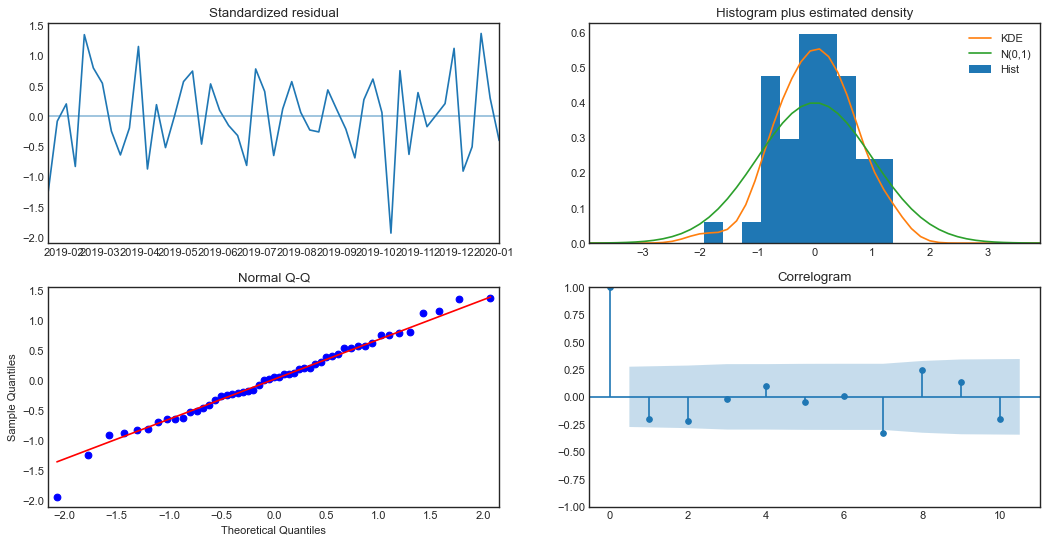

In [127]:
results_sm.plot_diagnostics(figsize=(16, 8))
plt.show()

El resampleo semanal con una estacionalidad de 52 semanas, presenta mayor dispersión en sus residuos, a pesar de obtener un mejor AIC.

## Conclusiones del modelo SARIMA:
Se llevó a cabo la prueba de los modelos SARIMA a nivel diario y semanal, efectuando una optimización de hiperparámetros para su configuración.
Los hiperparámetros del modelo fueron:
* Serie diaria: (0, 0, 1), (0, 1, 1, 30)), con una estacionalidad de 30 días ya que proporciona el menor AIC a nivel de serie con resampleo diario (AIC = 21181.919)
* Serie semanal: ((0, 1, 1), (1, 1, 1, 52)), con una estacionalidad de 7 días, ya que proporciona el menor AIC a nivel de serie con resampleo semanal.

Se define continuar con las predicciones a nivel diario, ya que la serie semanal presenta mayor dispersión en los residuos, lo que puede dificultar la capacidad de predicción de los modelos.

# Predicción a Futuro

Se construirán los siguientes modelos:
1) Modelos estadísticos: SARIMA, Simple Exponential Smoothing, Holt, Holt Winters y Prophet.
2) Modelos de Machine Learning - Regresión Lineal: modelo de XgBoost y RandomForest.
3) Modelo de benchmark: predicciones efectuadas con el valor anterior.

* Los modelos van a ser evaluados con los últimos 92 días del año de 2019 (intervalo de test).

* La métricas para medición serán el RMSE y el MAPE.
El RMSE compara el error entre los valores reales y predichos, tanto para test como para train.  La métrica se mide en la misma unidad de medida que se encuentran los datos. La justiificación del uso de esta medida, es que refleja correctamente el error en la serie, mientras que métricas porcentuales o de precisión utilizadas para series de tiempo en modelos no espéficamente creados para ello, puede que no capturen correctamente variaciones en los parámetros.
Mientras más bajo sea el valor de RMSE, menor es el error, por lo tanto el modelo predictivo va a ser más preciso.

El MAPE (Media absoluta del porcentaje de error) mide el tamaño del error en términos porcentuales. Este es calculado como el promedio del error porcentual sin signo. Es de más fácil interpretación que el RMSE ya que no se encuentra en la unidad de medida de la variable. Mientras más bajo sea el valor de MAPE, menor es el error, por lo tanto el modelo predictivo va a ser más preciso.

* El Forecast será llevado a cabo para todo el año 2020.



#### Predicción con el modelo SARIMA

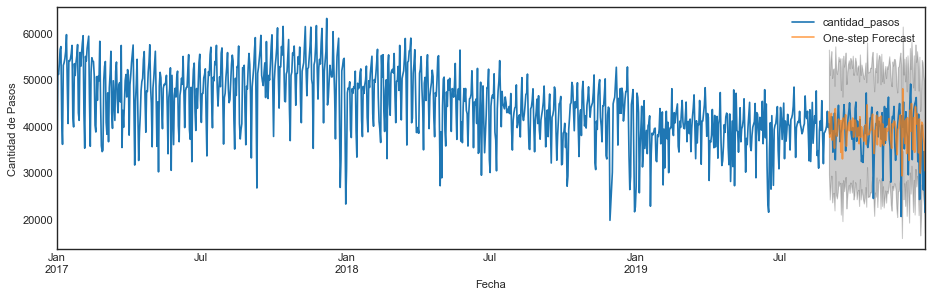

In [128]:
# Efectuamos la predicción de validación con la serie diaria
# Efectuar la predicción
pred_diario = results.get_prediction(start=pd.to_datetime('2019-09-01'), dynamic=False)
# Establecer el intervalo de confianza
pred_ci_diario = pred_diario.conf_int()
# Graficar
ax = diario ['2017':].plot(label='Datos reales')
pred_diario.predicted_mean.plot(ax=ax, label='One-step Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci_diario.index,
                pred_ci_diario.iloc[:, 0],
                pred_ci_diario.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

In [129]:
# Obtenemos las métricas del modelo
y_forecasted_diario = pred_diario.predicted_mean
y_truth_diario = diario.cantidad_pasos['2019-09-01':]
mse_sarima_diario = ((y_forecasted_diario - y_truth_diario) ** 2).mean()
rmse_sarima_diario =  (round(np.sqrt(mse_sarima_diario), 2))
print ("RMSE Sarima diario: ", rmse_sarima_diario)            

RMSE Sarima diario:  5654.16


In [130]:
mape_sarima = mean_absolute_percentage_error(y_truth_diario, y_forecasted_diario)
print ("MAPE SARIMA:", mape_sarima)

MAPE SARIMA: 12.481522156494789


Se observa como el modelo obtiene un RMSE mucho más bajo a nivel diario, ya que la comparación de la cantidad de pasos es siete veces inferior por el resampleo.

## Simple Exponential smoothing

* Se utliza generalmente cuando no hay factores de tendencia en la serie
Se utiliza un valor alfa, que es un factor de suavizado que toma valores entre 0 y 1 y determina qué tan rápido disminuye el peso para las observaciones anteriores.
Como se observa un componente de tendencia en el año 2018 pero en en 2017 y 2019 es leve, probraremos las predicciones a través de este modelo.

In [131]:
# Definimos el dataset a predecir y lo dividimos en train y test diario
Y=diario['cantidad_pasos']
train_1=Y[0:1003] # 2017 hasta 30-09-2019
test_1=Y[1003:] # último trimestre 2019

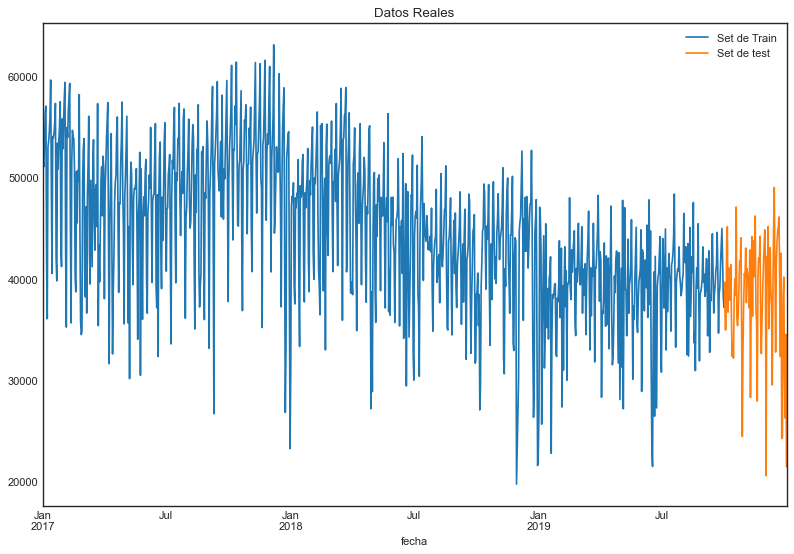

In [132]:
# Graficamos el set de Train y Test
train_1.plot(legend=True,label='Set de Train')
test_1.plot(legend=True,label='Set de test',figsize=(12,8))
plt.title ("Datos Reales");

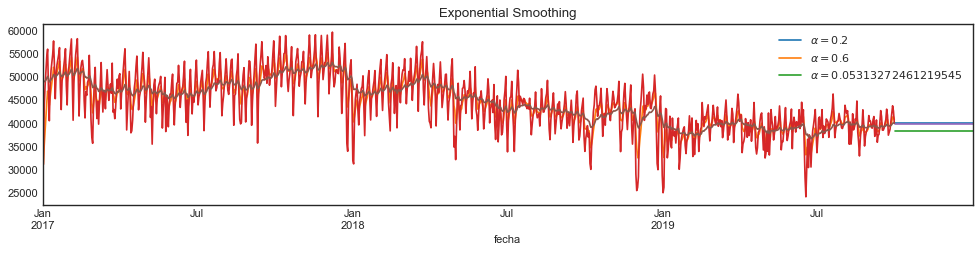

In [133]:
# Simple Exponential Smoothing
# Crear el modelo con un alfa = 0.2
fit1 = SimpleExpSmoothing(train_1).fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(92).rename(r'$\alpha=0.2$')
# Graficar
fcast1.plot(legend=True)
fit1.fittedvalues.plot()

# Crear el modelo con un alfa = 0.6:
fit2 = SimpleExpSmoothing(train_1).fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(92).rename(r'$\alpha=0.6$')
# Graficar
fcast2.plot(legend=True)
fit2.fittedvalues.plot()


# Crear el modelo con los parámetros por defecto del modelo optimizado
fit3 = SimpleExpSmoothing(train_1).fit()
fcast3 = fit3.forecast(92).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
# plot
fcast3.plot(legend=True)
fit3.fittedvalues.plot()


plt.title ("Exponential Smoothing")

plt.show()

En el gráfico anterior, roja muestra los valores reales, mientras que la línea azul oscuro representa el suavizado exponencial de la serie de tiempo con un factor de suavizado de 0,2, la línea naranja usa un factor de suavizado de 0,6 y la línea verde un suavizado de 0.05 (optimizada por el modelo).
Como puede ver, cuanto menor sea el factor de suavizado, más suave será la serie temporal. Esto tiene sentido, porque a medida que el factor de suavizado se acerca a 0, nos acercamos al modelo de media móvil.

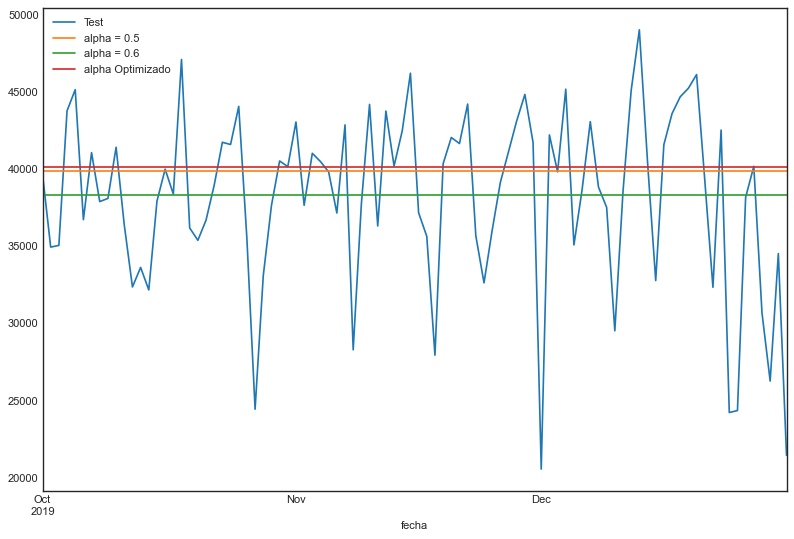

In [134]:
# Graficar los datos Predichos vs Test.
test_1.plot(legend=True,label='Test',figsize=(12,8))
fcast3.plot(legend=True,label='alpha = 0.5',figsize=(12,8)).plot(legend=True,label='PREDICTION', color ="green")
fcast2.plot(legend=True,label="alpha = 0.6",figsize=(12,8)).plot(legend=True,label='PREDICTION', color = "cyan")
fcast1.plot(legend=True,label="alpha Optimizado",figsize=(12,8)).plot(legend=True,label='PREDICTION', color = "blue");

* Como la serie cuenta con componentes de tendencia y exponenciales, no captura los datos de manera correcta.

In [135]:
# Imprimer los primeros dos valores de predicción de cada modelo:
print(fcast1.head(2),fcast2.head(2),fcast3.head(2))

2019-10-01    40108.257766
2019-10-02    40108.257766
Freq: D, Name: $\alpha=0.2$, dtype: float64 2019-10-01    38333.550033
2019-10-02    38333.550033
Freq: D, Name: $\alpha=0.6$, dtype: float64 2019-10-01    39888.068437
2019-10-02    39888.068437
Freq: D, Name: $\alpha=0.05313272461219545$, dtype: float64


In [136]:
# Obtenemos la métrica RMSE
print("RMSE Forecast 1", np.sqrt(mean_squared_error(test_1,fcast1)))
print("RMSE Forecast 2", np.sqrt(mean_squared_error(test_1,fcast2)))
print("RMSE Forecast 3", np.sqrt(mean_squared_error(test_1,fcast3)))

RMSE Forecast 1 6076.2384845076995
RMSE Forecast 2 5768.528396347466
RMSE Forecast 3 6010.505664381792


* El modelo con menor RMSE es el 2do Forecast, con un alpha = 0.6. Este valor es cercano al valor obtenido a través del modelo de ARIMA, pero levemente superior. El modelo con mejor MAPE coincide con el de mejor RMSE.

In [137]:
# Almacenar el mejor modelo de Simple Exponential Smoothing:
rmse_se= np.sqrt(mean_squared_error(test_1,fcast2))
rmse_se

5768.528396347466

In [138]:
mape_se = mean_absolute_percentage_error(test_1,fcast2)
mape_se

13.036221165955162

## Modelo de Holt
El método de Holt implica una ecuación de pronóstico y dos ecuaciones de suavizado (una para el nivel y otra para la tendencia). Holt extendió el suavizado exponencial simple (solución a datos sin tendencia clara o estacionalidad, es decir, el modelo anterior) para permitir la predicción de datos con tendencias.
Para el pronóstico a largo plazo, el pronóstico con el método de Holt aumentará o disminuirá indefinidamente en el futuro.
* El modelo de Holt, puede tomar el componente de tendencia como lineal, exponencial o aditivo.

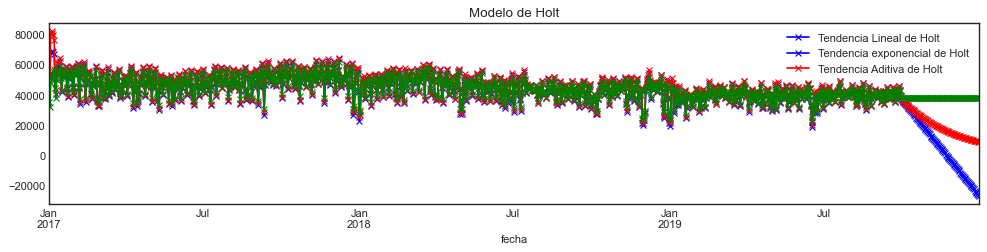

In [139]:
from statsmodels.tsa.holtwinters import Holt

# Probamos el modelo de Holt con un comportamiento de tendencia lineal

fit4 = Holt(train_1).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast4 = fit4.forecast(92).rename("Tendencia Lineal de Holt")

fit5 = Holt(train_1, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast5 = fit5.forecast(92).rename("Tendencia exponencial de Holt")

fit6 = Holt(train_1, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast6 = fit6.forecast(92).rename("Tendencia Aditiva de Holt")


fit4.fittedvalues.plot(marker="x", color='blue')
fcast4.plot(color='blue', marker="x", legend=True)
fit5.fittedvalues.plot(marker="x", color='red')
fcast5.plot(color='red', marker="x", legend=True)
fit6.fittedvalues.plot(marker="x", color='green')
fcast6.plot(color='green', marker="x", legend=True)

plt.title ("Modelo de Holt")
plt.show()

* Observando las gráficas, se puede observar como a largo plazo la serie va a tender a decrecer indefinidamente en el futuro, ya que la tedencia de la serie es decreciente.

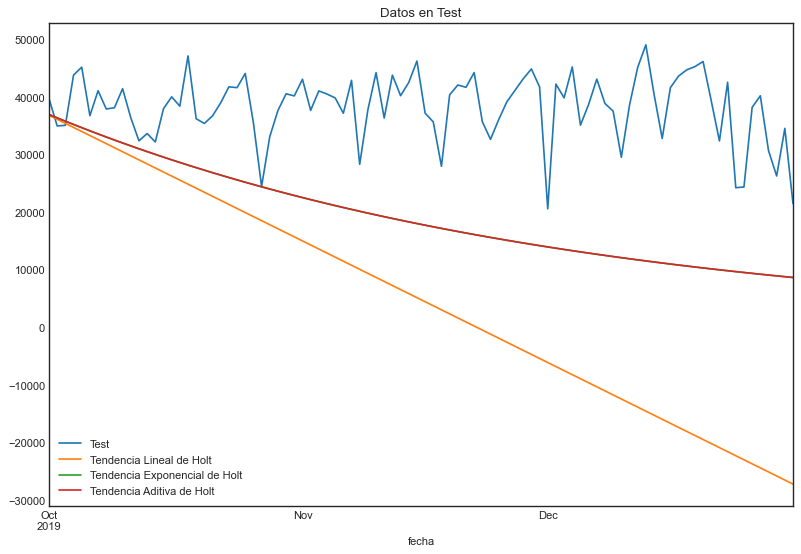

In [140]:
# Graficar los datos Predichos vs Test.
test_1.plot(legend=True,label='Test',figsize=(12,8))
fcast4.plot(legend=True,label="Tendencia Lineal de Holt",figsize=(12,8)).plot(legend=True,label='PREDICTION', color ="green")
fcast5.plot(legend=True,label="Tendencia Exponencial de Holt",figsize=(12,8)).plot(legend=True,label='PREDICTION', color = "cyan")
fcast5.plot(legend=True,label="Tendencia Aditiva de Holt",figsize=(12,8)).plot(legend=True,label='PREDICTION', color = "blue")
plt.title ("Datos en Test")
plt.show();

In [141]:
# Verificamos los primeros valores de las predicciones:
print(fcast4.head(2),fcast5.head(2),fcast6.head(2))

2019-10-01    36798.135329
2019-10-02    36094.495857
Freq: D, Name: Tendencia Lineal de Holt, dtype: float64 2019-10-01    36932.509484
2019-10-02    36347.368399
Freq: D, Name: Tendencia exponencial de Holt, dtype: float64 2019-10-01    37569.478441
2019-10-02    37569.478441
Freq: D, Name: Tendencia Aditiva de Holt, dtype: float64


In [142]:
# Obtener las métricas de RMSE:
print("RMSE Forecast 4", np.sqrt(mean_squared_error(test_1,fcast4)))
print("RMSE Forecast 5", np.sqrt(mean_squared_error(test_1,fcast5)))
print("RMSE Forecast 6", np.sqrt(mean_squared_error(test_1,fcast6)))

RMSE Forecast 4 38421.05074084746
RMSE Forecast 5 21025.533692876546
RMSE Forecast 6 5800.5637024321595


In [143]:
# Obtener las métricas de MAPE:
print("MAPE Forecast 4", mean_absolute_percentage_error(test_1,fcast4))
print("MAPE Forecast 5", mean_absolute_percentage_error(test_1,fcast5))
print("MAPE Forecast 6", mean_absolute_percentage_error(test_1,fcast6))

MAPE Forecast 4 88.88936968618452
MAPE Forecast 5 48.1327645269018
MAPE Forecast 6 13.114703218454482


* El mejor modelo de Holt se otiene con una descomposición Aditiva, un smoothing level de 0.2, tanto para la métrica de RMSE como MAPE.

In [144]:
# Almacenar el modelo de holt con mejor RMSE:
rmse_holt=np.sqrt(mean_squared_error(test_1,fcast6).round(2))
rmse_holt

5800.56370277924

In [145]:
mape_holt = mean_absolute_percentage_error(test_1,fcast6)
mape_holt

13.114703218454482

### Modelo de Holt - Winters

Peter R. Winters, agregó al modelo de Holt la estacionalidad, mejorando el algoritmo en el caso que la serie contenga estos componentes. El modelo se conoce como "Suavizado Exponencial triple" ya que cuenta con los componentes de tendencia, estacionalidad además de la serie simple.

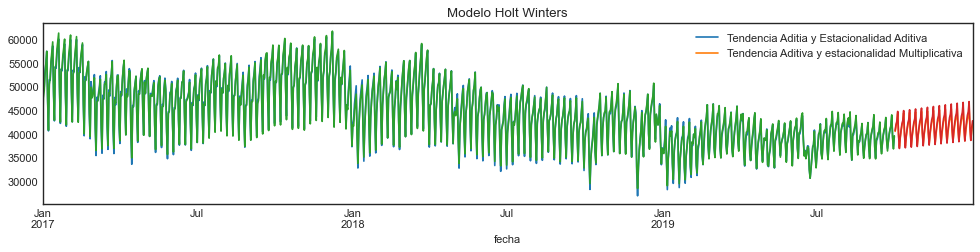

In [146]:
# Probamos el modelo de Holt con un comportamiento de tendencia lineal

fit7 = ExponentialSmoothing(train_1, trend = "add", seasonal = "add").fit()
fcast7 = fit7.forecast(92).rename("Tendencia Aditia y Estacionalidad Aditiva")

fit8 = ExponentialSmoothing(train_1, trend = "add", seasonal = "mul").fit()
fcast8 = fit8.forecast(92).rename("Tendencia Aditiva y estacionalidad Multiplicativa")



fit7.fittedvalues.plot()
fcast7.plot(legend=True)
fit8.fittedvalues.plot()
fcast8.plot(legend=True)

plt.title("Modelo Holt Winters")


plt.show()

* Los modelos parecen tener un comportamiento muy similar al modelo real, pisandose los datos con los reales.

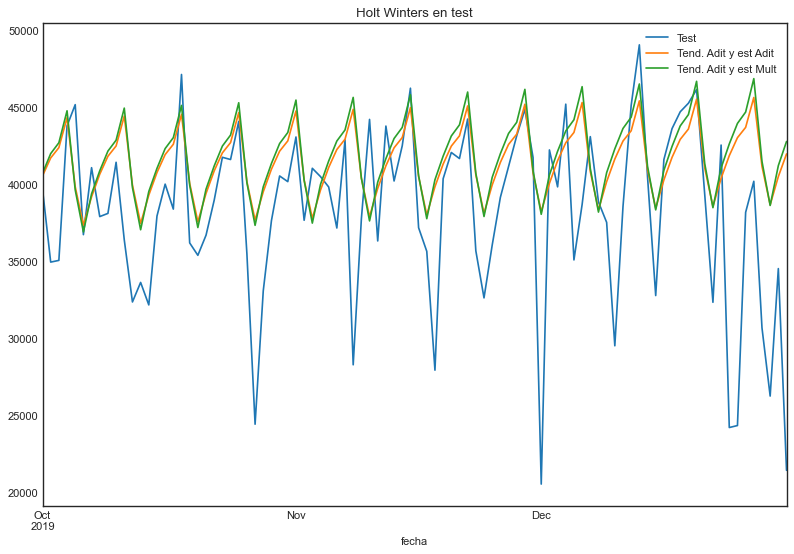

In [147]:
# Visualizamos solo los datos de test
test_1.plot(legend=True,label='Test',figsize=(12,8))
fcast7.plot(legend=True,label="Tend. Adit y est Adit",figsize=(12,8)).plot(legend=True,label='PREDICTION', color ="green")
fcast8.plot(legend=True,label="Tend. Adit y est Mult",figsize=(12,8)).plot(legend=True,label='PREDICTION', color = "cyan")
plt.title ("Holt Winters en test")
plt.show();

* El modelo captura de manera correcta los comportamientos, y se observa una muy reducida diferencia entre el modelo de tendencia aditiva y multiplicativa.

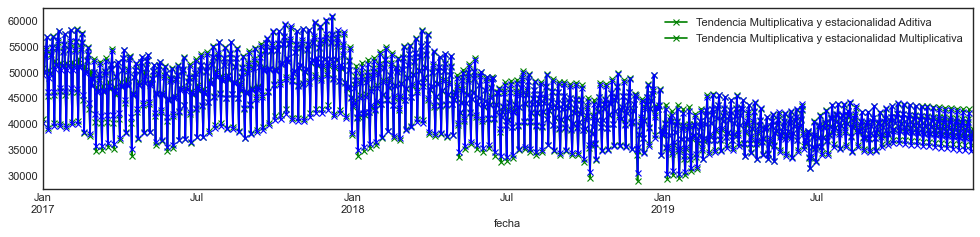

In [148]:
fit9 = ExponentialSmoothing(train_1, trend = "mul", seasonal = "add").fit()
fcast9 = fit9.forecast(92).rename("Tendencia Multiplicativa y estacionalidad Aditiva")

fit10 = ExponentialSmoothing(train_1, trend = "mul", seasonal = "mul").fit()
fcast10 = fit10.forecast(92).rename("Tendencia Multiplicativa y estacionalidad Multiplicativa")



fit9.fittedvalues.plot(marker="x", color='green')
fcast9.plot(color='green', marker="x", legend=True)
fit10.fittedvalues.plot(marker="x", color='blue')
fcast10.plot(color='blue', marker="x", legend=True)



plt.show()

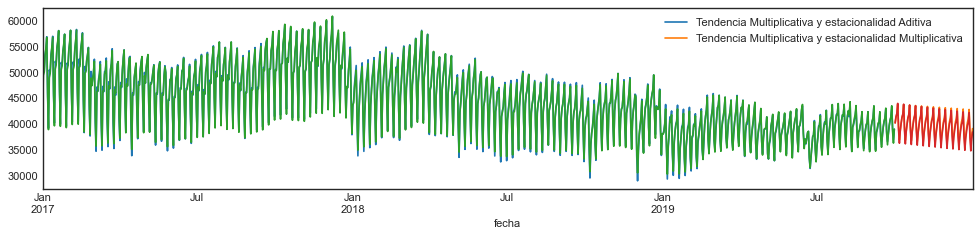

In [149]:
fit9 = ExponentialSmoothing(train_1, trend = "mul", seasonal = "add").fit()
fcast9 = fit9.forecast(92).rename("Tendencia Multiplicativa y estacionalidad Aditiva")

fit10 = ExponentialSmoothing(train_1, trend = "mul", seasonal = "mul").fit()
fcast10 = fit10.forecast(92).rename("Tendencia Multiplicativa y estacionalidad Multiplicativa")



fit9.fittedvalues.plot()
fcast9.plot( legend=True)
fit10.fittedvalues.plot()
fcast10.plot( legend=True)



plt.show()

* Al igual que en el caso anterior, el gráfico completo no permite visualizar las diferencias entre los entrenamiento, pareciendo pisarse las predicciones con los datos reales.

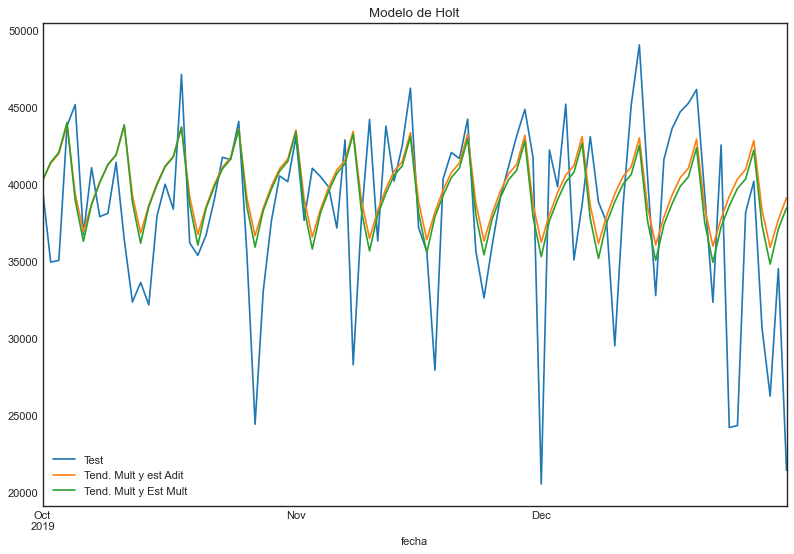

In [150]:
# Graficar los datos Predichos vs Test.
test_1.plot(legend=True,label='Test',figsize=(12,8))
fcast9.plot(legend=True,label="Tend. Mult y est Adit",figsize=(12,8)).plot(legend=True,label='PREDICTION', color = "blue")
fcast10.plot(legend=True,label="Tend. Mult y Est Mult",figsize=(12,8)).plot(legend=True,label='PREDICTION', color = "blue")
plt.title("Modelo de Holt")
plt.show()

* Los modelos parecen mostrar un comportamiento muy similar al modelo con tendencia aditiva, captura movimientos que a nivel aditivo no se capturan.

In [151]:
# Obtener las métricas de RMSE:
print("RMSE Forecast 7", np.sqrt(mean_squared_error(test_1,fcast7)))
print("RMSE Forecast 8", np.sqrt(mean_squared_error(test_1,fcast8)))
print("RMSE Forecast 9", np.sqrt(mean_squared_error(test_1,fcast9)))
print("RMSE Forecast 10", np.sqrt(mean_squared_error(test_1,fcast10)))


RMSE Forecast 7 6133.707785867452
RMSE Forecast 8 6368.342812487482
RMSE Forecast 9 5396.637013020336
RMSE Forecast 10 5274.142152603928


In [152]:
# Obtener las métricas de MAPE:
print("MAPE Forecast 7", mean_absolute_percentage_error(test_1,fcast7))
print("MAPE Forecast 8", mean_absolute_percentage_error(test_1,fcast8))
print("MAPE Forecast 9", mean_absolute_percentage_error(test_1,fcast9))
print("MAPE Forecast 10", mean_absolute_percentage_error(test_1,fcast10))

MAPE Forecast 7 13.535084471845572
MAPE Forecast 8 14.123796626739841
MAPE Forecast 9 11.850526712265653
MAPE Forecast 10 11.515356177581424


* Las métricas de RMSE y MAPE permiten arribar a la conclusión que el mejor modelo de Holt Winters es el modelo con Tendencia y Estacionalidad Multiplicativa.

In [153]:
# Almacenar el modelo de holt con mejor RMSE:
rmse_holt_win=np.sqrt(mean_squared_error(test_1,fcast10).round(2))
rmse_holt_win


5274.14215299512

In [154]:
mape_holt_win = mean_absolute_percentage_error(test_1,fcast10).round(2)
mape_holt_win

11.52

## Prophet
Esta es una librería abierta diseñada por Facebook para efectuar predicciones de series de tiempo.
Tiene un uso muy ágil y didáctico, permitiendo efectuar predicciones tanto dentro de los datos de entrenamiento como un Forecast sin datos.
También permite incorporar feriados, y modificar la metodología cálculo de la serie (Lineal, logística)
* En Este caso, se implementará el modelo ajustando los hiperparámetros en función al análisis exploratorio de datos y modelos anteriormente construidos, sin la aplicación de feriados.

In [155]:
# Efectuar el split de los datos nuevamente, para luego almacenarlos como los necesita Prophet para entrenar y evaluar
split_date = '30-Sep-2019'
diario_train = diario.loc[diario.index <= split_date].copy()
diario_test = diario.loc[diario.index > split_date].copy()

In [156]:
# Crear una nueva variable para trabajar con Prophet
data_fb = diario.reset_index()
data_fb.columns=['ds','y']
# Efectuar el Train test Split
train_fb, test_fb = data_fb[0:1003], data_fb[1003:] 
# Verificar el split
print (len(train_fb), len (test_fb))

1003 92


In [157]:
# Crear y Entrenar el modelo
# Se entrena el modelo ajustando la estacionalidad y la escala de cambios, para que pueda capturar en mayor medida las modificaciones.
fb1_model=Prophet(seasonality_mode="multiplicative", changepoint_prior_scale=0.8).fit(train_fb) 



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [158]:
# Efectuar la predicción
prediction_test_fb  = fb1_model.predict(test_fb)
# Verificar los resultados principales
prediction_test_fb [['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds          yhat    yhat_lower    yhat_upper
87 2019-12-27  40817.484538  35078.108517  46499.466144
88 2019-12-28  33500.676513  27421.499223  38932.850317
89 2019-12-29  29224.045809  23148.661653  35457.934346
90 2019-12-30  34389.739698  28123.497102  40764.872600
91 2019-12-31  35239.478311  29275.407663  40957.157248

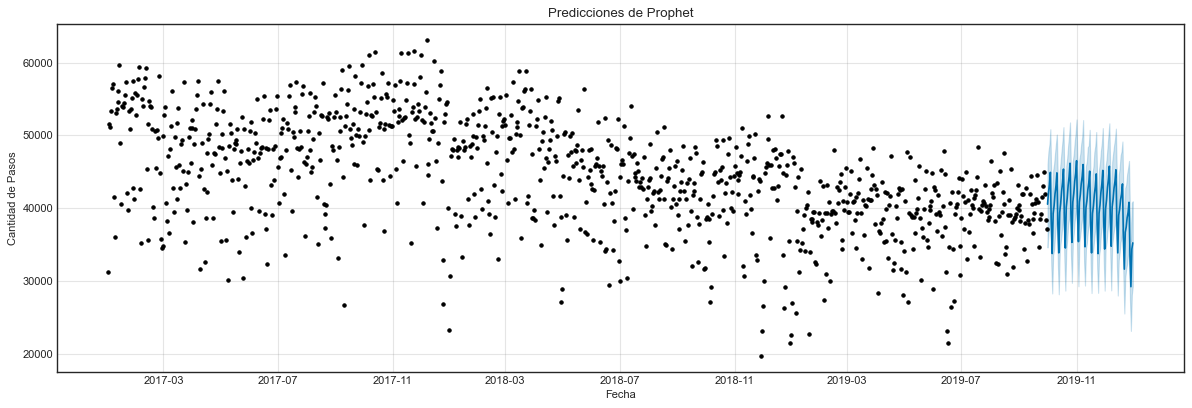

In [159]:
#Graficar los resultados predichos:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = fb1_model.plot(prediction_test_fb,ax=ax)
plt.title("Predicciones de Prophet")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Pasos")
plt.show()

* El modelo captura la estacionalidad y una tendencia a la baja en los datos, aunque las predicciones las efectua con una amplia dispersión por lo que se evalúa en primer instancia.

C:\Users\Virginia\Anaconda3\envs\timeseries\lib\site-packages\fbprophet\plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\Virginia\Anaconda3\envs\timeseries\lib\site-packages\fbprophet\plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


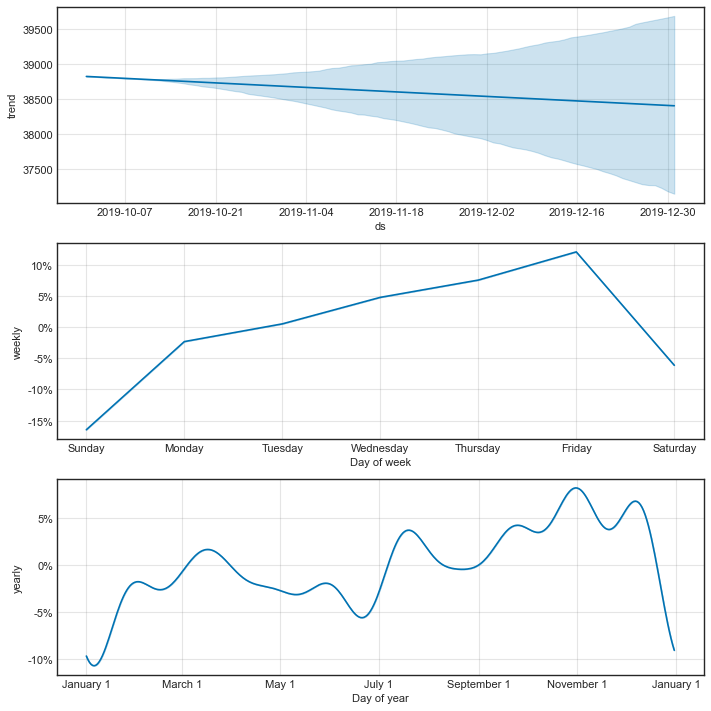

In [160]:
# Verificar los componentes del modelo:
fig2 = fb1_model.plot_components(prediction_test_fb)

* Como si visualiza en la gráfica de predicción, a través de los componentes se visualiza la tendencia a la baja a nivel general, como también la tendencia dentro de la semana con picos los días viernes. EL modelo caprtura también a nivel mensual la variación mes a mes.

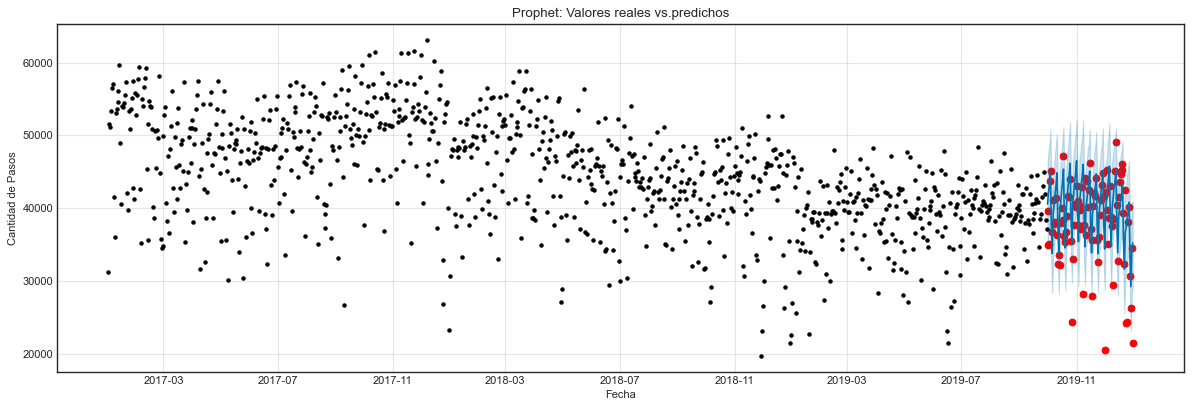

In [161]:
# Comparar los resultados reales vs los predichos:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(diario_test.index, diario_test ["cantidad_pasos"], color='r')
fig = fb1_model.plot(prediction_test_fb, ax=ax)
plt.title ("Prophet: Valores reales vs.predichos")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Pasos")
plt.show()

* Los valores reales difieren bastante de los predichos en el modelo, para el caso de bajas en la cantidad de pasos. Los picos ascendentes son capturados correctamente. 

In [162]:
# Obtener la métrica de RMSE y MAPE:

rmse_prophet = np.sqrt(mean_squared_error(diario_test,prediction_test_fb["yhat"]))
print ("RMSE Prophet: ", rmse_prophet)
mape_prophet = mean_absolute_percentage_error(diario_test,prediction_test_fb["yhat"])
print ("MAPE Prophet: ", mape_prophet)

RMSE Prophet:  5334.56498664726
MAPE Prophet:  16.412892717443242


* El modelo otiene un error y un mape superior al visualizado con otros modelos, esto se puede deber a que no captura correctamente la tendencia decreciente correctamente.

# Modelos de Machine Learning - Modelos de Regresión: Arboles de decisión
* Los modelos de Machine Learning de aprendizaje supervisado, pueden ser utilizados también para efectuar predicciones cronológicas. 
Se probarán los modelos de XBGBoost, RandomForest y se desarrollará un modelo de BenchMark.

In [163]:
# Almacenamos el dataset que usaremos para el entrenamiento descomponiendolo
senial = diario.cantidad_pasos
print (senial.shape)
senial.head()

(1095,)


fecha
2017-01-01    31183.0
2017-01-02    51568.0
2017-01-03    51093.0
2017-01-04    53332.0
2017-01-05    56486.0
Freq: D, Name: cantidad_pasos, dtype: float64

In [164]:
look_back = 365 # usamos 365 dias para entrenar

In [165]:
# Separamos los datos
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(729, 365) (729,)


In [166]:
# Creamos las variables x e y
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(729, 365) (729,)


In [167]:
# Recorremos la variable con los datos para almacenarlos en x e y
for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

In [168]:
# Creamos el set de train y de test
N_train =  (365* 2) + (365 - 93) - look_back # cantidad de instancias que vamos a usar para entrenar. 
print (N_train)
N_test = 92 #cantidad de puntos que vamos a usar para evaluar
print (N_test)
N_total = N_train + N_test
print (N_total)


637
92
729


In [169]:
# creamos X train con los primeros datos de la serie
X_train = X[:N_train,:]
print(X_train.shape)

(637, 365)


In [170]:
# Creamos el y de train con los primeros datos de la serie
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

(637, 365) (637,)


In [171]:
# Creamos x y y de test con el último trimestre de 2019
X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(92, 365) (92,)


In [172]:
# Verificamos el tamaño del set de datos
length_total = N_train + N_test + look_back

### Modelo de XGBoost

In [173]:
# Crear el Modelo de XGBoost con 100 estimadores y lo entrenamos
#reg = xgb.XGBRegressor(n_estimators=100)
reg = xgb.XGBRegressor(n_estimators=100).fit(X_train,y_train)

[15:40:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [174]:
# Predecimos
y_pred = reg.predict(X)
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

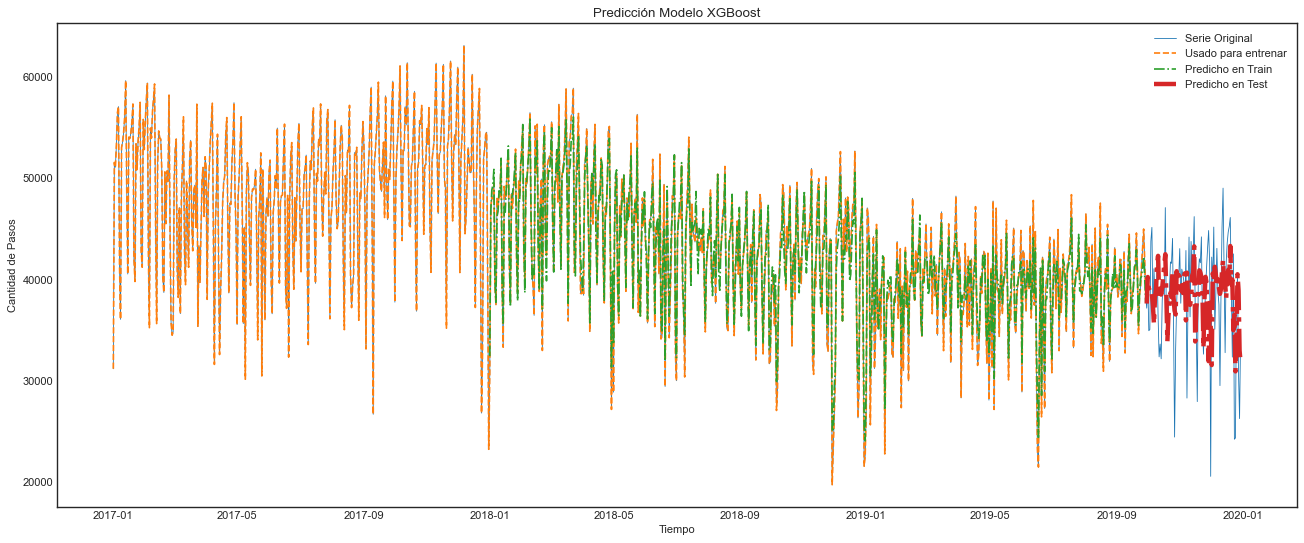

In [175]:
# Graficamos la predicción
plt.figure(figsize=(20,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test') 
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.title ("Predicción Modelo XGBoost")
plt.show()

* La gráfica permite visualizar que el modelo capta correctamente las predicciones en train, pero en test no se encuentra capturando correctamente los picos y valles de la serie, aunque si capta correctamente los componentes cíclicos.

In [176]:
# Medimos el resultado a través del RMSE
rmse_xgb_train = np.sqrt( mean_squared_error(y_train, y_train_pred) )
print('Error RMSE en Train:', rmse_xgb_train.round (2))

rmse_xgb_test = np.sqrt( mean_squared_error(y_test, y_test_pred) )
print('Error RMSE en Test:',rmse_xgb_test.round (2))

Error RMSE en Train: 1800.68
Error RMSE en Test: 5113.57


La serie presenta una alta diferencia en los valores de train y test.

In [177]:
# Optimización de hiperparámetros
from sklearn.model_selection import RandomizedSearchCV
modelo=xgb.XGBRegressor()

grid = {'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10, 14, 16 ],
    'min_child_weight': [1, 3, 5],

    'gamma': [0.8,1],
    'reg_alpha': [22,23]}

reg_best = RandomizedSearchCV(modelo, param_distributions=grid, cv=5, n_jobs=-1, random_state = 42)

reg_best.fit(X_train,y_train)

print('Mejor hiperparámetro: ',reg_best.best_params_)
print()

xg_best_hyper_params=list(reg_best.best_params_.values())


[15:41:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mejor hiperparámetro:  {'reg_alpha': 23, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.8}



In [178]:
y_pred = reg_best.predict(X)
y_train_pred_best = reg_best.predict(X_train)
y_test_pred_best = reg_best.predict(X_test)

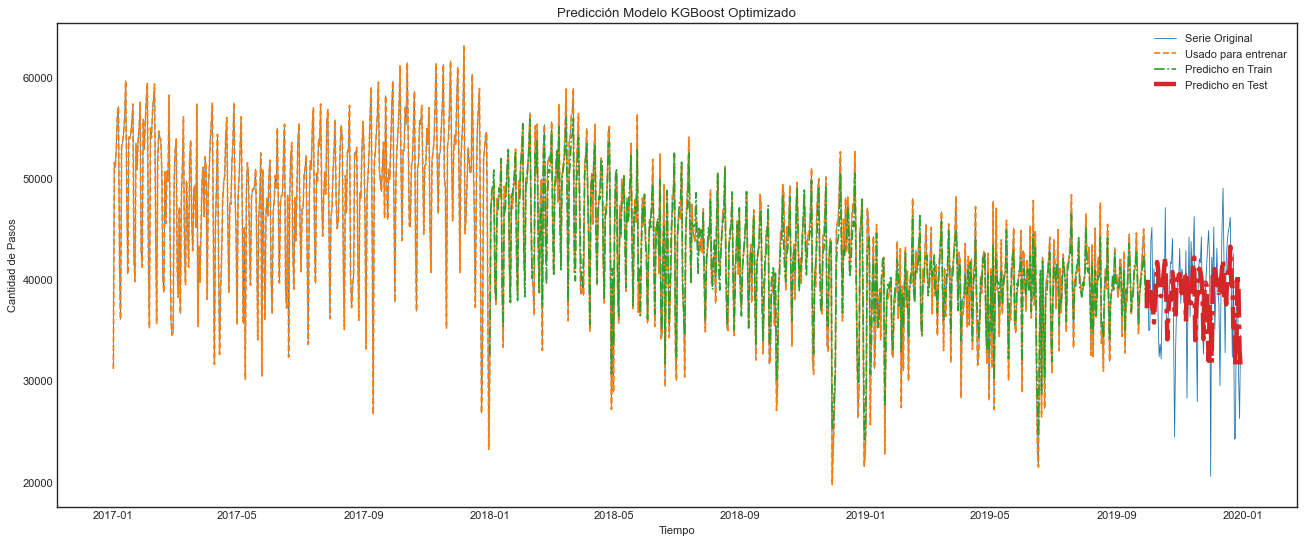

In [179]:
# Graficar el nuevo modelo

plt.figure(figsize=(20,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred_best,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_best,'-.', lw = 4, label = 'Predicho en Test') 
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.title ("Predicción Modelo KGBoost Optimizado")
plt.show()


In [180]:
rmse_xgb_train_best = np.sqrt( mean_squared_error(y_train, y_train_pred_best) )
print('Error RMSE en Train:', rmse_xgb_train.round (2))

rmse_xgb_test_best = np.sqrt( mean_squared_error(y_test, y_test_pred_best) )
print('Error RMSE en Test:',rmse_xgb_test.round (2))

Error RMSE en Train: 1800.68
Error RMSE en Test: 5113.57


In [181]:
mape_xgb = mean_absolute_percentage_error(y_test,  y_test_pred_best)
print ("MAPE Xgb:", mape_xgb)

MAPE Xgb: 11.138333571874687


Con la optimización de hiperparámetros no se producen mejoras en la métrica de RMSE.
* El Modelo presenta una alta diferencia en los valores de predicción en train y test, lo que puede deberse a que los datos del segundo trimestre de 2019 tienen un comportamiento distinto a los datos en train.

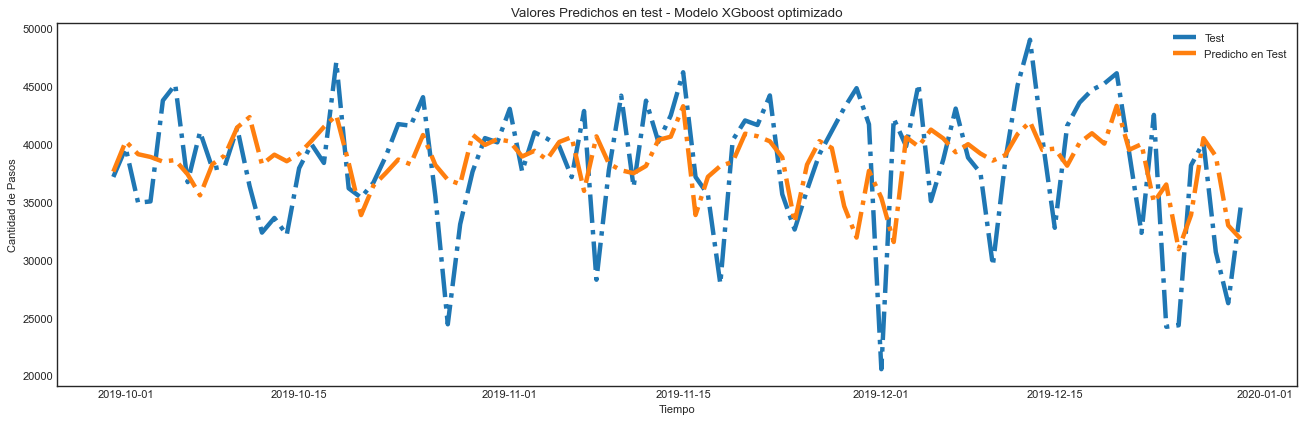

In [182]:
# Hacer un Zoom de los valores predichos en test

plt.figure(figsize=(20,6))
plt.plot(senial.index[N_train+look_back: length_total], y_test,'-.', lw = 4, label = 'Test')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.title ("Valores Predichos en test - Modelo XGboost optimizado")
plt.show()

### Modelo de RandomForest

In [183]:
# Entrenamos el modelo mediante RandomForest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

In [184]:
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

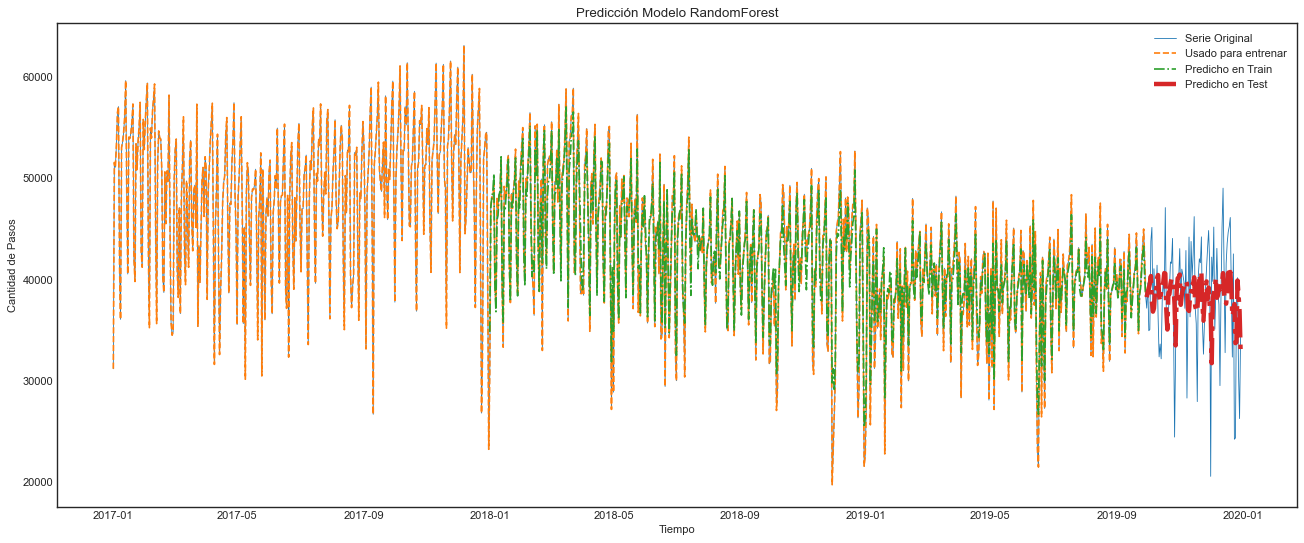

In [185]:
# Graficar el nuevo modelo

plt.figure(figsize=(20,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred_rf,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_rf,'-.', lw = 4, label = 'Predicho en Test') 
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.title ("Predicción Modelo RandomForest")
plt.show()

In [186]:
rmse_rf_train = np.sqrt( mean_squared_error(y_train, y_train_pred_rf) )
print('Error RMSE en Train:', rmse_rf_train.round (2))

rmse_rf_test = np.sqrt( mean_squared_error(y_test, y_test_pred_rf) )
print('Error RMSE en Test:',rmse_rf_test.round (2))


Error RMSE en Train: 1748.32
Error RMSE en Test: 4997.17


In [187]:
# Optimizar el modelo
# Number of trees in random forest
n_estimators = [10, 50, 100]
# Configurar las features
max_features = ['auto', 'sqrt', "log2"]
# Configurar la profundidad
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
# Configurar el mínimo de split
min_samples_split = [2, 5, 10]
# Configurar el mínimo de Leaf
min_samples_leaf = [1, 2, 4]
# Configurar el bootstrap
bootstrap = [True, False]
# Crear la matriz de optimización
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               #'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [188]:
#import scipy as sp
#random_grid= {'n_estimators':[50,100]
#              ,'min_samples_leaf':sp.stats.randint(1, 5)
#              ,'max_depth':sp.stats.randint(2, 25)}

In [189]:
# Crear el modelo
forest_grid = RandomForestRegressor ()

In [190]:
# Buscar el modelo optimizado mediante el Gridearch
gs_rf = RandomizedSearchCV(estimator=forest_grid,param_distributions=random_grid, cv=5, random_state = 42)

In [191]:
# Entrenamos: Arbol con la grilla definida arriba 
forest_best = gs_rf.fit(X_train, y_train)

In [192]:
print("Mejores hiperparámetros del modelo" , gs_rf.best_params_)

Mejores hiperparámetros del modelo {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}


In [193]:
y_train_pred_forest_best = forest_best.predict(X_train)
y_test_pred_forest_best = forest_best.predict(X_test)

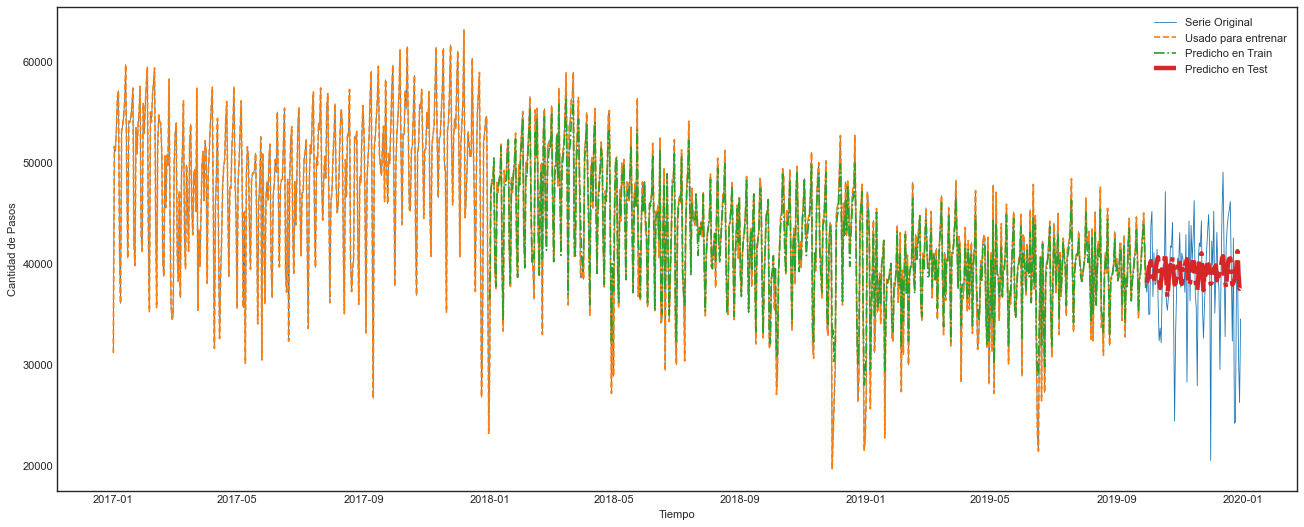

In [194]:
# Graficar el nuevo modelo

plt.figure(figsize=(20,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred_forest_best,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_forest_best,'-.', lw = 4, label = 'Predicho en Test') 
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.show()

In [195]:
rmse_rf_train_best = np.sqrt( mean_squared_error(y_train, y_train_pred_forest_best) )
print('Error RMSE en Train:', rmse_rf_train_best.round (2))

rmse_rf_test_best = np.sqrt( mean_squared_error(y_test, y_test_pred_forest_best) )
print('Error RMSE en Test:',rmse_rf_test_best.round (2))

Error RMSE en Train: 1652.51
Error RMSE en Test: 5110.51


In [196]:
mape_rf = mean_absolute_percentage_error(y_test, y_test_pred_forest_best)
print ("MAPE Random Forest:", mape_xgb)

MAPE Random Forest: 11.138333571874687


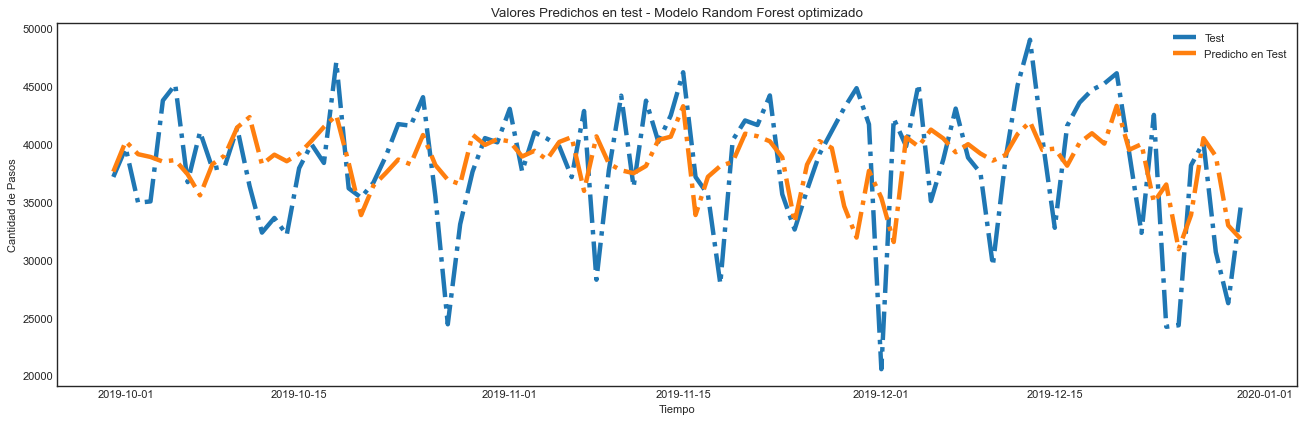

In [197]:
# Hacer un Zoom de los valores predichos en test

plt.figure(figsize=(20,6))
plt.plot(senial.index[N_train+look_back: length_total], y_test,'-.', lw = 4, label = 'Test')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.title ("Valores Predichos en test - Modelo Random Forest optimizado")
plt.show()

* Los resultados obtenidos a través de la optimización de hiperparámetros mejoran el RMSE, y se obtienen mejores valores que con el Modelo XGBoost Optimizado.

* Las gráficas y las métricas permiten determinar que en test se obtienen valores similares a los de XGBoost, con un menor RMSE y un leve incremento en el RMSE.
* El modelo a elegir para predicciones futuras el de XGboost, por obtener un pequeño mejor valor en la predicción.

### Efectuar el modelo de benchmark

In [198]:
# calculamos el error del modelo de benchmark:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]


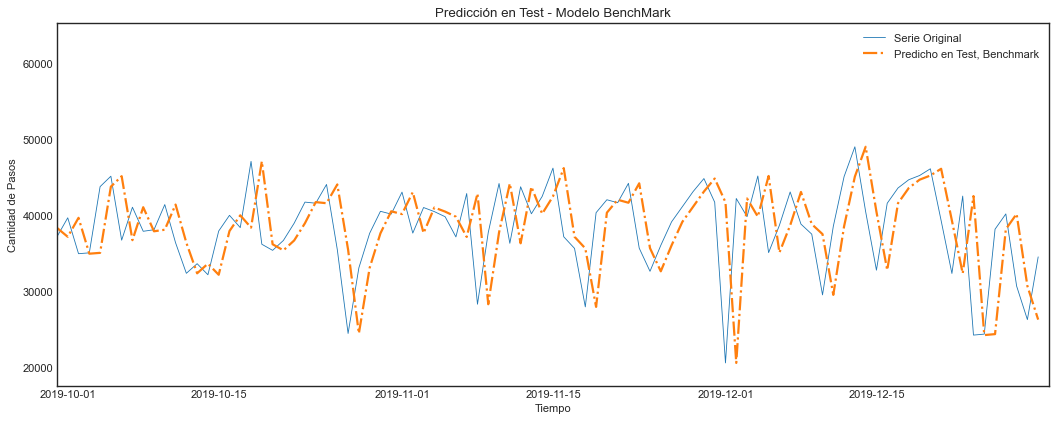

In [199]:
plt.figure(figsize=(16,6))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(senial.index[N_train+look_back], senial.index[length_total])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.title ("Predicción en Test - Modelo BenchMark")
plt.show()

La gráfica permite observar como el modelo de benchmark al predecir el valor siguiente con el valor anterior, se desplaza un día, captando el comportamiento de la serie pero como la misma no tiene un comportamiento similar entre días, genera diferencias que impactan en el nivel de error del modelo. Este tipo de modelos puede ser últil en series con un comportamiento similar entre período y período

In [200]:
# calculamos el error del modelo de benchmark:
MSE_bench = mean_squared_error(y_test, y[-1 + N_train:N_train+N_test - 1])
print("RMSE en Benchmark", np.sqrt(MSE_bench))

RMSE en Benchmark 6810.747635810304


In [201]:
mape_bench = mean_absolute_percentage_error (y_test, y[-1 + N_train:N_train+N_test - 1])
print ("MAPE en BenchMark:", mape_bench)

MAPE en BenchMark: 14.724487953515828


El modelo de Benchmark presenta valores más altos de error que los modelos de XGBoost y RandomForest Optimizados.

In [202]:
comparativo_2 = pd.DataFrame({"Modelos":["Sarima Diario", "Seasonal Exponential Smoothing", "Holt", "Holt Winters", "Prophet", "XGBoost", "Random Forest", "Benchmark"], "RMSE" :[rmse_sarima_diario, rmse_se, rmse_holt, rmse_holt_win, rmse_prophet, rmse_xgb_test_best, rmse_rf_test_best,  MSE_bench], 
"MAPE": [mape_sarima, mape_se, mape_holt, mape_holt_win, mape_prophet, mape_rf, mape_xgb, mape_bench]})

comparativo_2

Modelos          RMSE       MAPE
0                   Sarima Diario  5.654160e+03  12.481522
1  Seasonal Exponential Smoothing  5.768528e+03  13.036221
2                            Holt  5.800564e+03  13.114703
3                    Holt Winters  5.274142e+03  11.520000
4                         Prophet  5.334565e+03  16.412893
5                         XGBoost  5.111801e+03  11.286269
6                   Random Forest  5.110507e+03  11.138334
7                       Benchmark  4.638628e+07  14.724488

* El modelo de XGBoost es el que obtiene valores de RMSE menores al resto, seguido del modelo de RandomForest y Holt Winters con el Método Multiplicativo para tendencia y estacionalidad.


### Interpretación de las predicciones llevadas a cabo y exploración de la información utilizada para las predicciones

Los modelos de predicción de Aprendizaje supervisado utilizados para la predicción, obtienen un MAPE y RMSE levemente inferior al modelo de Holt Winters. Estos modelos, utilizan una ventana de datos de la serie para luego entrenar el modelo, y posteriomente llevar a cabo las predicciones, son modelos de regresión y no modelos específicos para llevar a cabo el análisis de series de tiempo, en este caso, la ventana de tiempo es de 365 días para llevar a cabo la predicción.
El modelo comienza con las predicciones de esta manera, porque al haber creado una ventana de tiempo de 365 y contar con datos desde 1ro de Enero de 2017, el modelo no cuenta con información previa para generar una mayor ventana de entrenamiento.

El modelo de Holt Winters, obtiene valores levemente superiores al modelo de XGBoost, pero captura de mejor manera los componentes de estacionalidad y tendencia que los modelos de aprendizaje pueden generar errores al efectuar predicciones por un largo período de tiempo, como en este caso que se pretende predecir un año con valores diarios.

* Se concluye que el mejor modelo para las predicciones de 2020, es el Modelo de Holt. 


## Predicciones 2020 

## Predicción a Futuro - 2020
Se llevará a cabo la predicción de la cantidad de pasos para 2020 (Forecast) con el modelo de RandomForest optimizado.

In [203]:
import pandas as pd
from datetime import datetime
import numpy as np
# Crear un dataset vacío para 2020
date_rng = pd.date_range(start='1/1/2020', end='31/12/2020', freq='D')
df = pd.DataFrame(date_rng, columns=['date'])
df['cantidad_pasos'] = 0
df.tail()

date  cantidad_pasos
361 2020-12-27               0
362 2020-12-28               0
363 2020-12-29               0
364 2020-12-30               0
365 2020-12-31               0

In [204]:
# Setear el dataset en formato fecha
df['datetime'] = pd.to_datetime(df['date'])
df = df.set_index('datetime')
df.head()

date  cantidad_pasos
datetime                             
2020-01-01 2020-01-01               0
2020-01-02 2020-01-02               0
2020-01-03 2020-01-03               0
2020-01-04 2020-01-04               0
2020-01-05 2020-01-05               0

In [205]:
# ELiminar la columna fecha sobrante
df.drop(columns=['date'], inplace = True)
df.head()

cantidad_pasos
datetime                  
2020-01-01               0
2020-01-02               0
2020-01-03               0
2020-01-04               0
2020-01-05               0

In [206]:
# Concatenar al dataset utilizado para entrenar

diario_concat=pd.concat([diario,df], ignore_index=False)

In [207]:
# Crear nuevamente el set para la predicción
senial_2020 = diario_concat.cantidad_pasos
senial_2020.head()

2017-01-01    31183.0
2017-01-02    51568.0
2017-01-03    51093.0
2017-01-04    53332.0
2017-01-05    56486.0
Name: cantidad_pasos, dtype: float64

In [208]:
senial_2020.tail()

2020-12-27    0.0
2020-12-28    0.0
2020-12-29    0.0
2020-12-30    0.0
2020-12-31    0.0
Name: cantidad_pasos, dtype: float64

In [209]:
# Generar las matrices vacías
N_2020 = senial_2020.shape[0]
X_2020 = np.zeros((N_2020 - look_back - 1,look_back))
y_2020 = np.zeros(N_2020 - look_back - 1)
print(X_2020.shape, y_2020.shape)

(1095, 365) (1095,)


In [210]:
# Completar con los valores de 2019

for i in range(X_2020.shape[0]):
    X_2020[i,:] = senial_2020.iloc[i:i+look_back]
    y_2020[i] = senial_2020.iloc[i+look_back]

In [211]:
# Creamos el set de train y de test
N_train_2020 = diario.shape[0] -1 - look_back # cantidad de instancias que vamos a usar para entrenar. 
print (N_train_2020)
N_test_2020 = 366 # El año 2020 es bisiesto
print (N_test_2020)
N_total_2020 = N_train_2020 + N_test_2020
print (N_total_2020)

length_total_2020 = N_train_2020 + N_test_2020 + look_back

729
366
1095


In [212]:
X_train_2020 = X_2020[:N_train_2020,:]
y_train_2020 = y_2020[:N_train_2020]
print(X_train_2020.shape, y_train_2020.shape)

X_test_2020 = X_2020[N_train_2020:N_train_2020+N_test_2020,:]
y_test_2020 = y_2020[N_train_2020:N_train_2020+N_test_2020]
print(X_test_2020.shape, y_test_2020.shape)

(729, 365) (729,)
(366, 365) (366,)


In [213]:
# Predecir con los valores del modelo optimizado 
y_train_pred_2020 = forest_best.predict(X_train_2020)
y_test_pred_2020 = forest_best.predict(X_test_2020)

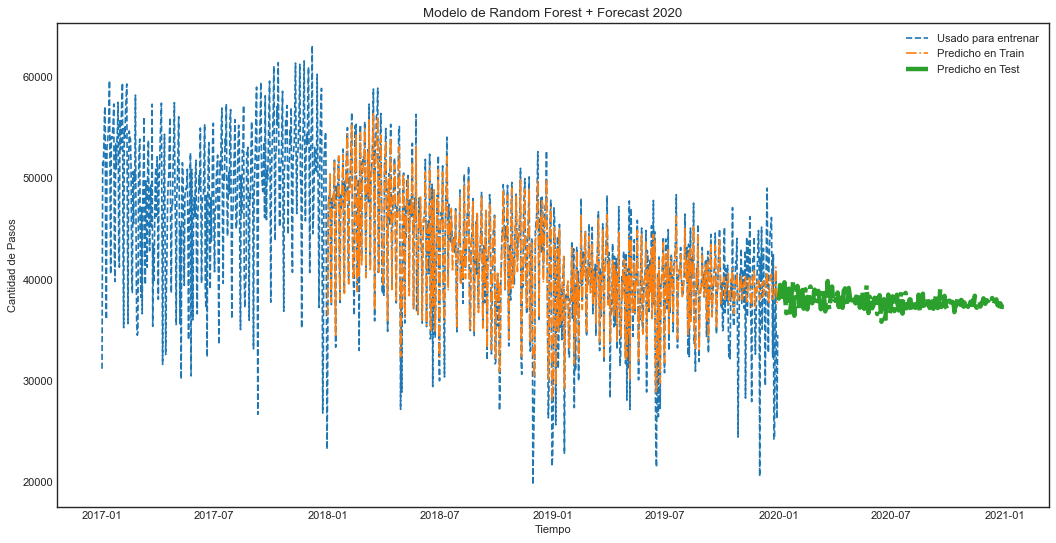

In [214]:
# Graficar el modelo completo
plt.figure(figsize=(16,8))
plt.plot(senial_2020.index[:N_train_2020 + look_back], senial_2020[:N_train_2020 + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial_2020.index[look_back: look_back + N_train_2020], y_train_pred_2020,'-.',label = 'Predicho en Train')
plt.plot(senial_2020.index[N_train_2020+look_back: length_total_2020], y_test_pred_2020,'-.', lw = 4, label = 'Predicho en Test') 
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.title ("Modelo de Random Forest + Forecast 2020")
plt.show()

* El modelo comienza entrenando los datos con mucha exactitud, pero la misma va disminuyendo con el paso del tiempo. Es por ello, que al efectuar el forecast, no captura correctamente los valores máximos y mínimos. A su vez, al tratarse de un modelo de regresión tiende a efectuar predicciones cercanas a la media.

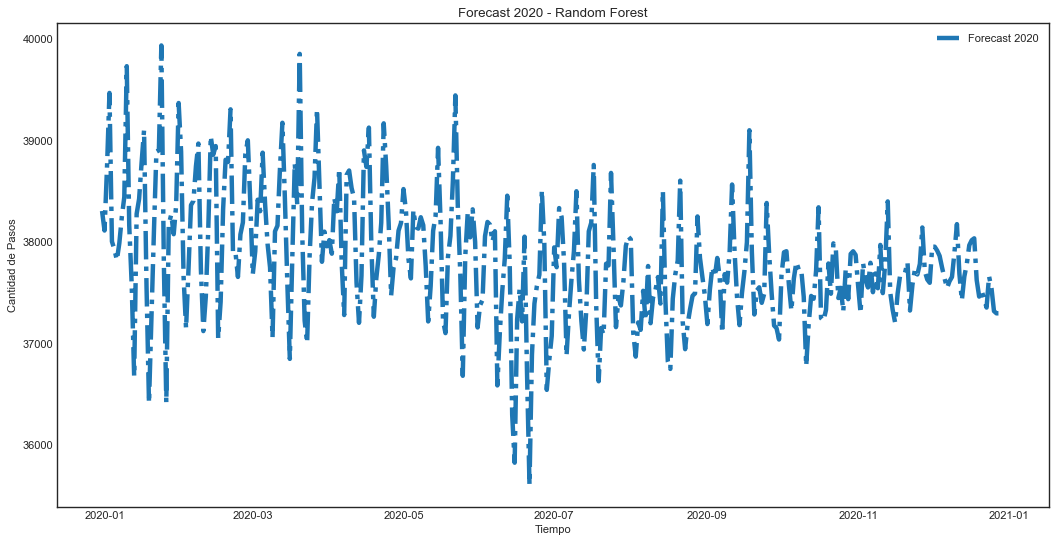

In [215]:
# Graficar solo la predicción 2020:
plt.figure(figsize=(16,8))
plt.plot(senial_2020.index[N_train_2020+look_back: length_total_2020], y_test_pred_2020,'-.', lw = 4, label = 'Forecast 2020') 
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.title ("Forecast 2020 - Random Forest")
plt.show()

* Se puede observar que la predicción de 2020 a grandes razgos captura la estacionalidad de la serie original, con valores medios inferiores a los de años anteriores. A medida que pasa el tiempo, el modelo comienza a capturar en menor medida el comportamiento original de la serie, ya que no cuenta con datos reales para llevar a cabo las predicciones.


C:\Users\Virginia\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


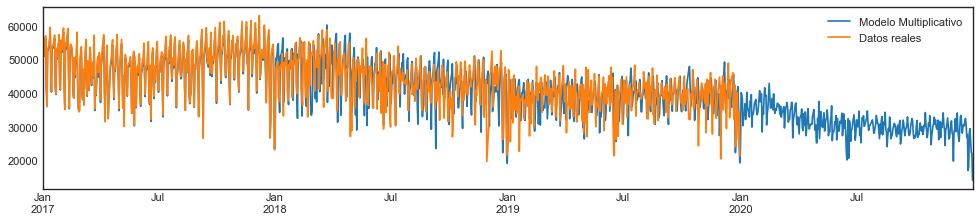

In [216]:
# Efectuar la predicción 2020 del Modelo de Holt Winters de mejores resultados
h= 365 # un Año
w=365*3

# Entrenamiento del modelo para predecir todo 2020
model = sm.tsa.ExponentialSmoothing(diario, 
                    trend='mul', damped=False, seasonal='mul', seasonal_periods=365).fit()

# Graficar el modelo
plot = pd.DataFrame()
plot['Modelo Multiplicativo'] = pd.concat([model.fittedvalues, model.forecast(h)])
plot['Datos reales'] = diario

plot[-(w+h):].plot();#figsize=(9,6))

# Conclusiones finales



* Se llevó a cabo una introducción a las series de tiempo, buscando introducir los temas principales de manera breve.
* Se efecuo un análisis exploratorio exhaustivo, para comprender la composición de una serie y como los datos pueden ser modelados con el objetivo de comprender la serie y la selección de parámetros como por ejemplo la frecuencia de predicción.
* Se implementaron los modelos de predicción específicos a la temática, como también modelos de aprendizaje supervisado, con el objetivo de comprobar si mejoran las métricas de predicción.

La serie de tiempo analizada contiene información respecto a la cantidad de pasos por el Peaje de la Autopista Illia con la modalidad de Pago en Efectivo, para los años 2017 a 2019.
La serie presenta una tendenncia decreciente, que se justiifica en la migración de los usuarios de la modalidad de pago en efectivo a la modalidad de pago de Telepase.
El Análisis exploratorio permitió determinar que se trata de una serie estacionaria, con un componente estacional y de tendencia.
Mediante el análisis de autocorrelación, se pudo determinar que la serie presenta un comportamiento cíclico que se repite cada 7 períodos, indicando que la cantidad de pasos se encuentra relacionada con el día de la semana.
Se desarrollaron modelos de predicción de Aprendizaje supervisado como son XGboost y RandomForest, como también modelos específicos de Series de tiempo como son: SARIMA, Simple Exponential Smoothing, Holt y Holt Winters.
* Los Modelos de Random Forest, XGBoost y Holt Winters obtienen métricas similares de RMSE y MAPE.
* Se llevaron a cabo las predicciones 2020 con los Modelos de Random Forest y Holt Winters.
* Se concluye que el modelo que proporciona una mejor predicción para una ventana de tiempo de un año, es el modelo de Holt Winters, ya que captura la tendencia y estacionalidad de la serie, cuestión que el Modelo de RandomForest no predice correctamente. 




* Se llevó a cabo una introducción a las series de tiempo, buscando introducir los temas principales de manera breve.
* Se efecuo un análisis exploratorio exhaustivo, para comprender la composición de una serie y como los datos pueden ser modelados con el objetivo de comprender la serie y la selección de parámetros como por ejemplo la frecuencia de predicción.
* Se implementaron los modelos de predicción específicos a la temática, como también modelos de aprendizaje supervisado, con el objetivo de comprobar si mejoran las métricas de predicción.
